# UCLA T32 Single-Cell Analysis Workshop

In this tutorial we'll demonstrate the analysis of a single-cell dataset using the Seurat package. Seurat is a popular R toolkit for the analysis of single-cell data developed by the [Satija lab](https://satijalab.org) at the New York Genome Center. You can find extensive documentation and example analyses on the Seurat website: https://satijalab.org/seurat/index.html

If you're new to R, some excellent resources for getting started with the language are available here: https://swirlstats.com, https://www.codecademy.com/learn/learn-r

In this workshop we'll also be running an analysis using jupyter notebooks. These are intuitive to use, and enable mixing code with text. You can find out more about jupyter notebooks and jupyterlab here: https://jupyter.org

## Loading data


We'll start by loading the Seurat package in our R session, and loading a single-cell dataset from 10x Genomics. See the readme file for instructions on how to download this dataset.

In [1]:
# change plot output size for the document
options(repr.plot.width=15, repr.plot.height=10)

In [2]:
library(Seurat)
library(ggplot2)
library(Matrix)

Attaching SeuratObject



In [3]:
counts <- Read10X("filtered_feature_bc_matrix/")

10X data contains more than one type and is being returned as a list containing matrices of each type.



`Read10X()` is a handy function designed to load the output of the 10x Genomics Cellranger software, and provides an easy way to load in any data processed using Cellranger. If we had data that was preprocessed differently (for example, using [Alevin](https://alevin-fry.readthedocs.io/en/latest/) or [kallisto](https://pachterlab.github.io/kallisto/about)), we may need to use other functions to get the data into R. The only requirement for creating a Seurat object is that we have the data in a matrix.

We can take a look at what was returned here by the `Read10X()` function:

In [4]:
class(counts)

[1] "list"

In [5]:
names(counts)

[1] "Gene Expression"  "Antibody Capture"

In [6]:
sapply(counts, class)

Gene Expression Antibody Capture 
     "dgCMatrix"      "dgCMatrix"

You can see that in this case, the function has returned a list of matrices since we have multimodal data.

Another thing we can notice is that the sparsity and dimension of the different modalities is very different:

In [7]:
counts$`Gene Expression`[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
            AATCACGAGCAGCCCT-1 AATCACGAGGAACTCG-1 AATCACGCACTACCGG-1
MIR1302-2HG                  .                  .                  .
FAM138A                      .                  .                  .
OR4F5                        .                  .                  .
AL627309.1                   .                  .                  .
AL627309.3                   .                  .                  .
            AATCACGCATGAATAG-1 AATCACGGTATAGGAT-1
MIR1302-2HG                  .                  .
FAM138A                      .                  .
OR4F5                        .                  .
AL627309.1                   .                  .
AL627309.3                   .                  .

In [8]:
counts$`Antibody Capture`[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
       AATCACGAGCAGCCCT-1 AATCACGAGGAACTCG-1 AATCACGCACTACCGG-1
CD3                   414                179                556
CD4.1                 639                 77                 96
CD8                    24                238                216
CD11c                  53                 23                 49
CD14.1                233                110                127
       AATCACGCATGAATAG-1 AATCACGGTATAGGAT-1
CD3                   271                246
CD4.1                 393                121
CD8                     4                 19
CD11c                  29                 51
CD14.1                126                193

In [9]:
sapply(counts, dim)

Gene Expression Antibody Capture
[1,] 36601            10             
[2,]   892           892

In [10]:
sapply(counts, function(x) sum(x == 0))

Gene Expression Antibody Capture 
        30639064              870

The difference in data sparsity here is expected, as the protein measurements are typically much more sensitive than the gene expression measurements.

## Creating the Seurat object

The Seurat object is a collection of `Assay` objects, each containing measurements for single cells. You can find out more information about the Seurat object design here: https://github.com/satijalab/seurat/wiki/Seurat.

We can construct a Seurat object using the `CreateSeuratObject()` function, and construct additional assays using the `CreateAssayObject()` function.

In [11]:
pbmc <- CreateSeuratObject(counts = counts$`Gene Expression`)

In [12]:
pbmc

An object of class Seurat 
36601 features across 892 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [13]:
pbmc[["ADT"]] <- CreateAssayObject(counts = counts$`Antibody Capture`)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [14]:
pbmc

An object of class Seurat 
36611 features across 892 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ADT

We now have a Seurat object containing two different assays, named RNA and ADT that contain the gene expression and cell surface protein information.

## Interacting with the Seurat object

There are several functions defined in Seurat that enable you to extract or add information from/to your Seurat object. The double square bracket `[[` is used to access data in the object (assays, metadata, or dimension reductions).

In [15]:
# pull the RNA assay
pbmc[['RNA']]

Assay data with 36601 features for 892 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.5, AL627309.4, AP006222.2, AL732372.1 

In [16]:
# take a look at the object metadata
head(pbmc)

orig.ident    nCount_RNA nFeature_RNA nCount_ADT
AATCACGAGCAGCCCT-1 SeuratProject 3058       1020         1651      
AATCACGAGGAACTCG-1 SeuratProject 2176        975          788      
AATCACGCACTACCGG-1 SeuratProject 5536       2120         1305      
AATCACGCATGAATAG-1 SeuratProject 5077       1462         1007      
AATCACGGTATAGGAT-1 SeuratProject 7386       2097          928      
AATCACGGTCGAATGG-1 SeuratProject 3966       1333         1428      
AATCACGGTGTCTAAC-1 SeuratProject 6357       1541         1077      
AATCACGTCCACGTAA-1 SeuratProject 5737       1506          895      
AATCACGTCCCGTTGT-1 SeuratProject 5332       1742         1610      
AATCACGTCGCCTTGT-1 SeuratProject 9873       3263         2566      
                   nFeature_ADT
AATCACGAGCAGCCCT-1  9          
AATCACGAGGAACTCG-1  9          
AATCACGCACTACCGG-1  9          
AATCACGCATGAATAG-1  9          
AATCACGGTATAGGAT-1  9          
AATCACGGTCGAATGG-1 10          
AATCACGGTGTCTAAC-1  9          
AATCACGTCCACGTAA-1  9          
AATCACGTCCCGTTGT-1  9          
AATCACGTCGCCTTGT-1  9

In [17]:
# look at the features present in each assay
head(rownames(pbmc[["RNA"]]))

[1] "MIR1302-2HG" "FAM138A"     "OR4F5"       "AL627309.1"  "AL627309.3" 
[6] "AL627309.2"

In [18]:
rownames(pbmc[["ADT"]])

[1] "CD3"                    "CD4.1"                  "CD8"                   
 [4] "CD11c"                  "CD14.1"                 "CD16"                  
 [7] "CD19.1"                 "CD56"                   "CD45"                  
[10] "IgG1-control-TotalSeqC"

We can also add information to the Seurat object:

In [19]:
# add metadata
pbmc$test_metadata <- "test"
head(pbmc,3)

orig.ident    nCount_RNA nFeature_RNA nCount_ADT
AATCACGAGCAGCCCT-1 SeuratProject 3058       1020         1651      
AATCACGAGGAACTCG-1 SeuratProject 2176        975          788      
AATCACGCACTACCGG-1 SeuratProject 5536       2120         1305      
                   nFeature_ADT test_metadata
AATCACGAGCAGCCCT-1 9            test         
AATCACGAGGAACTCG-1 9            test         
AATCACGCACTACCGG-1 9            test

In [20]:
# remove metadata
pbmc$test_metadata <- NULL
head(pbmc, 3)

orig.ident    nCount_RNA nFeature_RNA nCount_ADT
AATCACGAGCAGCCCT-1 SeuratProject 3058       1020         1651      
AATCACGAGGAACTCG-1 SeuratProject 2176        975          788      
AATCACGCACTACCGG-1 SeuratProject 5536       2120         1305      
                   nFeature_ADT
AATCACGAGCAGCCCT-1 9           
AATCACGAGGAACTCG-1 9           
AATCACGCACTACCGG-1 9

## Changing assays

An important feature of the Seurat design is its ability to store multiple assays. In our `pbmc` object we have two assays, but we could store any number of assays if we liked. Most functions in Seurat will operate on the "default" assay if not specified otherwise. This allows us to interactively analyze the data without needing to constantly say which assay we want the function to be run on. There are a couple of ways we can find out which assay is currently the default assay. We can print the object summary:

In [21]:
pbmc

An object of class Seurat 
36611 features across 892 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ADT

Or we could use the `DefaultAssay()` function:

In [22]:
DefaultAssay(pbmc)

[1] "RNA"

We can also change the default assay like so:

In [23]:
DefaultAssay(pbmc) <- "ADT"
pbmc

An object of class Seurat 
36611 features across 892 samples within 2 assays 
Active assay: ADT (10 features, 0 variable features)
 1 other assay present: RNA

In [24]:
# change the assay back to RNA
DefaultAssay(pbmc) <- "RNA"
pbmc

An object of class Seurat 
36611 features across 892 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ADT

You can check what happens if you try to change to an assay that doesn't exist:

In [25]:
# DefaultAssay(pbmc) <- "ATAC"

It throws an error saying that we don't have an assay named "ATAC" in this dataset

## Quality control

A common quality control metric used for scRNA-seq is the percentage of reads mapping to the mitochondrial genome. We can compute this metric using the `PercentageFeatureSet()` function

In [26]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [27]:
head(pbmc, 3)

orig.ident    nCount_RNA nFeature_RNA nCount_ADT
AATCACGAGCAGCCCT-1 SeuratProject 3058       1020         1651      
AATCACGAGGAACTCG-1 SeuratProject 2176        975          788      
AATCACGCACTACCGG-1 SeuratProject 5536       2120         1305      
                   nFeature_ADT percent.mt
AATCACGAGCAGCCCT-1 9             6.572923 
AATCACGAGGAACTCG-1 9            18.060662 
AATCACGCACTACCGG-1 9             5.491329

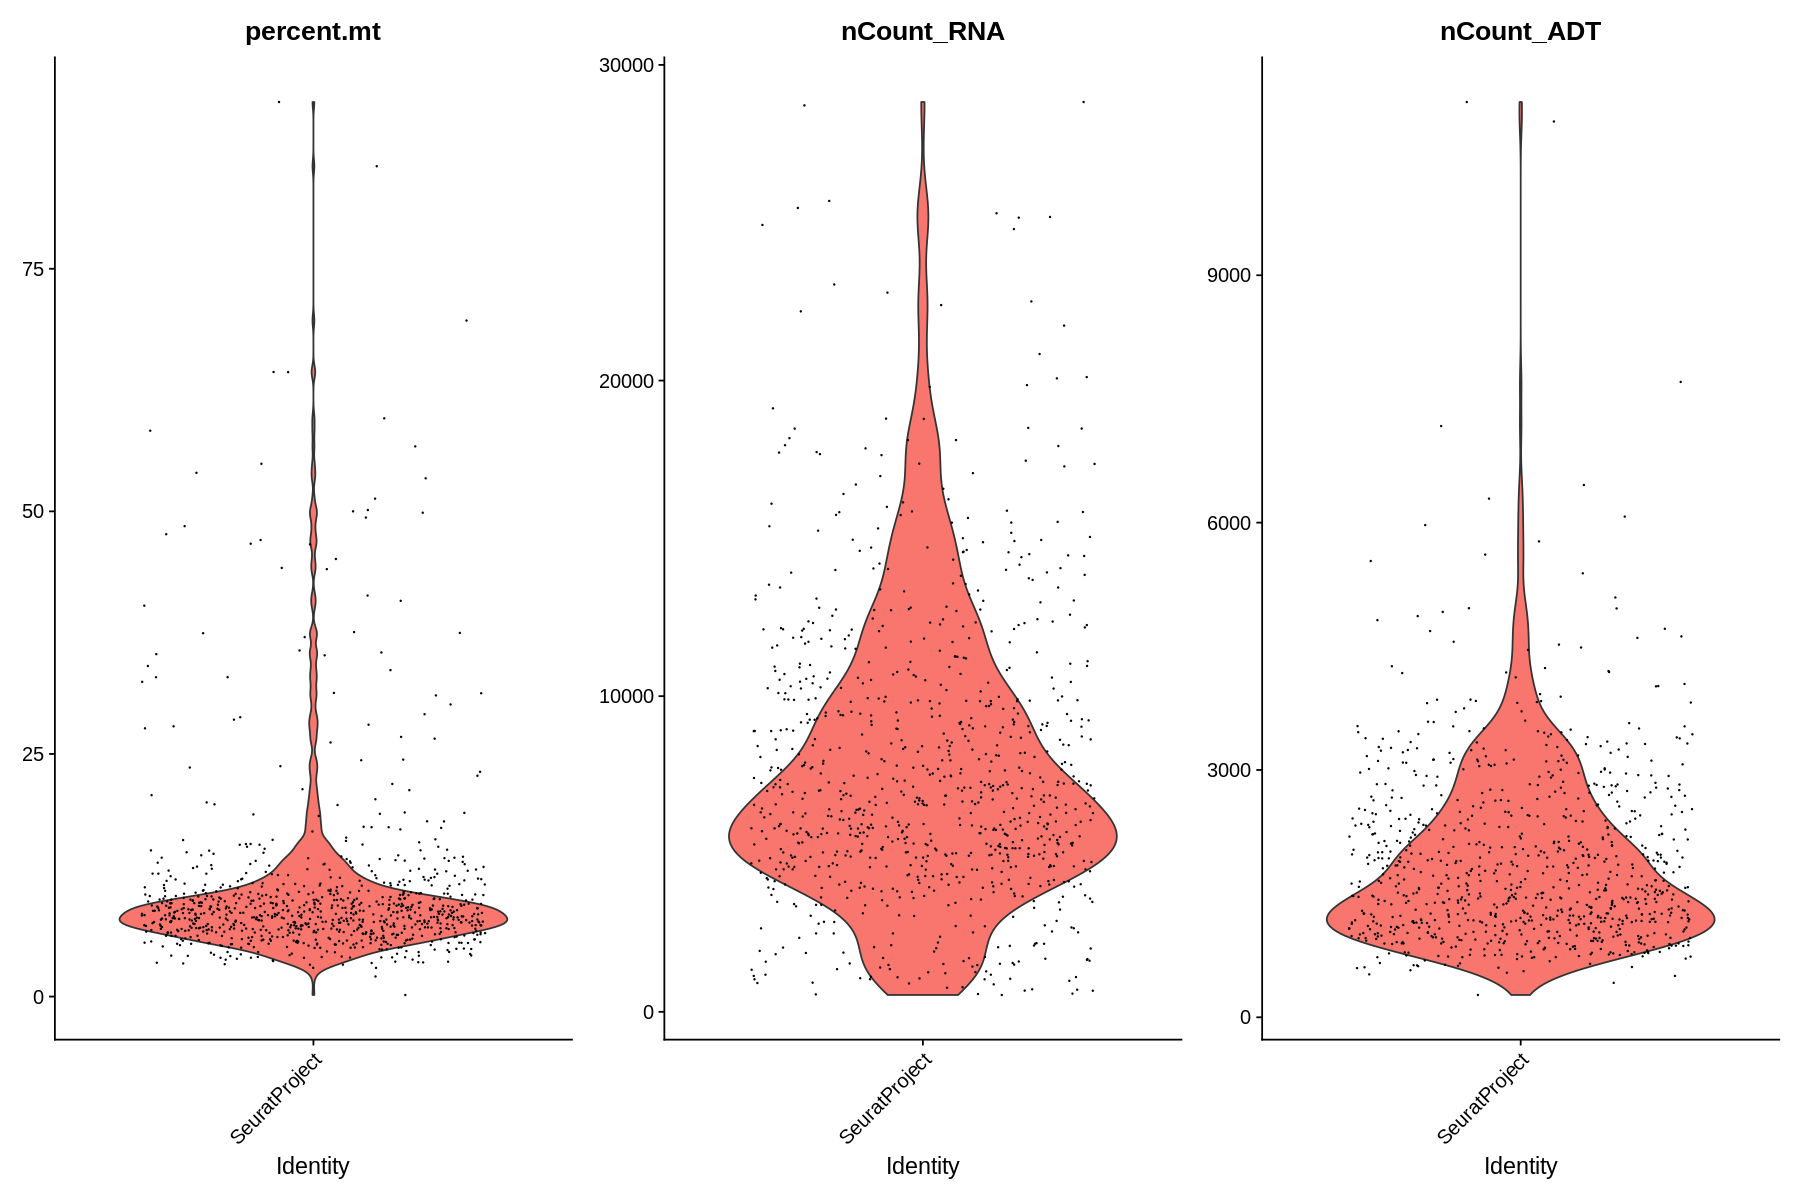

In [28]:
# plot some different QC metrics
VlnPlot(pbmc, c("percent.mt", "nCount_RNA", "nCount_ADT"))

In [29]:
# remove low-quality cells
pbmc <- subset(pbmc, subset = percent.mt < 20 & nCount_RNA > 500 & nCount_ADT > 500)

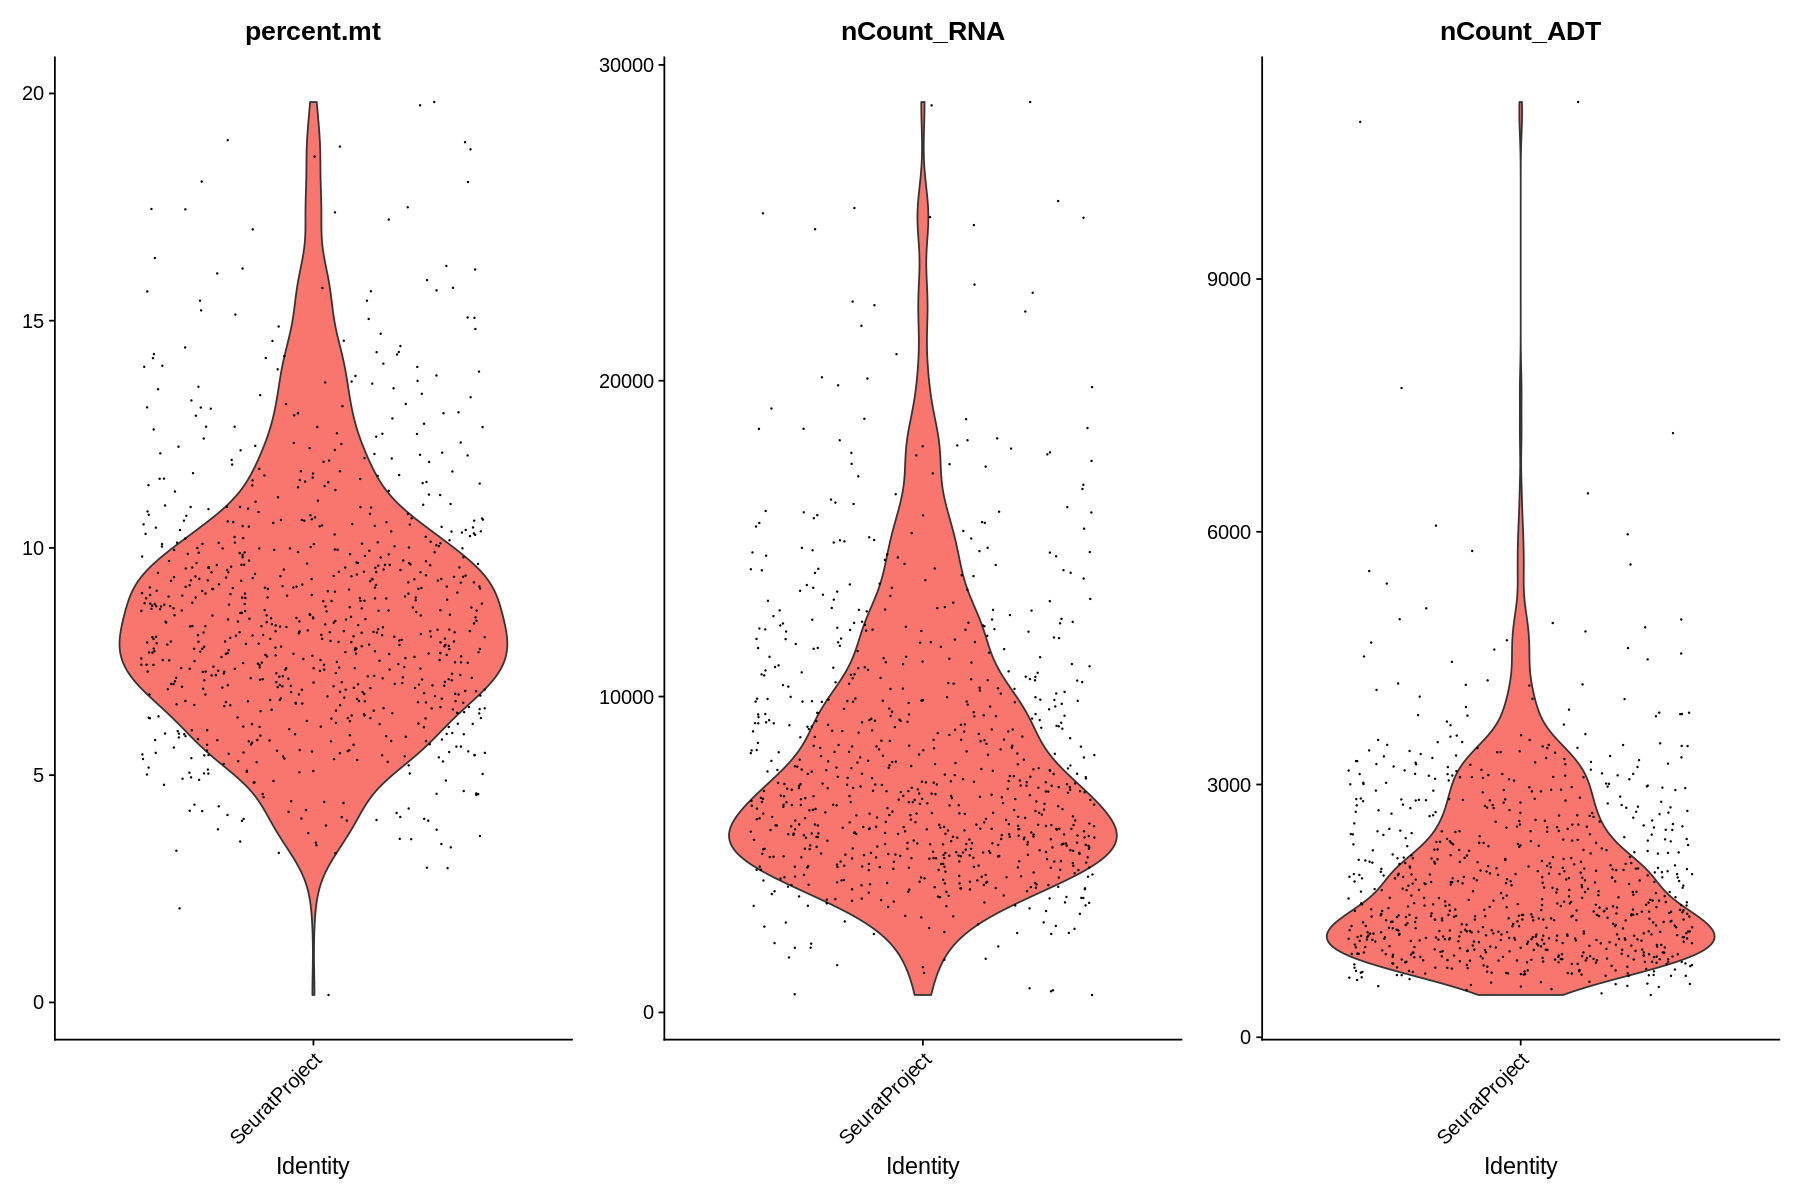

In [30]:
VlnPlot(pbmc, c("percent.mt", "nCount_RNA", "nCount_ADT"))

## Feature selection

Many genes measured in the dataset will not be informative for distinguishing between the different cell types. Many genes will not be expressed at all in the immune cells, or may be very lowly expressed, or may be uniformly expressed across the different cell types. Identifying the most informative subset of genes to focus our analysis on will improve the results of downstream steps in the analysis (such as dimension reduction), as the including of non-informative genes would only serve to add noise to the dataset (low biological variation, high technical variation).

Ideally, we'd be able to simply select genes with the highest variance. Let's take a look at the relationship between mean expression and expression variance in our dataset:

In [31]:
# extract the count matrix from our dataset
count.matrix <- GetAssayData(pbmc, assay = "RNA", slot = "counts")

# compute mean and variance for each gene
gene.mean <- rowMeans(count.matrix)
gene.variance <- apply(count.matrix, 1, var)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


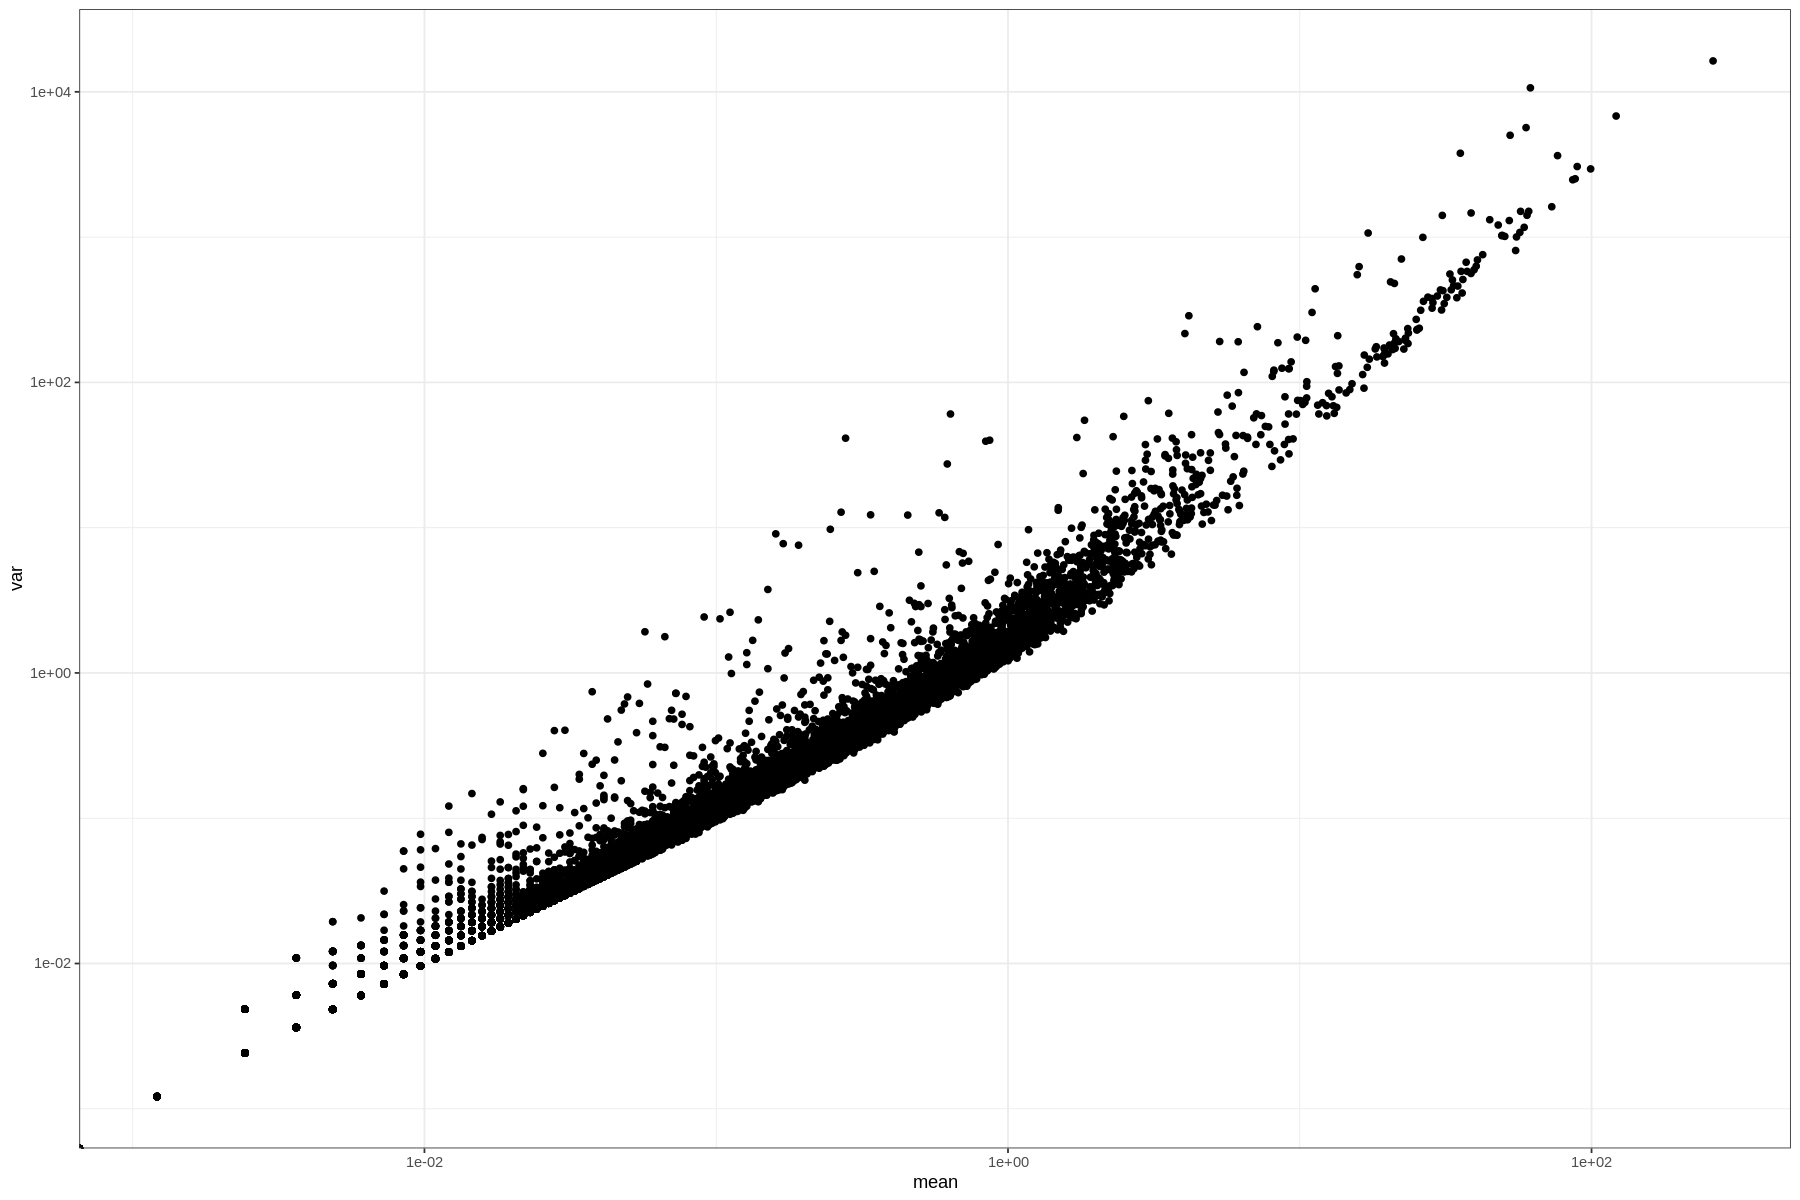

In [32]:
ggplot(data.frame("mean" = gene.mean, "var" = gene.variance), aes(mean, var)) +
geom_point() +
scale_x_log10() + scale_y_log10() +
theme_bw()

As you can see, the mean and variance are highly correlated. Selecting high-variance genes would simply result in selecting the most highly expressed genes in the dataset if we don't correct for the mean-variance relationship.

One simple way to correct for this relationship is to model the mean-variance relationship and look for genes with higher variance than expected given the mean expression of the gene (high model residuals). This is what's done by the `FindVariableFeatures()` function in Seurat (when using `selection.method='vst'`)

In [33]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst")

In [34]:
pbmc

An object of class Seurat 
36611 features across 825 samples within 2 assays 
Active assay: RNA (36601 features, 2000 variable features)
 1 other assay present: ADT

As you can see from the object summary, we now have a set of variable features associated with the RNA assay in our Seurat object. We can visualize the standardized variance for each gene (residual from the mean-variance model fit) using Seurat:

Warning message:
“Transformation introduced infinite values in continuous x-axis”


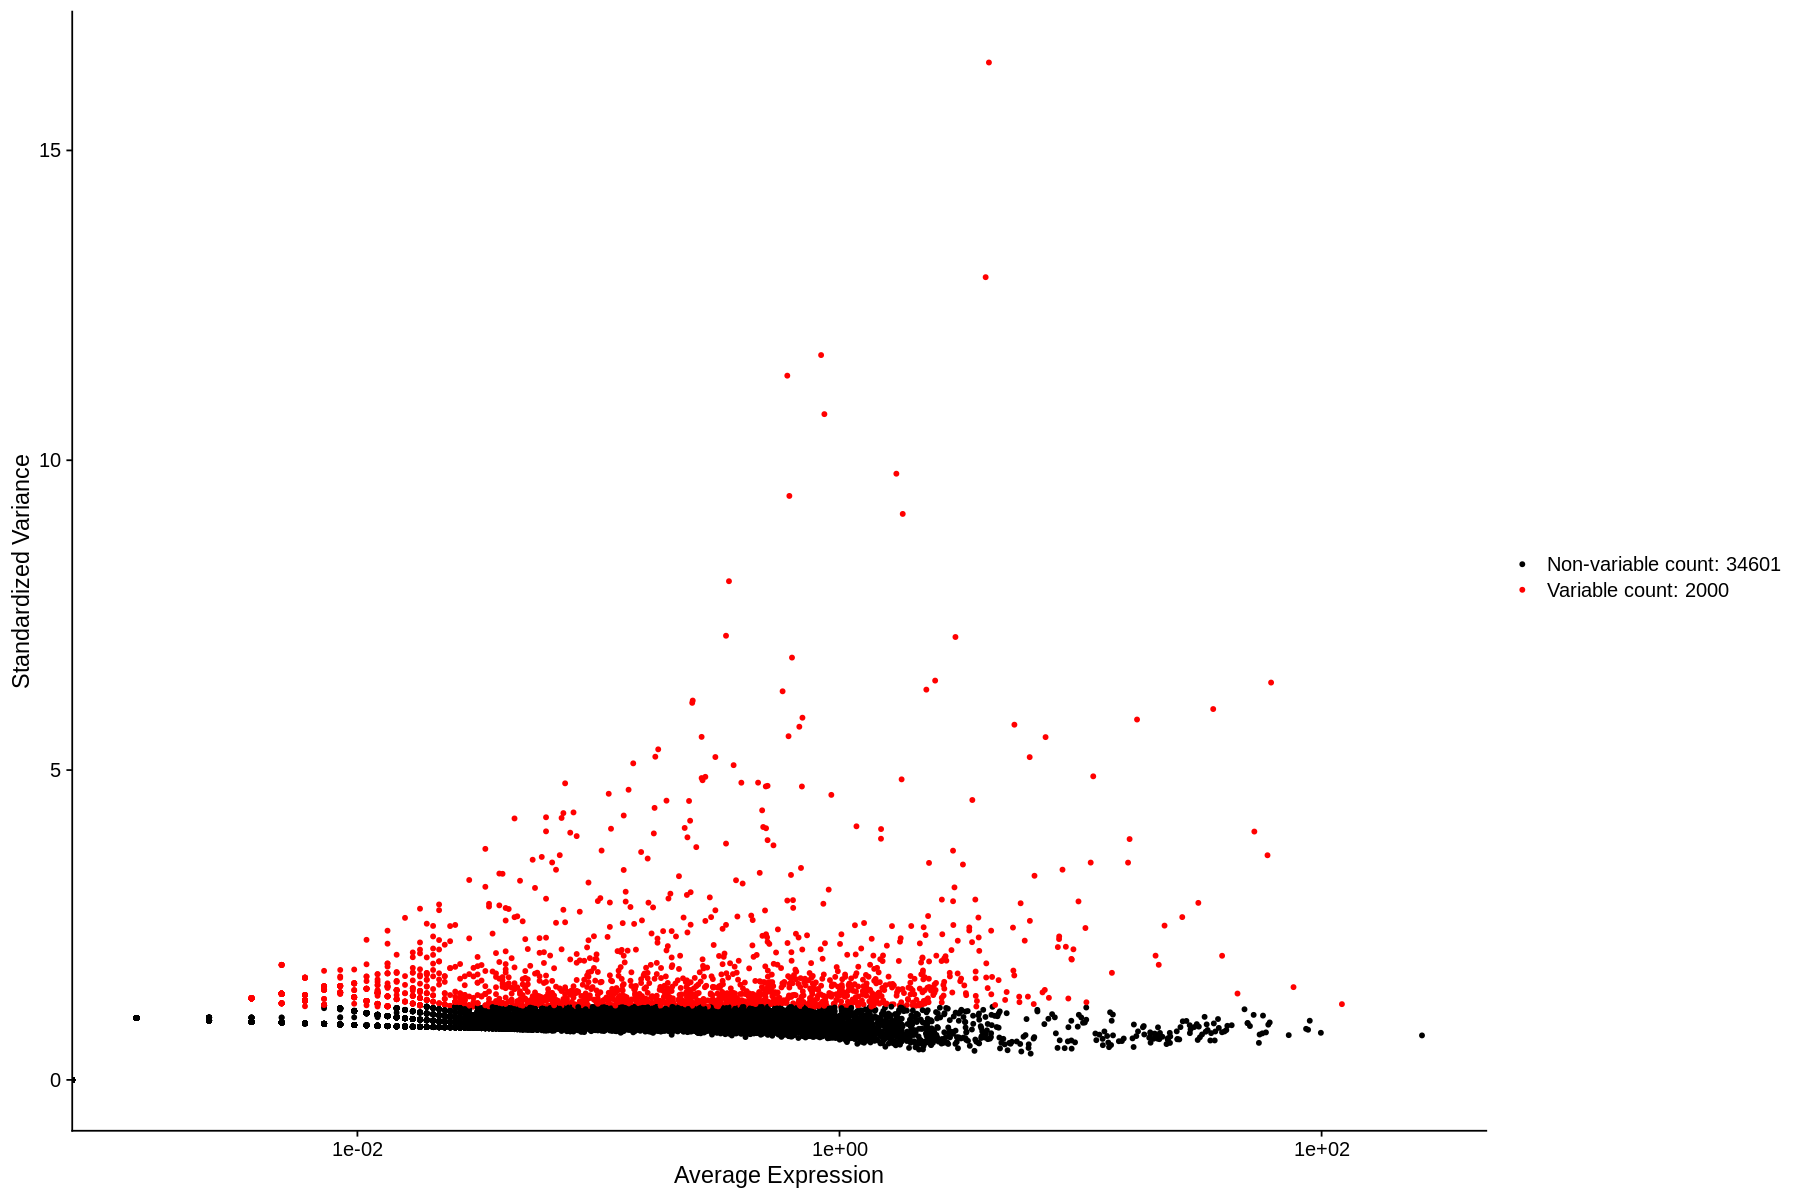

In [35]:
VariableFeaturePlot(pbmc)

The selected genes are shown in red, and you can see that we have avoided selecting the most highly expressed genes. By default we select 2,000 genes, but we can change the number selected using the `nfeatures` parameter in `FindVariableFeatures()`.

## scRNA-seq Data normalization

There is substantial variation in the total number of counts quantified for each cell:

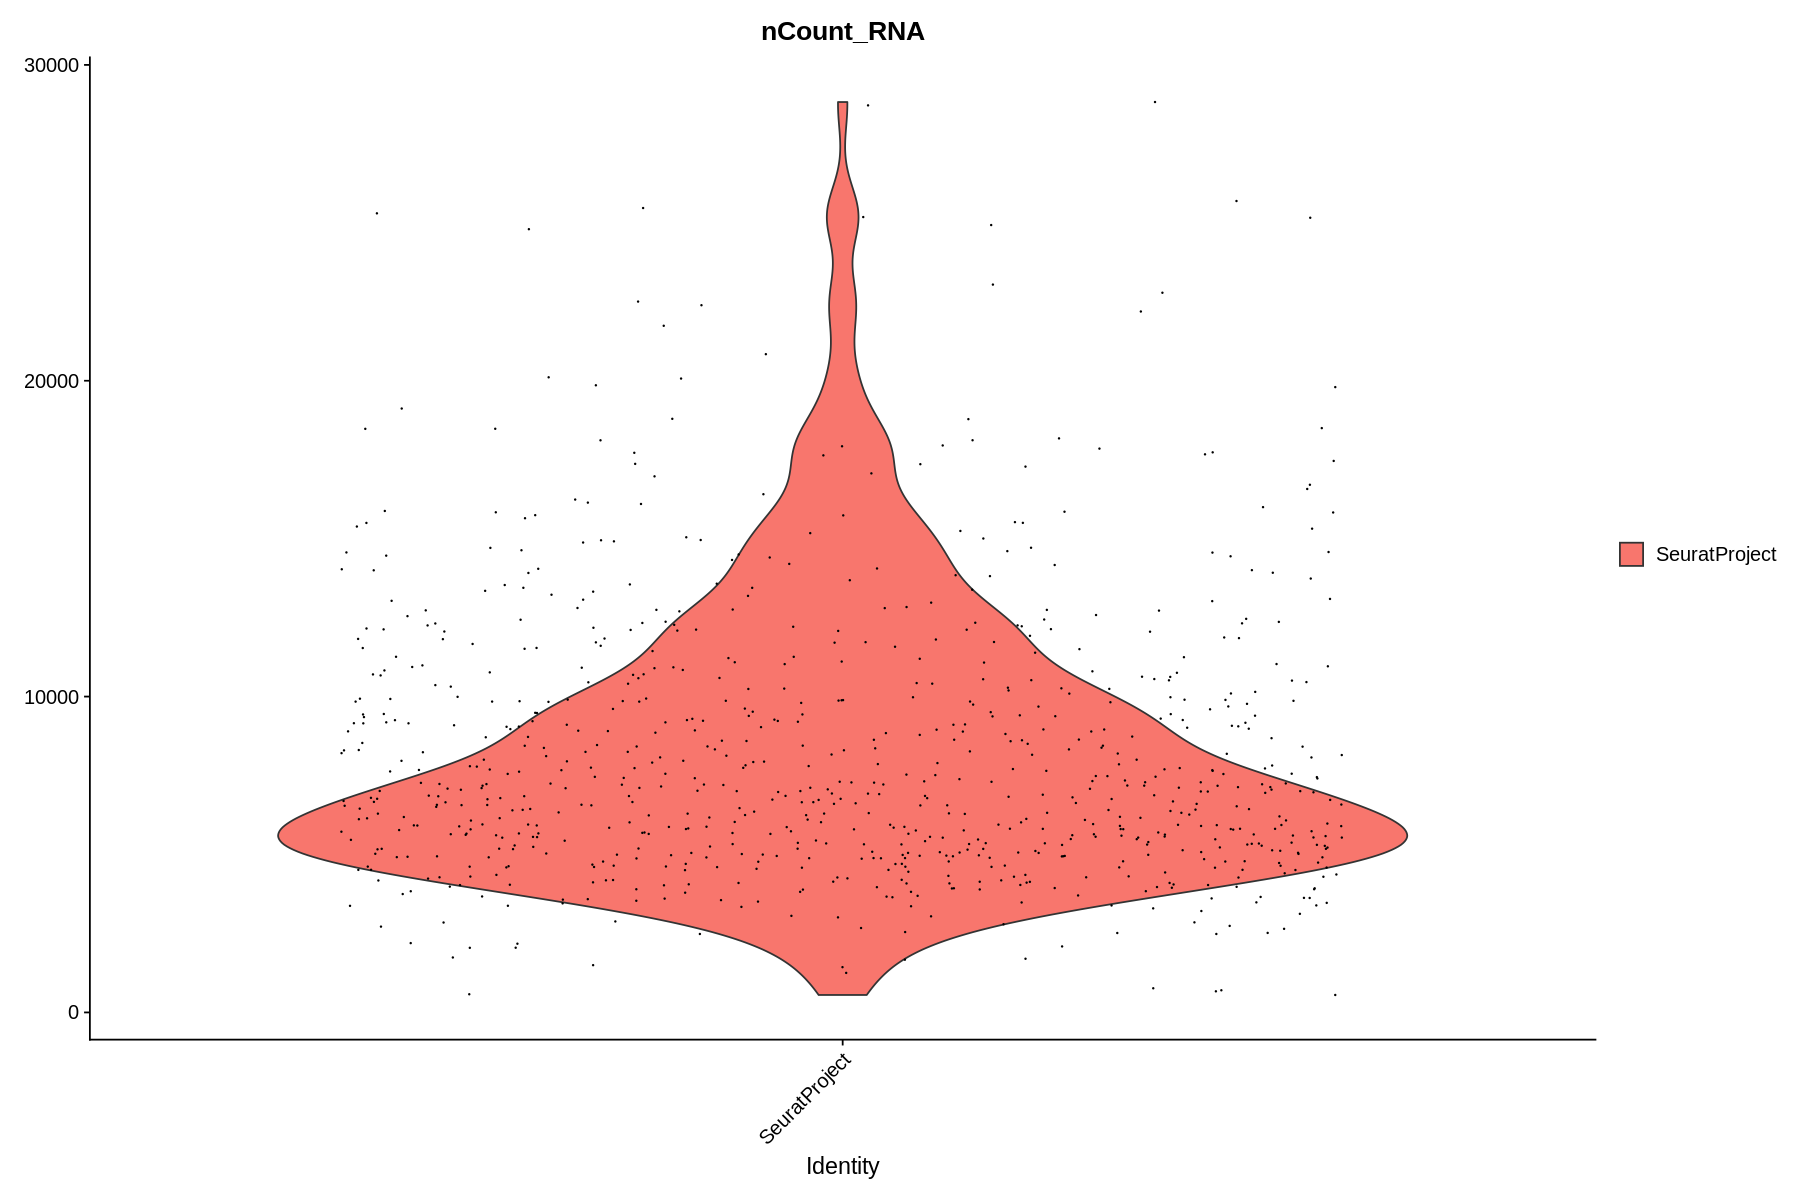

In [36]:
VlnPlot(pbmc, "nCount_RNA")

This introduces technical variation (differences in sequencing depth) that needs to be removed, while preserving the true biological variation in the dataset. This is the goal of data normalization.

An ideal normalization method would result in the following properties (taken from the [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) paper)

1. The normalized expression of a gene should not be correlated with the total sequencing depth of a cell
2. The variance of a normalized gene across all cells should primarily reflect the biological differences between cells, independent of transcript abundance or sequencing depth

We can see that neither of these properties are true of the unnormalized count data. Earlier we saw that there is a strong correlation between mean and variance, we can also see that for any particular gene, there is often a strong relationship between the sequencing depth for that cell and the total counts for the gene detected for that cell:

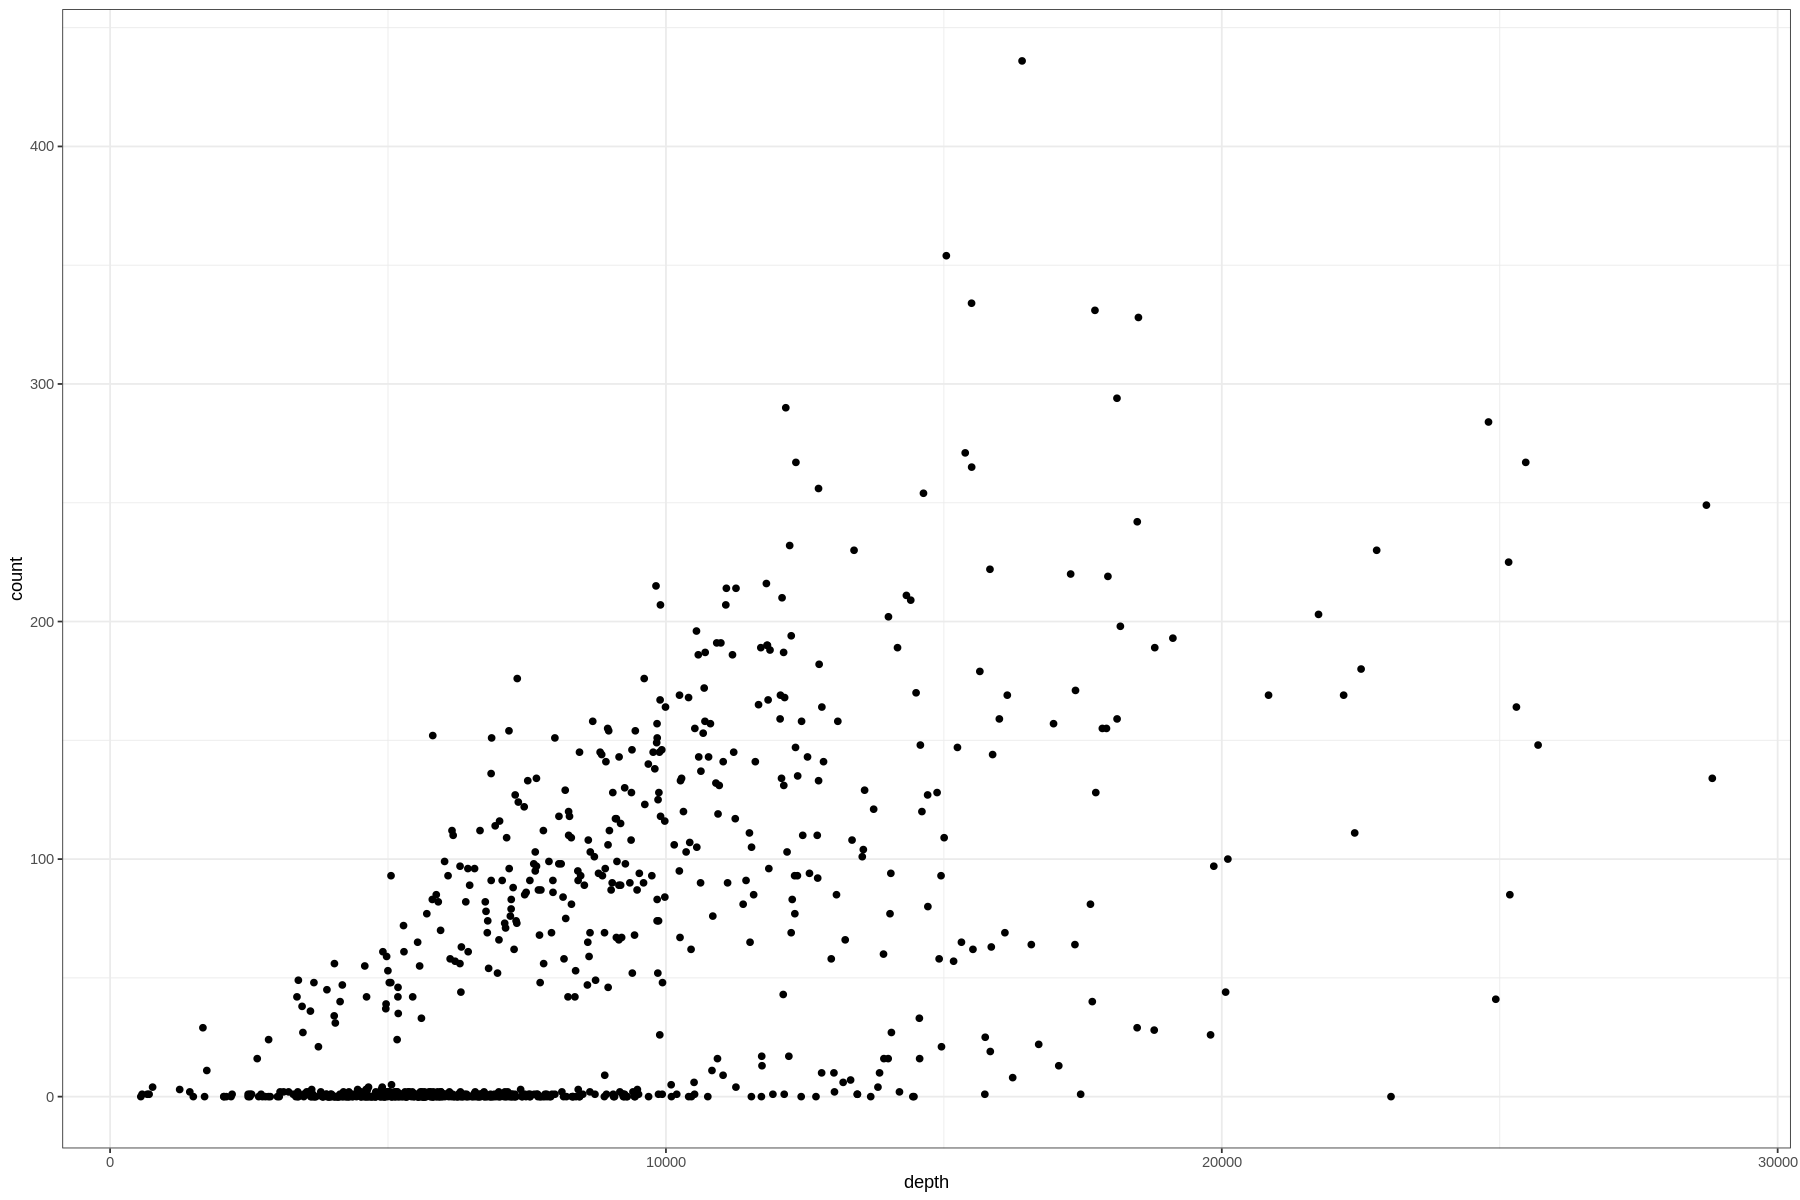

In [37]:
# correlation between total counts in the cell and counts for a particular gene
cell.umi.count <- colSums(count.matrix)
ggplot(data.frame(depth = cell.umi.count, count = count.matrix["LYZ", ]), aes(depth, count)) + geom_point() + theme_bw()

### Log normalization

One simple approach for normalization is to convert the raw counts to a counts-per-10000 value (correcting for differences in sequencing depth while avoiding very small numbers), and then taking the log of these values. A log transformation dampens the effect of outliers (ie, it stabilizes the variance), as well as reduces the effect of some genes having a higher basal expression level than others. When running downstream dimension reduction methods (eg, PCA) we want all genes to contribute equally, regardless of their basal expression level.

Let's take a look at this transformation applied to one gene in the dataset:

In [38]:
counts.use <- count.matrix["LYZ", ]

df <- data.frame(count = counts.use)
df$cpm <- counts.use / colSums(count.matrix) * 10000
df$log_cpm <- log(df$cpm + 1)

In [39]:
df <- tidyr::pivot_longer(df, cols = 1:3)
head(df)

name    value   
1 count   2.000000
2 cpm     6.540222
3 log_cpm 2.020252
4 count   0.000000
5 cpm     0.000000
6 log_cpm 0.000000

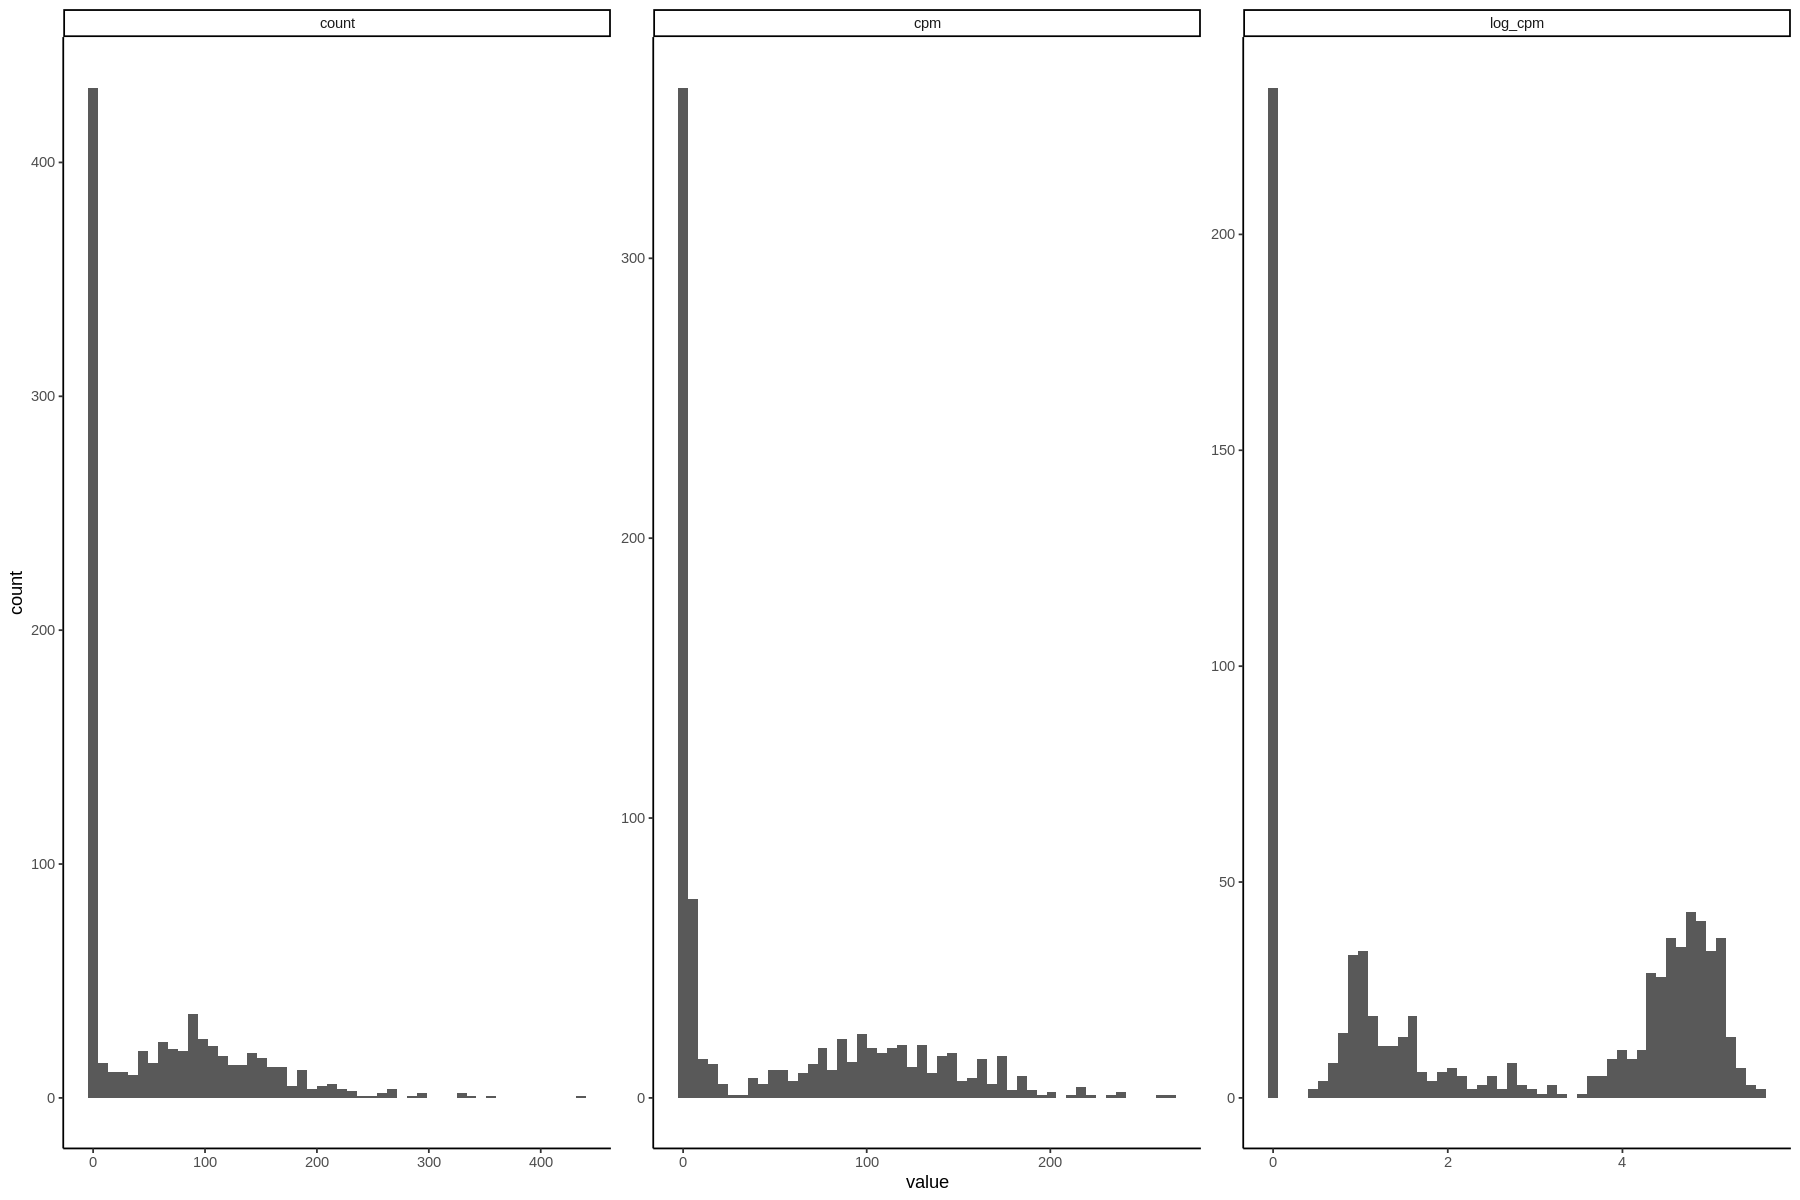

In [40]:
ggplot(df, aes(value)) + geom_histogram(bins = 50) + facet_wrap(~name, ncol=3, scales = "free") + theme_classic()

We can also look at the correlation between the normalized values and the total sequencing depth for each cell

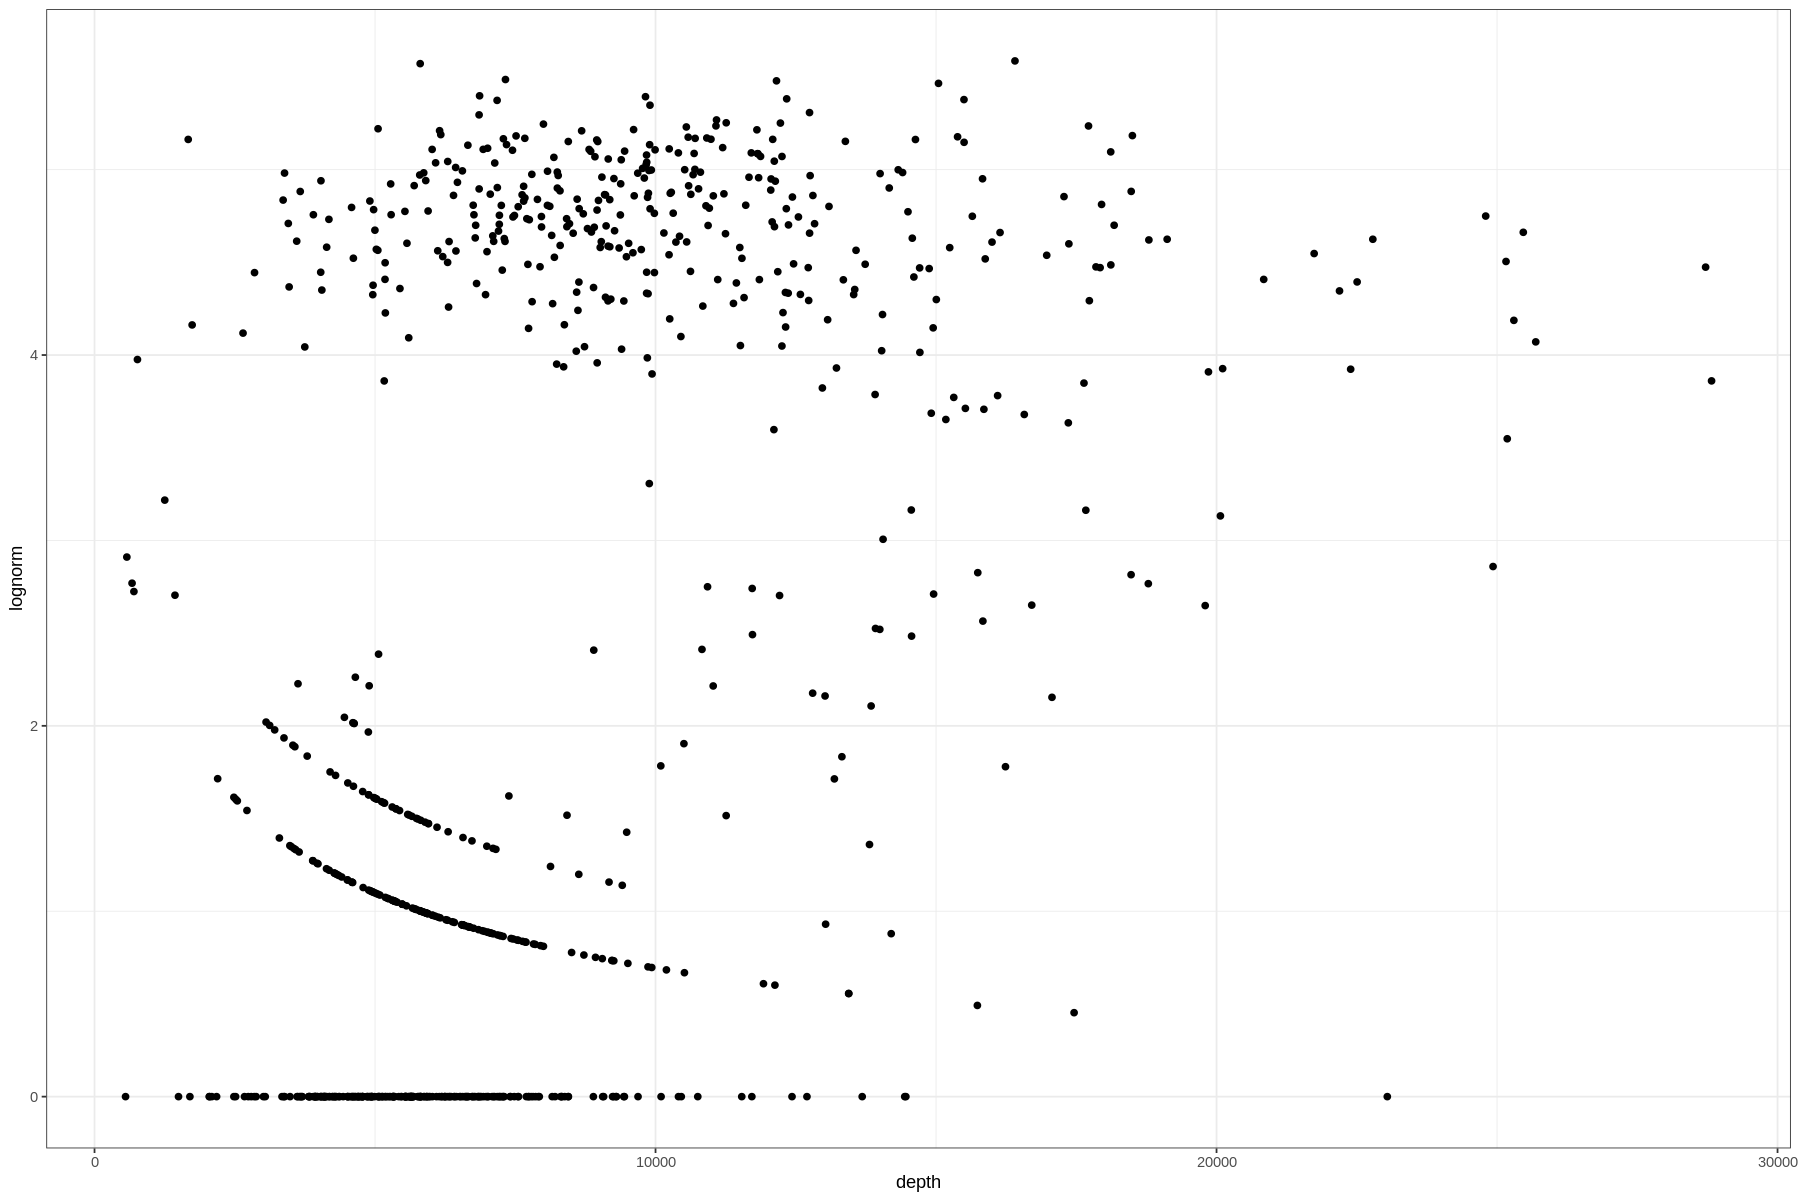

In [41]:
cell.umi.count <- colSums(count.matrix)
log_cpm <- log1p(counts.use / cell.umi.count * 10000)

ggplot(data.frame(depth = cell.umi.count, lognorm = log_cpm), aes(depth, lognorm)) + geom_point() + theme_bw()

As we can see, the correlation between the gene expression value and total sequencing depth for the cell has been reduced by applying the transformation.

We can apply log normalization to the whole dataset using the `NormalizeData()` function:

In [42]:
pbmc <- NormalizeData(pbmc)

### Issues with log normalization

What are some of the problems with using log-normalization for scRNA-seq data?

1. Use of a pseudocount. A pseudocound must be added to avoid log(0). This is arbitrary and impacts the values for lowly expressed genes more than highly expressed genes.
2. It does not fully account for differences in sequencing depth between cells.

To examine the effect of pseudocounts on the mean, lets look at some simulated low and high-expressed genes. We can similate some count data following a Poisson distribution with a given mean using the `rpois` function:

In [43]:
low_gene <- rpois(n = 10000, lambda = 2)
mean(low_gene)

[1] 2.0076

In [44]:
mean(log1p(low_gene))

[1] 0.9787037

In [45]:
log(2)

[1] 0.6931472

In [46]:
high_gene <- rpois(n = 10000, lambda = 1000)
mean(high_gene)

[1] 999.9852

In [47]:
mean(log1p(high_gene))

[1] 6.908221

In [48]:
log(1000)

[1] 6.907755

When the mean expression of a gene is large, `mean(log1p(counts))` $ \approx log(\lambda)$ 

When the mean expression of a gene is small, `log1p(counts)` $ \ne log(\lambda) $

For more discussion of the effect of pseudocounts on data normalization results, see https://pubmed.ncbi.nlm.nih.gov/33676365/

We can also assess the relationship between sequencing depth and normalized values across all variable genes in our dataset:

In [49]:
# get the normalized data
lognorm.counts <- GetAssayData(pbmc, assay = "RNA", slot = "data")

# subset the matrix to only the 2000 variable features
var.gene.matrix <- count.matrix[VariableFeatures(pbmc), ]
var.gene.matrix.lognorm <- lognorm.counts[VariableFeatures(pbmc), ]

# for each gene compute correlation between total UMIs for the cell and expression of the gene
count_cor <- apply(X = var.gene.matrix, MARGIN = 1, FUN = function(x) cor(x, cell.umi.count))
lognorm_cor <- apply(X = var.gene.matrix.lognorm, MARGIN = 1, FUN = function(x) cor(x, cell.umi.count))

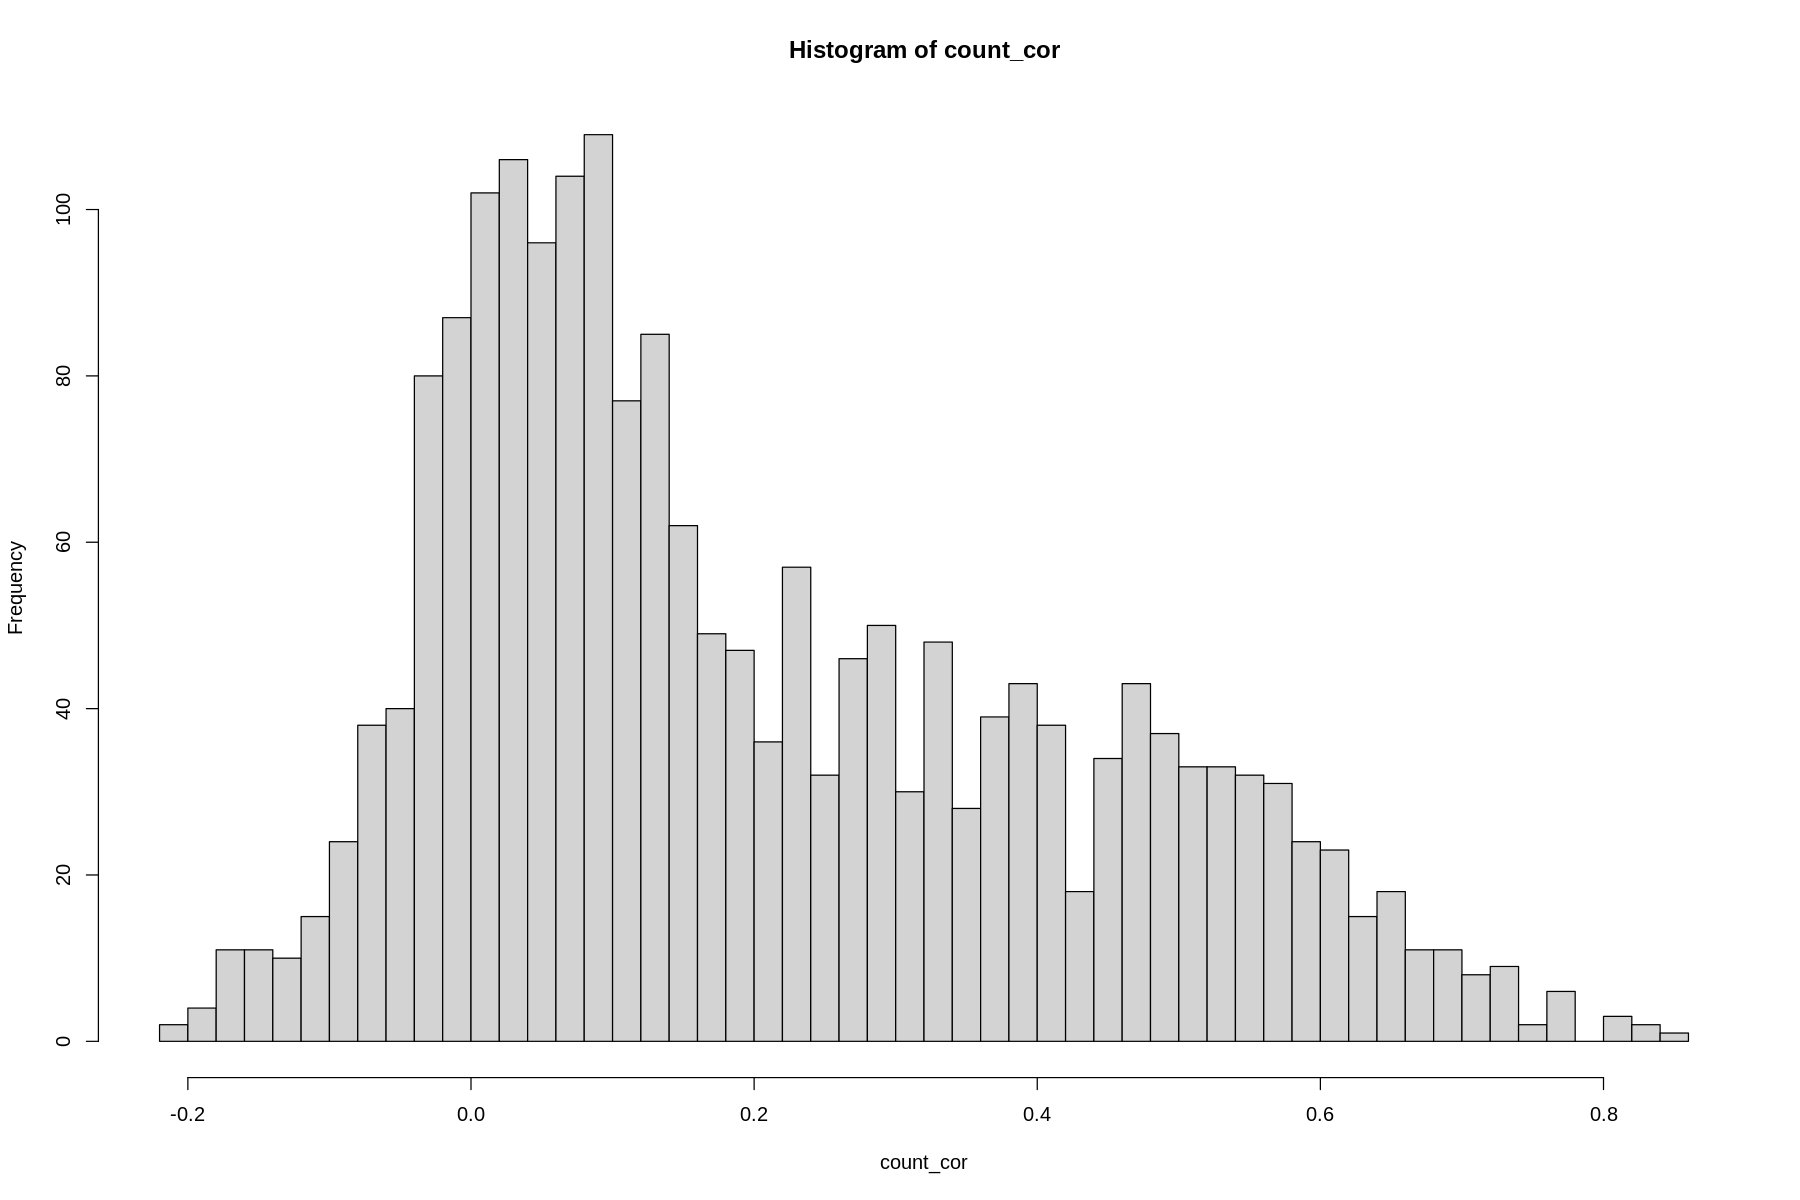

In [50]:
hist(count_cor, 50)

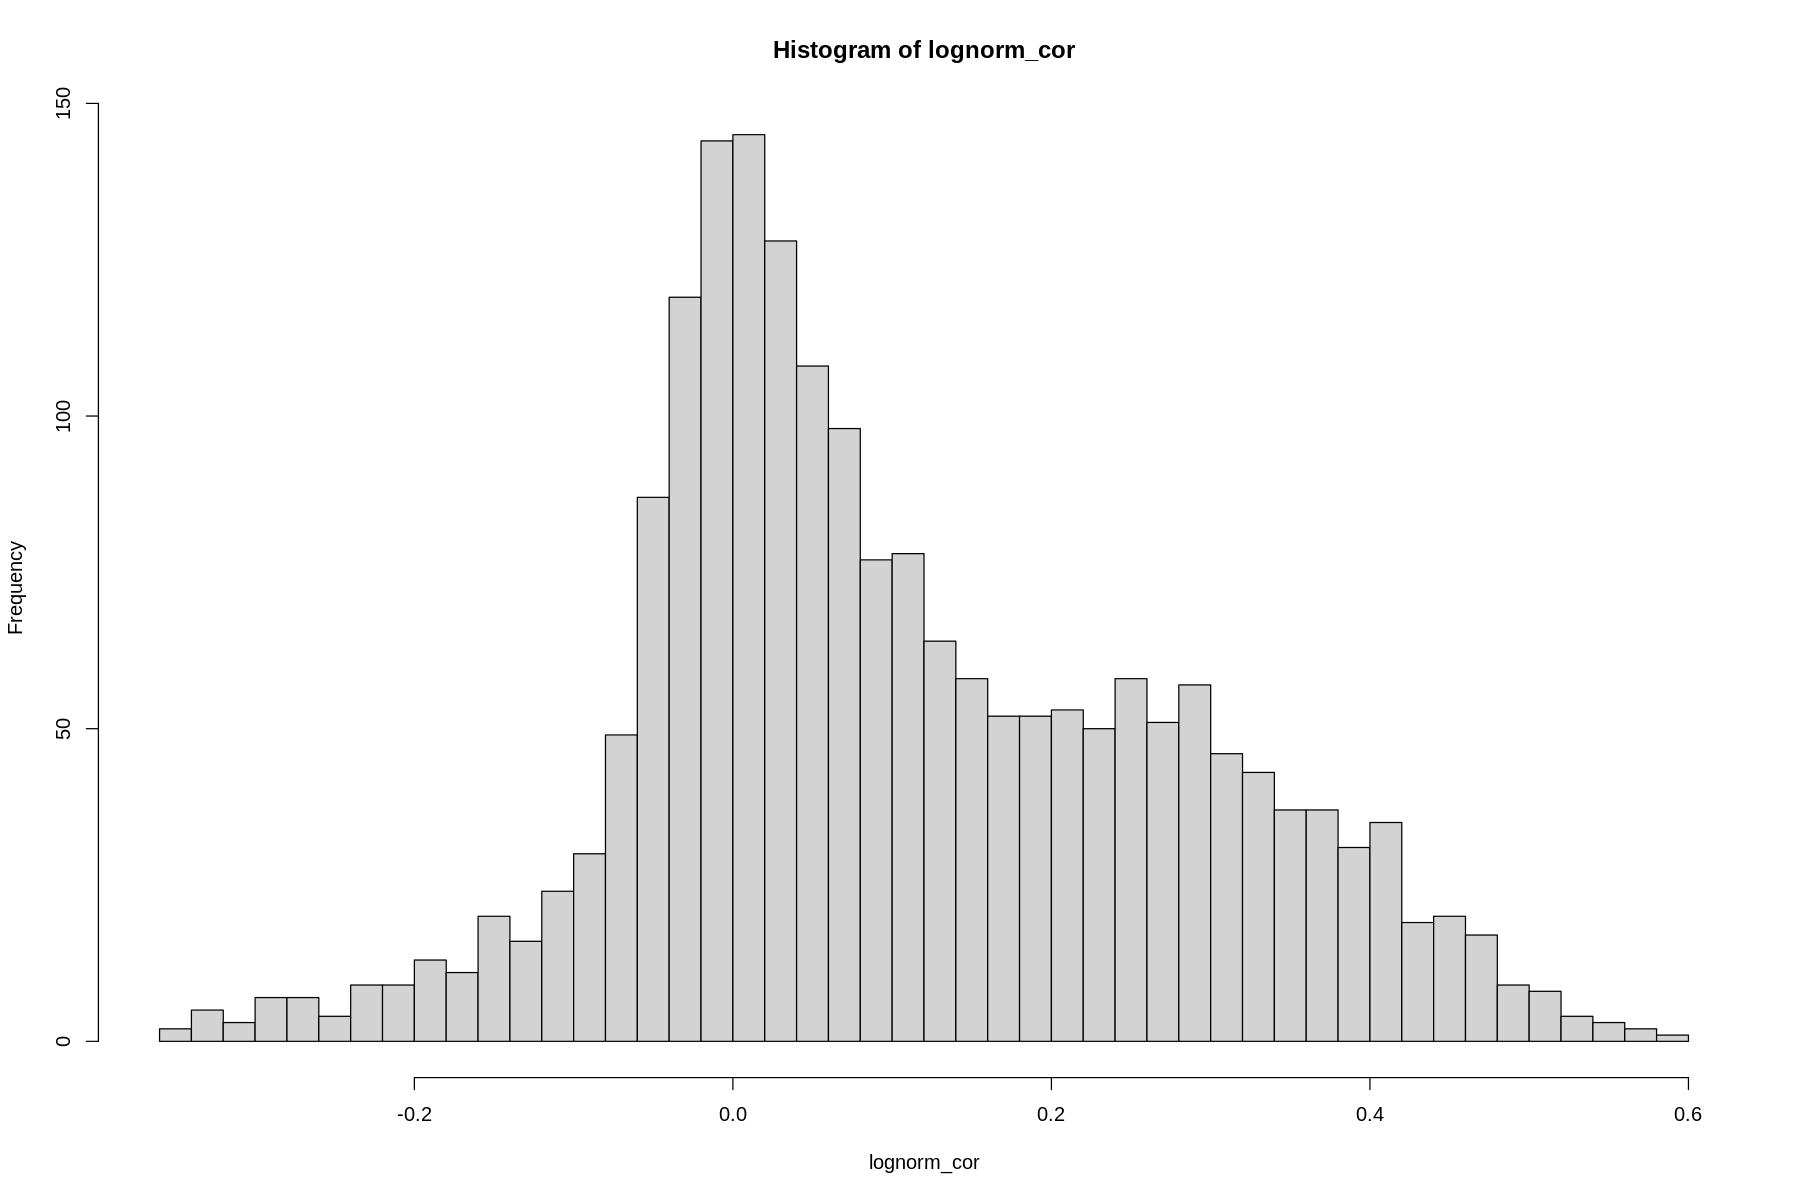

In [51]:
hist(lognorm_cor, 50)

Importantly, the correlation between UMI counts and normalized expression also changes depending on the average expression of the gene. More lowly expressed genes tend to have a lower correlation between depth and expression after log-normalization, while the correlation is not fully removed for more highly expressed genes. This is shown in the SCTransform paper.

We can also see that the relationship between mean and variance has been improved, but not completely solved:

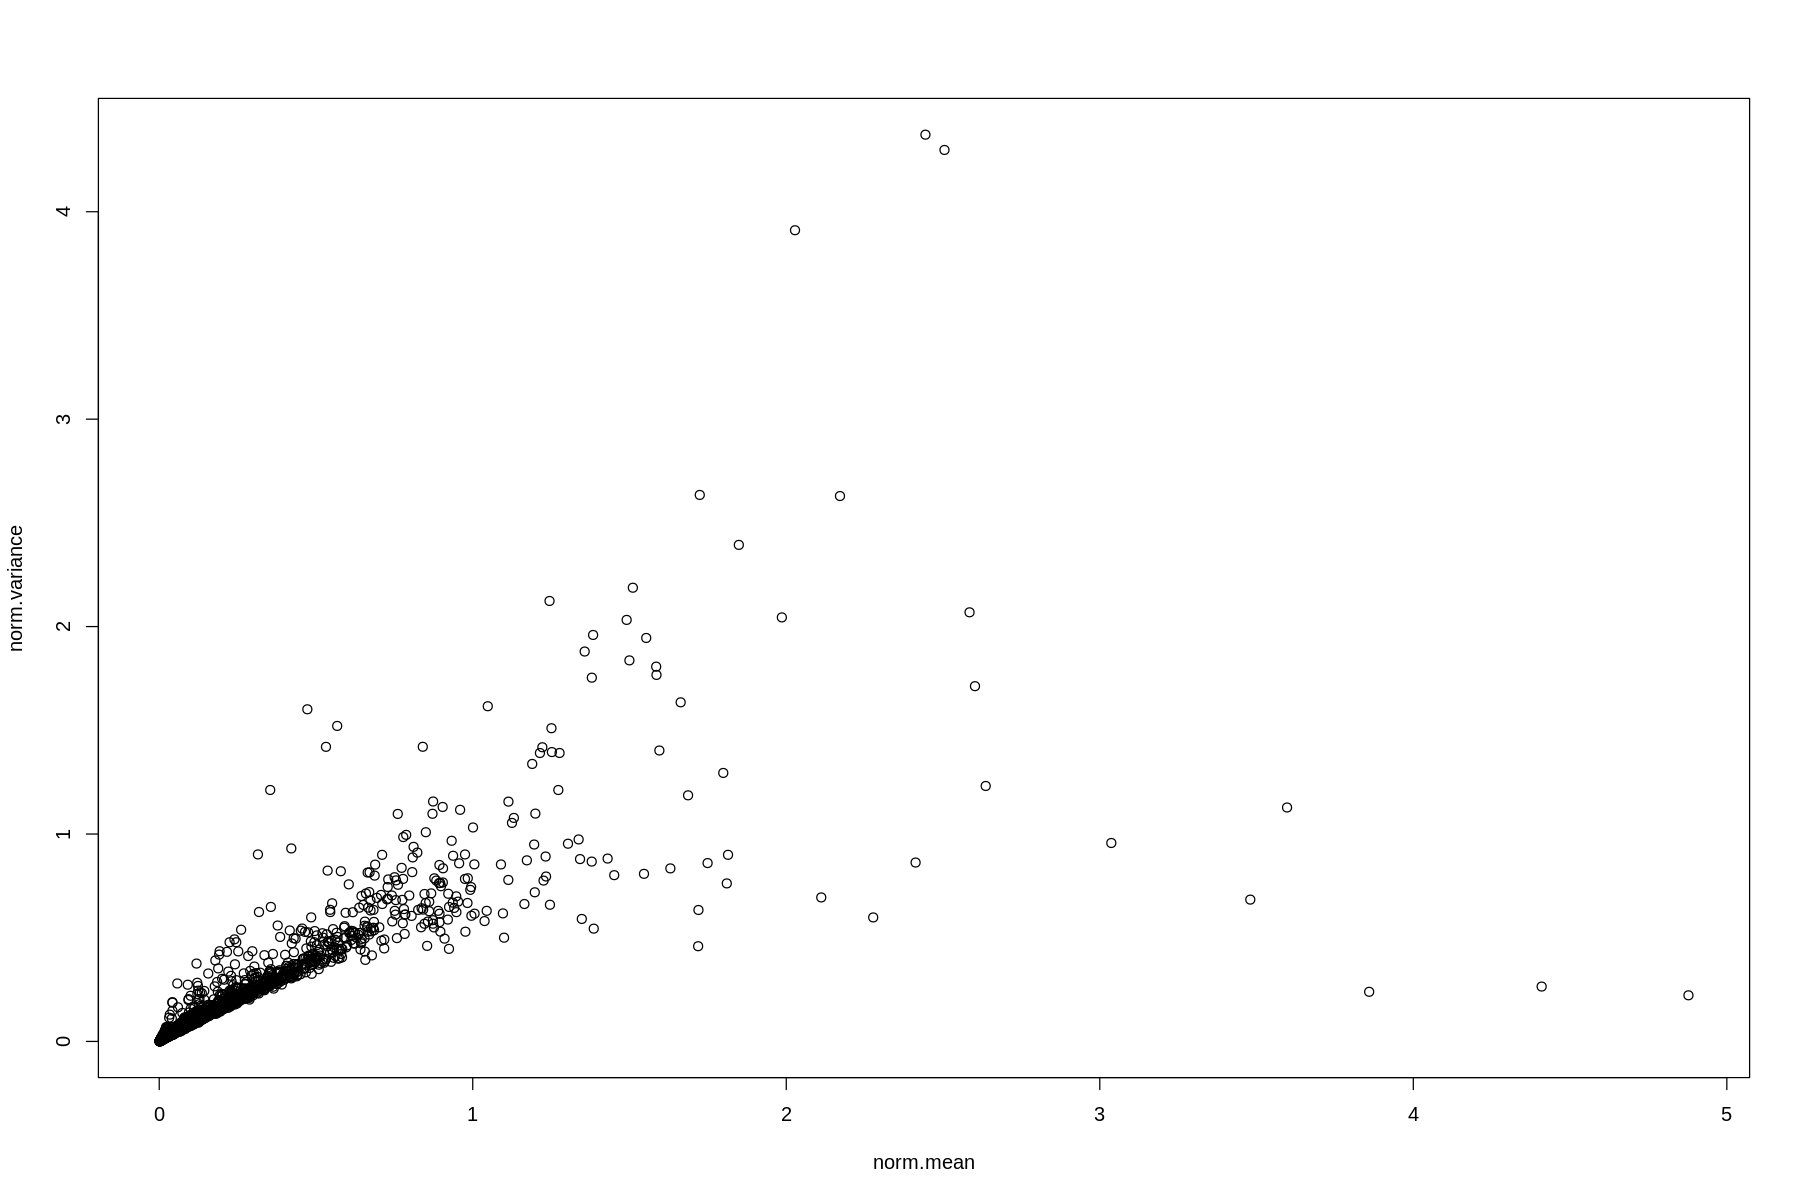

In [52]:
norm.variance <- apply(var.gene.matrix.lognorm, 1, var)
norm.mean <- apply(var.gene.matrix.lognorm, 1, mean)
plot(norm.mean, norm.variance)

### Alternative normalization methods: SCTransform

SCTransform is a more recent data normalization method developed to more effectively account for technical variation (differences in sequencing depth, for example) between cells. The method was published in Genome Biology: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1

SCTransform fits a regularized negative binomial model (a GLM) for each gene with UMI counts for the gene as the response and sequencing depth for the cell as the explanatory variable. Here we can run SCTransform on the dataset and compare results with log-normalization:

In [53]:
# suppress warning since a lot will be printed out
pbmc <- suppressWarnings(SCTransform(pbmc))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13937 by 825

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 825 cells



  |======================================================================| 100%


There are 1 estimated thetas smaller than 1e-07 - will be set to 1e-07

Found 70 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13937 genes



  |======================================================================| 100%


Computing corrected count matrix for 13937 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 13.90663 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



In [54]:
# we now have a new assay, SCT
pbmc

An object of class Seurat 
50548 features across 825 samples within 3 assays 
Active assay: SCT (13937 features, 3000 variable features)
 2 other assays present: RNA, ADT

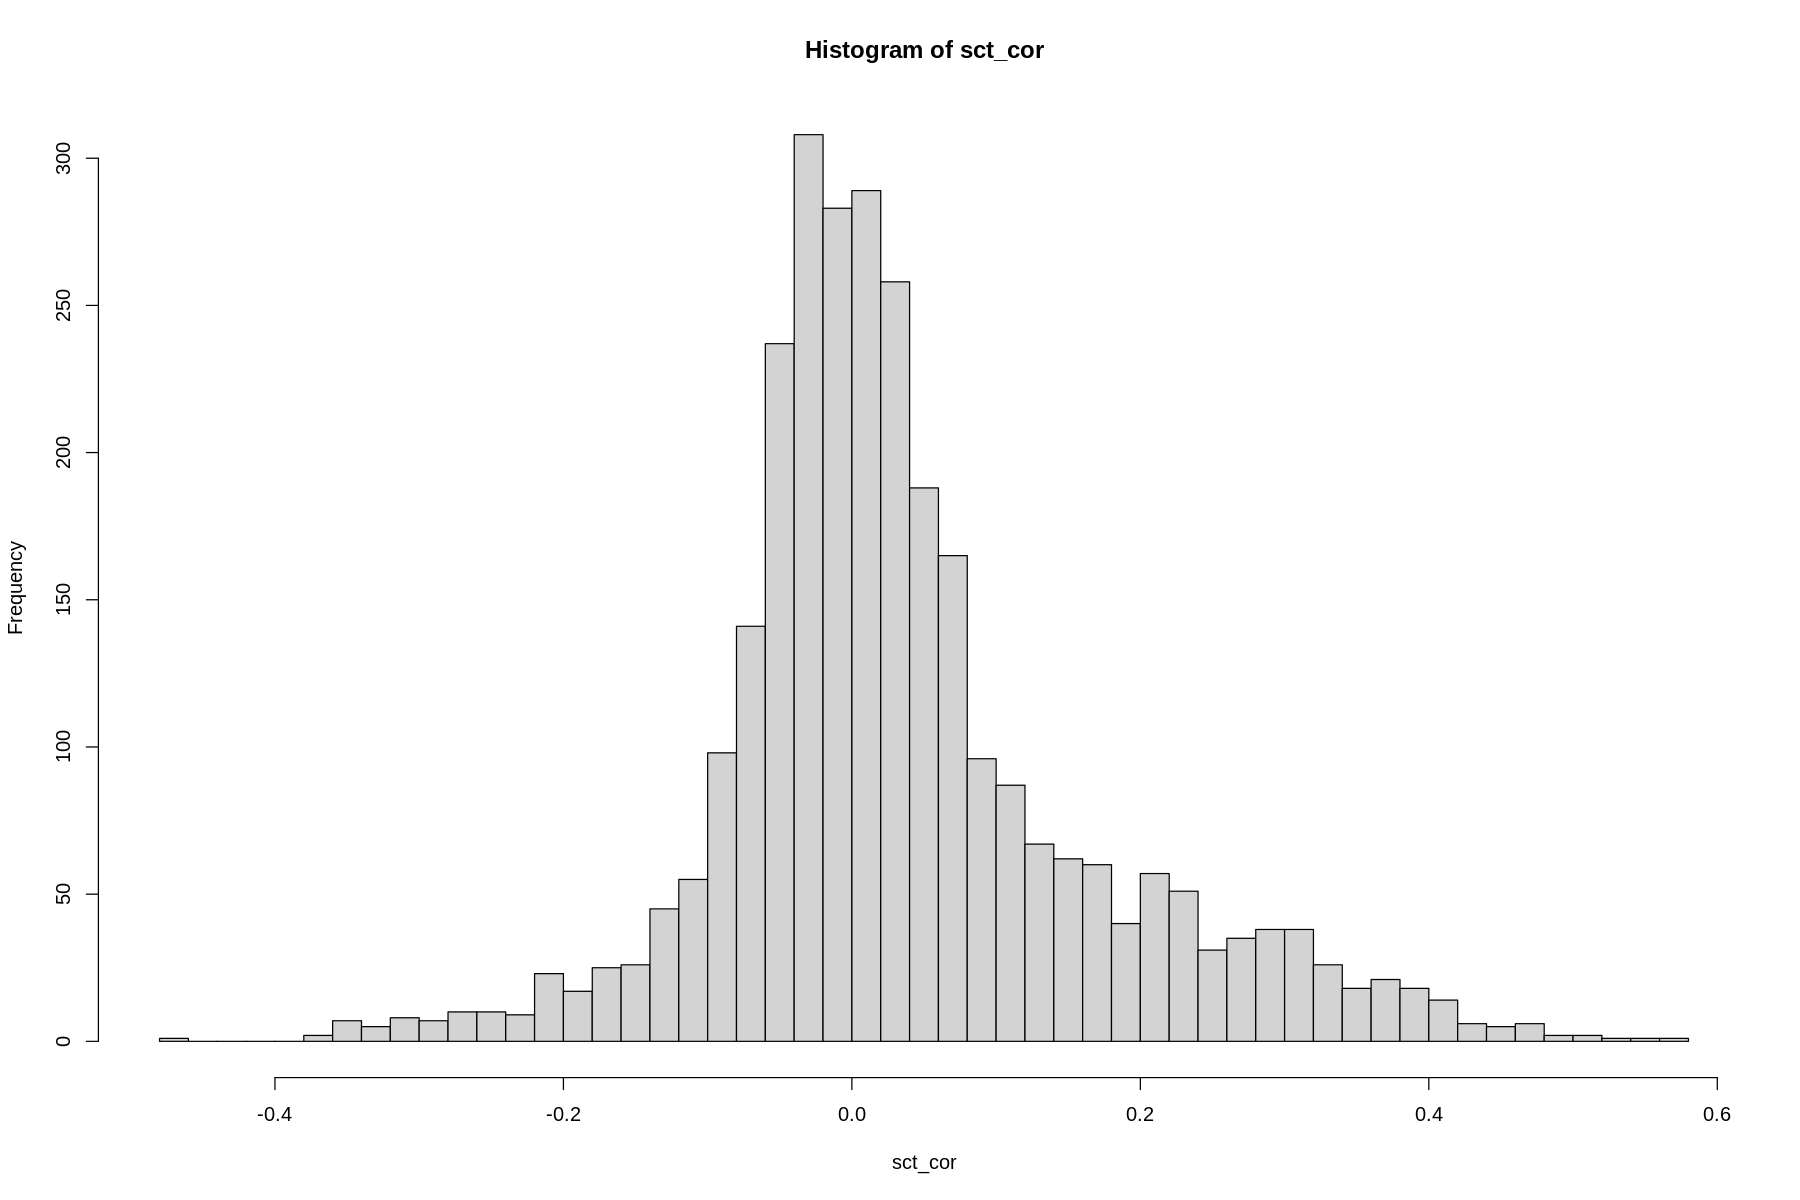

In [55]:
sct.counts <- GetAssayData(pbmc, assay = "SCT", slot = "data")[VariableFeatures(pbmc), ]
sct_cor <- apply(X = sct.counts, MARGIN = 1, FUN = function(x) cor(x, cell.umi.count))
hist(sct_cor, 50)

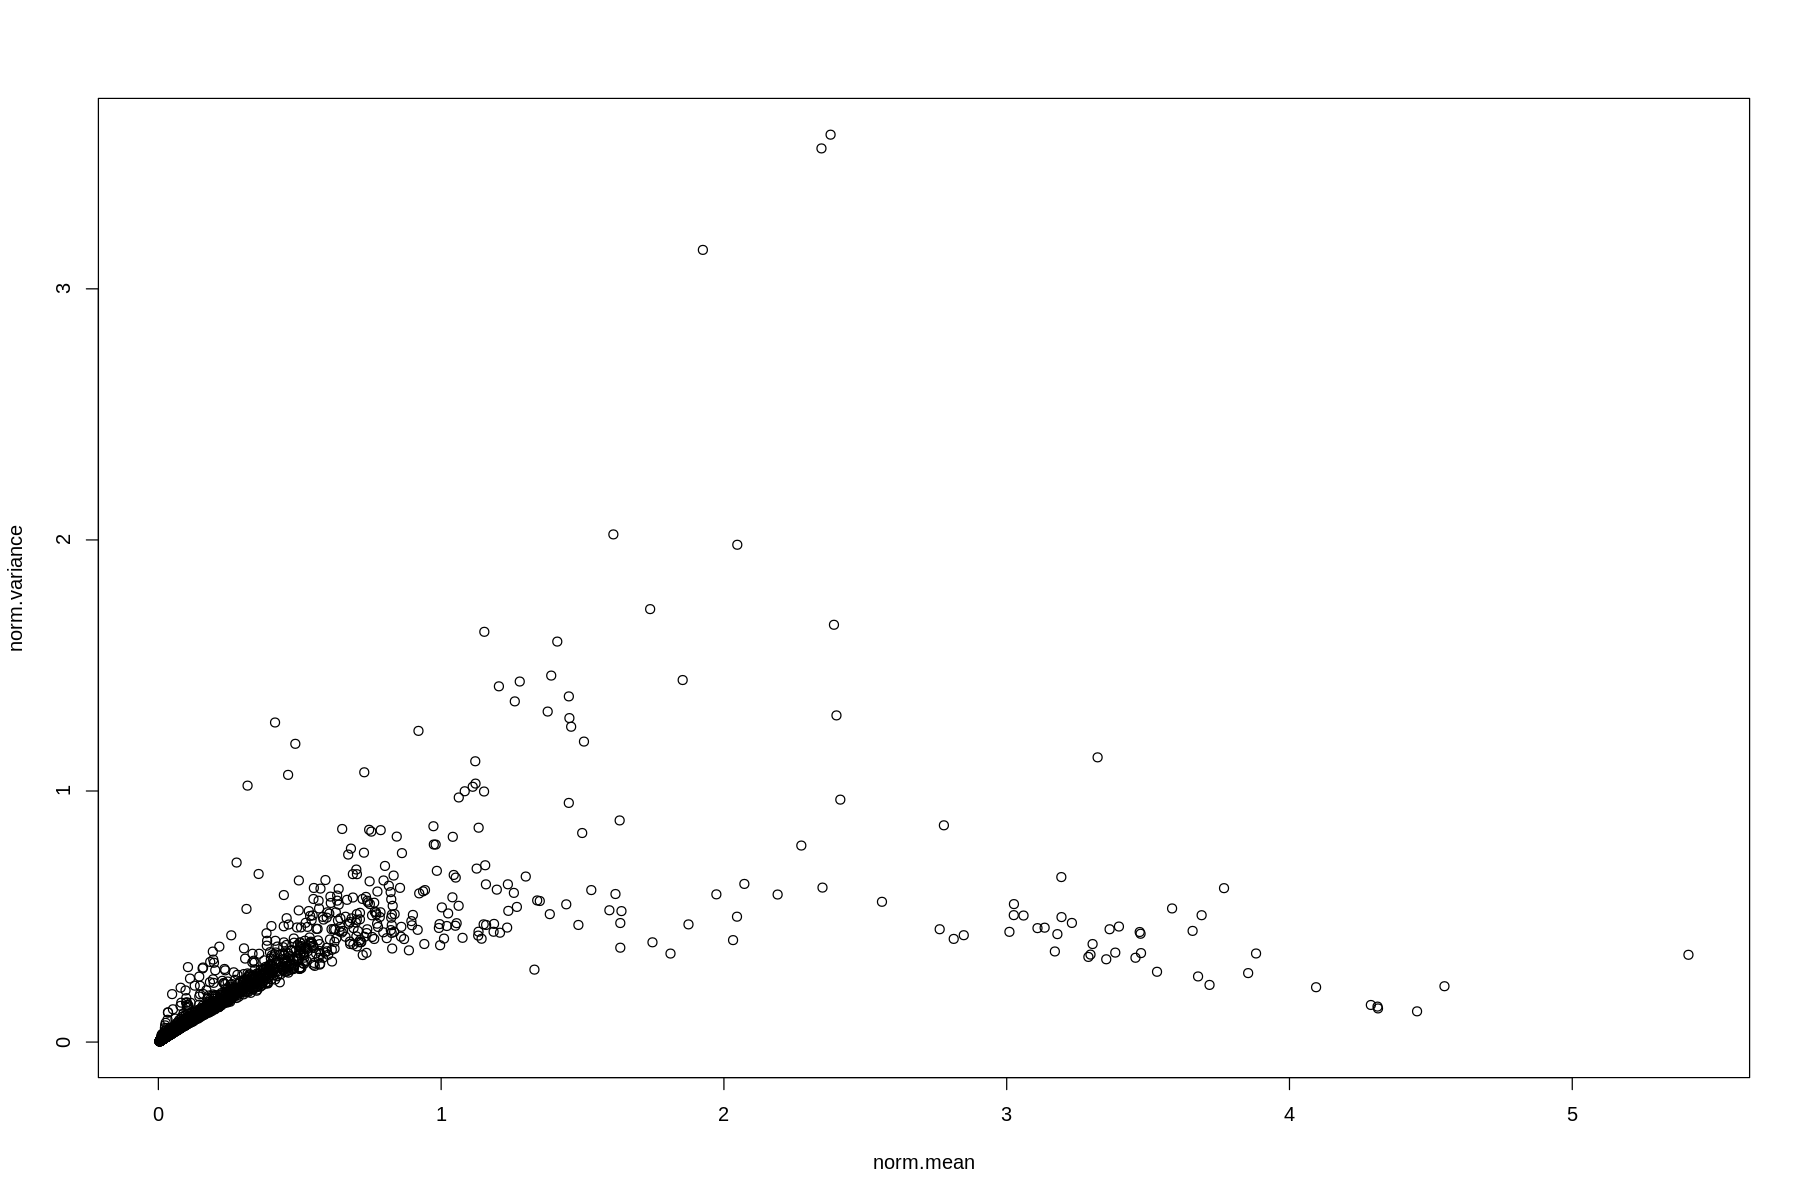

In [56]:
norm.variance <- apply(sct.counts, 1, var)
norm.mean <- apply(sct.counts, 1, mean)
plot(norm.mean, norm.variance)

As we can see, SCTransform has done a better job here in correcting for differences in sequencing depth and accounting for the mean-variance relationship.

More examples showing how to use SCTransform are available on the Seurat website: https://satijalab.org/seurat/articles/sctransform_vignette.html

Other similar approaches have been developed for normalizing scRNA-seq data, including GLM-PCA: https://github.com/willtownes/glmpca/, https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6

## Normalizing the protein data

Protein (CITE-seq) data follows a very different distribution to the scRNA-seq counts, and has some different challenges when aiming to normalize the counts. One issue unique to the protein data is the presence of background counts, which may result from non-specific antibody binding or background antibody oligos being present in the experiment.

We typically apply a centered log ratio (CLR) normalization to the ADT data. The CLR transformation a method designed for compositional data, and is better suited when we have few features being measured (in this case we have 9 proteins). In this case, the 

The CLR transformation is given as:

$ clr(x) = [ln(x_1/g(x)) , ... , ln(x_n/g(x)) ] $

where $x_i$ is the ADT counts for gene $i$ and $ g(x) $ is the geometric mean of $x$

In [57]:
# change to the ADT assay containing the protein measurements
DefaultAssay(pbmc) <- "ADT"

# apply CLR transformation
pbmc <- NormalizeData(pbmc, normalization.method = "CLR")

Normalizing across features



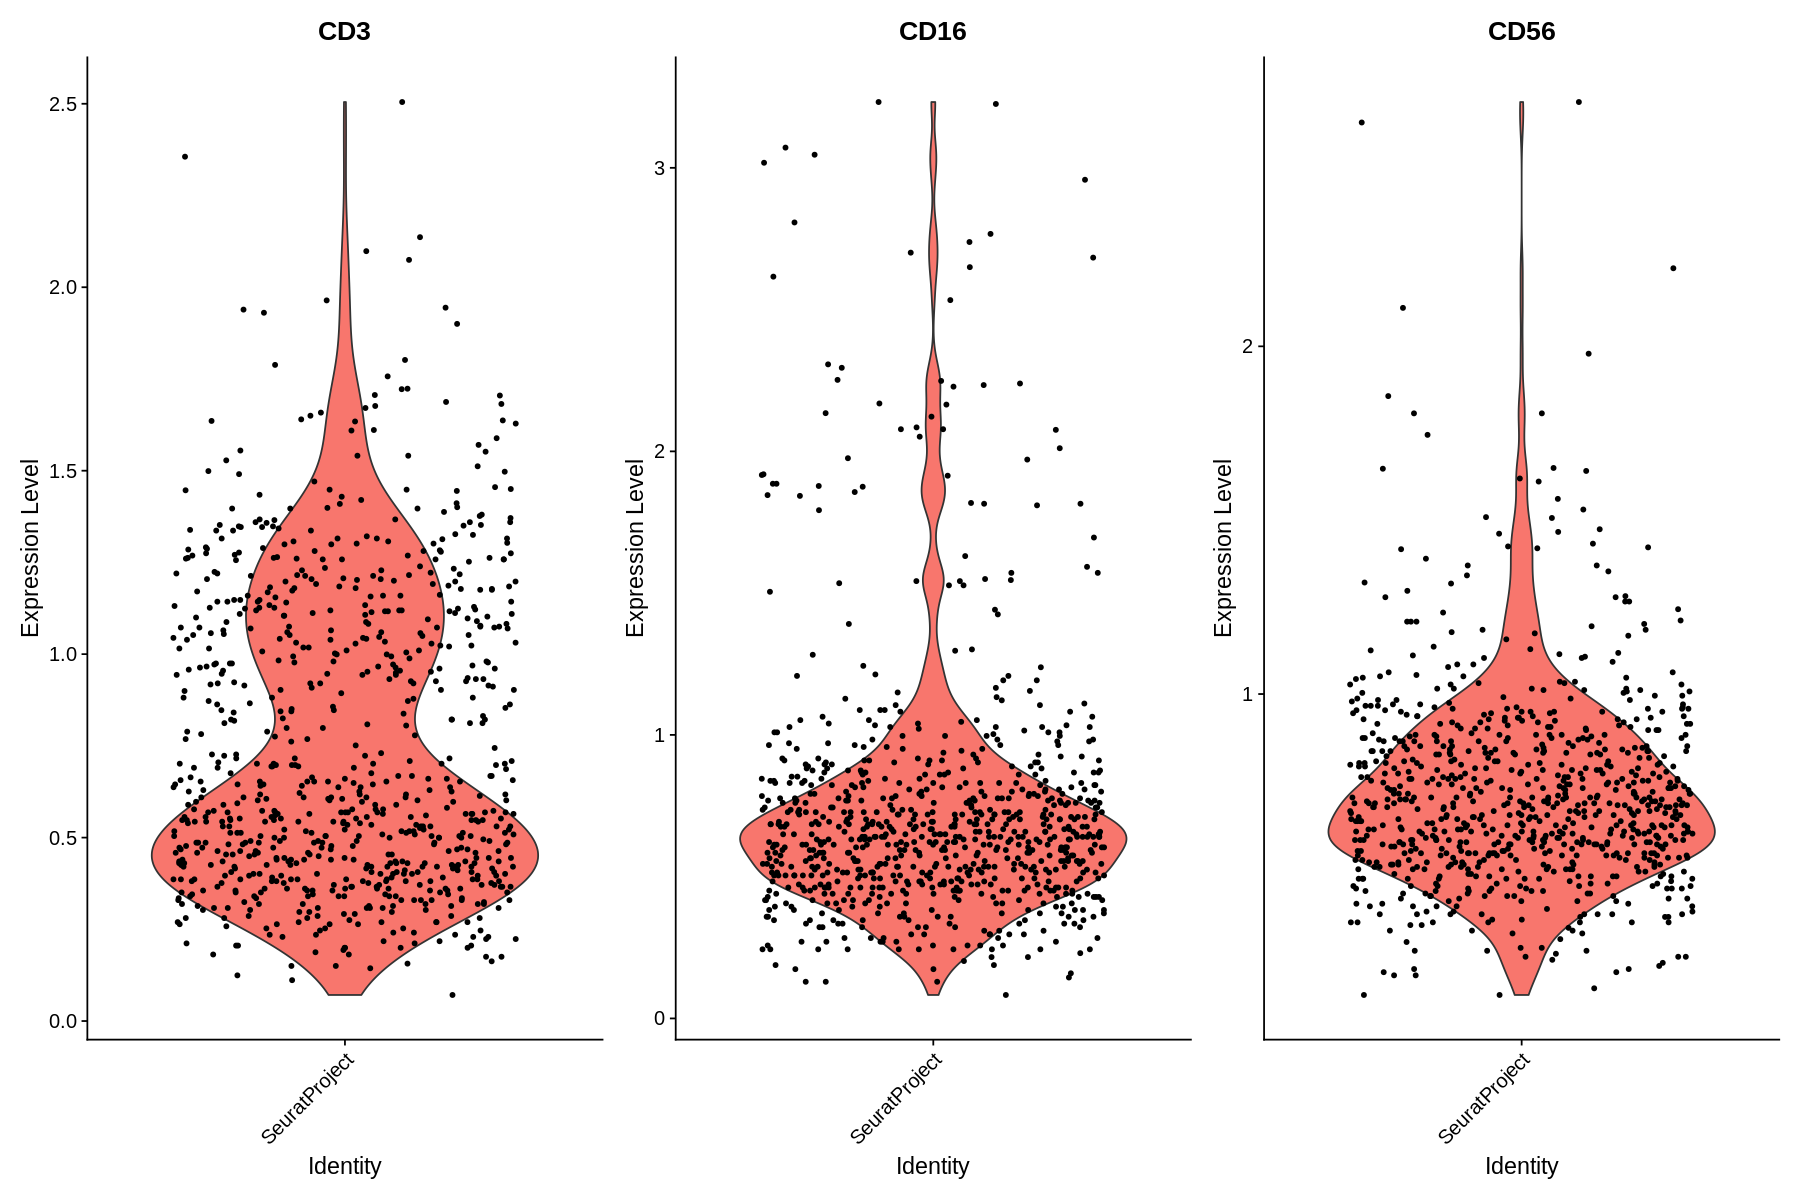

In [58]:
# take a look at some of the proteins
VlnPlot(pbmc, c("CD3", "CD16", "CD56"))

## Dimension reduction

Our scRNA-seq dataset contains measurements for every gene in the genome. The "intrinsic" dimensionality of the data is much lower than the ~20,000 dimensions that we have when looking at the expression of each gene, as there is extensive correlation structure in the dataset. Many groups of genes will be co-expressed in similar patterns. We can therefore find a set of low-dimensional vectors that capture most of the variation present in the dataset. Using a set of low-dimension cell embeddings will make downstream analysis tasks like clustering much easier, as we can focus on the biological heterogenetiy in the dataset.

There are several methods that are commonly applied for dimension reduction of scRNA-seq data. Here, we'll use Principal Component Analysis (PCA), which aims to find a new set of vectors that explain most of the variance in the dataset. PCA assumes the data are normally distributed, so we will need to make some more adjustments to our normalized data before running PCA. We will center the data for each gene (subtract the mean so that the mean=0) and divide by the standard deviation (so SD=1).

For simplicity, we'll proceed using the log-normalized data here. Feel free to run the following steps using data normalized using SCTransform or [GLM-PCA](http://htmlpreview.github.io/?https://github.com/satijalab/seurat-wrappers/blob/master/docs/glmpca.html) and see how the results look.

In [59]:
# change back to the RNA assay
DefaultAssay(pbmc) <- "RNA"

# scale and center normalized gene expression data
pbmc <- ScaleData(pbmc)

pbmc <- RunPCA(pbmc)

Centering and scaling data matrix

PC_ 1 
Positive:  LTB, CD3D, IL32, CD3E, PCED1B-AS1, ETS1, CD3G, TRAC, TRBC2, IL7R 
	   ARL4C, BCL11B, LIME1, CD2, PRKCQ-AS1, LINC00861, TCF7, STK17A, FCMR, TRBC1 
	   CD7, GZMM, CD247, CCR7, SKAP1, CD27, SLC38A1, BCL2, LEF1, SYNE2 
Negative:  FGL2, FCN1, CTSS, LYZ, PSAP, CYBB, TYMP, MNDA, CST3, NCF2 
	   IFI30, MPEG1, SERPINA1, AIF1, LST1, S100A9, TYROBP, TMEM176B, GRN, DUSP6 
	   TNFSF13B, DUSP1, MS4A6A, FTL, COTL1, FOS, CD36, CD68, IGSF6, TNFAIP2 
PC_ 2 
Positive:  CD79A, MS4A1, IGHM, BANK1, RALGPS2, TNFRSF13C, CD79B, IGKC, LINC00926, NIBAN3 
	   IGHD, SPIB, LINC02397, AFF3, CD22, VPREB3, HLA-DQA1, BLK, PAX5, BCL11A 
	   HLA-DRA, HLA-DOB, TSPAN13, COBLL1, BLNK, JCHAIN, FCER2, CD24, TCL1A, FCRL1 
Negative:  GZMA, GZMM, IL32, CST7, NKG7, CTSW, KLRD1, PRF1, CCL5, GNLY 
	   CD3D, CD247, KLRK1, S100A4, CD3E, CD2, ANXA1, FGFBP2, CD3G, HOPX 
	   CCL4, SAMD3, IL2RB, FYB1, CD7, KLRG1, KLRB1, LAIR2, ADGRG1, GZMH 
PC_ 3 
Positive:  GZMB, FCGR3A, NKG7, GNLY, K

We can now see that we have a new dimension reduction added to our Seurat object, containing the results of the PCA:

In [60]:
pbmc

An object of class Seurat 
50548 features across 825 samples within 3 assays 
Active assay: RNA (36601 features, 2000 variable features)
 2 other assays present: ADT, SCT
 1 dimensional reduction calculated: pca

In [61]:
pbmc[['pca']]

PC_ 1 
Positive:  LTB, CD3D, IL32, CD3E, PCED1B-AS1, ETS1, CD3G, TRAC, TRBC2, IL7R 
	   ARL4C, BCL11B, LIME1, CD2, PRKCQ-AS1, LINC00861, TCF7, STK17A, FCMR, TRBC1 
Negative:  FGL2, FCN1, CTSS, LYZ, PSAP, CYBB, TYMP, MNDA, CST3, NCF2 
	   IFI30, MPEG1, SERPINA1, AIF1, LST1, S100A9, TYROBP, TMEM176B, GRN, DUSP6 
PC_ 2 
Positive:  CD79A, MS4A1, IGHM, BANK1, RALGPS2, TNFRSF13C, CD79B, IGKC, LINC00926, NIBAN3 
	   IGHD, SPIB, LINC02397, AFF3, CD22, VPREB3, HLA-DQA1, BLK, PAX5, BCL11A 
Negative:  GZMA, GZMM, IL32, CST7, NKG7, CTSW, KLRD1, PRF1, CCL5, GNLY 
	   CD3D, CD247, KLRK1, S100A4, CD3E, CD2, ANXA1, FGFBP2, CD3G, HOPX 
PC_ 3 
Positive:  GZMB, FCGR3A, NKG7, GNLY, KLRD1, CST7, PRF1, FGFBP2, CLIC3, GZMA 
	   CCL4, HOPX, KLRF1, ADGRG1, SPON2, GZMH, CTSC, C12orf75, IL2RB, CD160 
Negative:  IL7R, S100A12, CCR7, LEF1, PIK3IP1, TCF7, IL6ST, MAL, SLC2A3, VCAN 
	   NOSIP, S100A8, PADI4, CD14, LTB, OXNAD1, CYP1B1, VNN2, NFE2, PRKCQ-AS1 
PC_ 4 
Positive:  TUBB1, CAVIN2, GNG11, PF4, GP1BB, PPBP, CM

## Determining the dimensionality of the dataset

Next, we need to decide how many PCs we want to include in our downstream analysis. PCs are ordered by the amount of variance they explain in the original dataset. Our first instinct might be to include all the PCs, since that would contain all the information present in our dataset. However, some of the variation in the dataset will originate from aspects that we are not interested in: noise or technical variation. These are typically captured in lower PCs assuming the major sources of variation in the dataset originate from the biology. We can avoid including these PCs by selecting the first $n$ PCs that explain most of the variance.

We've already seen above that when we run PCA, the top genes that contribute most to each PC are printed out by Seurat. Looking at these genes can be one way of getting an idea of what aspects of the dataset are being captured by each PC if we are familiar with the key marker genes in the tissue we're profiling. Here, CD3D, IL32, and IL7R are contributing to PC1 and are key T-cell markers.

Another way to determine which PCs to include is to look at the singular values for each PC (related to the amount of variance explained by each PC). We can do this using the `ElbowPlot()` function:

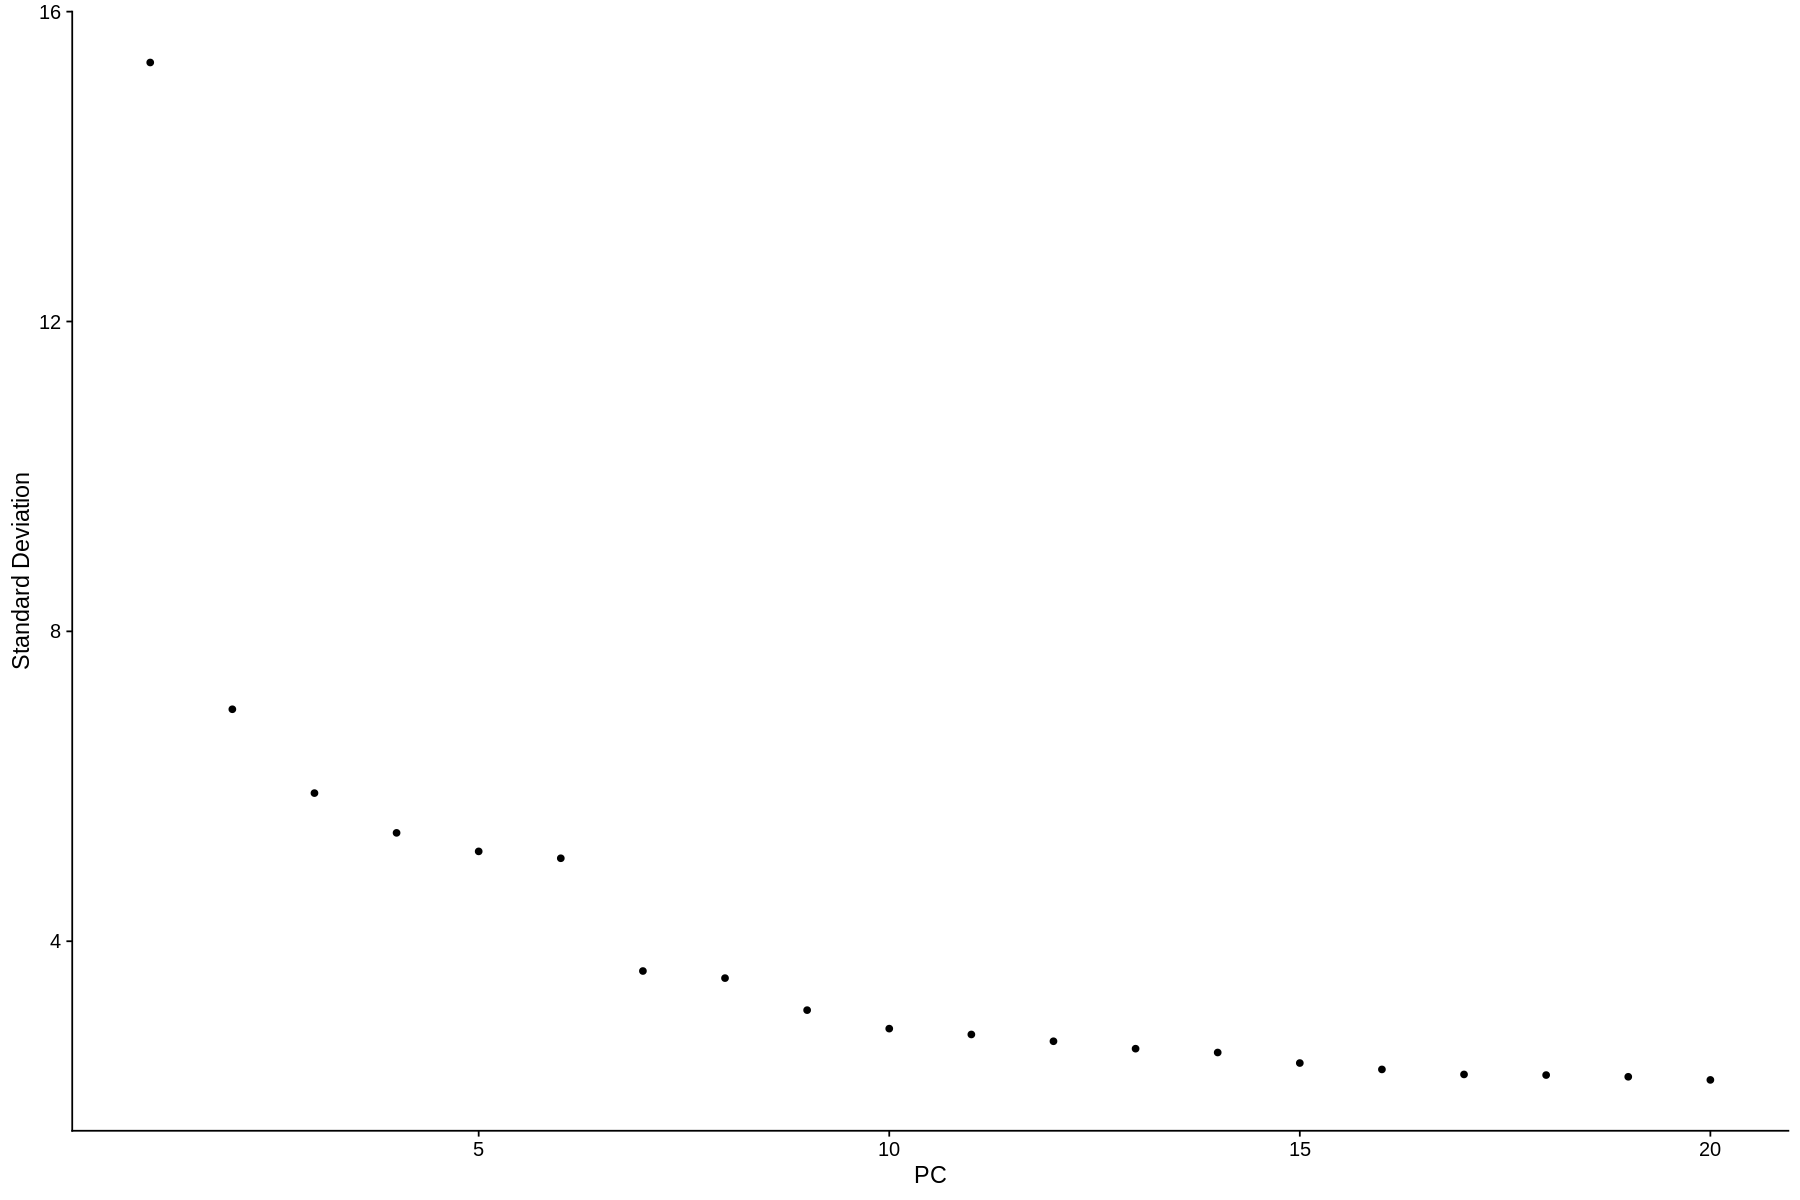

In [62]:
ElbowPlot(pbmc)

Here we see the amount of variance explained starts to flatten off at 15 or 20 PCs.

It's often useful to vary the number of components used and see how downstream results (clustering, UMAP) change, to try to find an ideal parameter.

## Projecting into two dimensions

To visualize our dataset, we want to project the cells further from 20 PCs down to two dimensions that can be shown on a page. Again, many different methods have been developed to do this, most notably tSNE and UMAP. The basic goal of each method is to **find a set of 2-dimensional coordinates for the datapoints that minimizes the difference in cell-cell similarities between the high and low-dimensional space**.

### Overview of tSNE algorithm

t-distributed stochastic neighbor embedding (tSNE) was developed back in 2008 by Laurens van der Maaten and Geoffey Hinton (one of the founders of the field of deep learning).

Let's take a quick, high-level look at how tSNE works.

1. Compute cell-cell similarities in high-dimensional (PC) space.
2. Convert similarities to transition probabilities (sum to 1)
3. Initialize points in 2D space (random initialization, or can use PCs)
4. Compute cell-cell similarities and transition probabilities in the low-dimensional space
5. Move points in the low-dimensional space to minimize the difference between cell-cell transition probabilities in high vs low dimensional space (KL divergence)

The key point is that cells will have attraction and repulsion forces in the low-dimensional space based on their distance in the high dimensional space. This causes points to eventually converge on positions in 2D that provide good representation of the cell-cell distance in higher dimensions.

If you're interested in learning all the details about how these methods work, I'd recommend starting with the tSNE paper which is very well-written and accessible: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

More recently, the field has adopted UMAP as a data visualization method rather than tSNE. The method and concept is similar to tSNE (and you can [even](https://arxiv.org/abs/2007.08902) [tune](https://doi.org/10.1038/s41587-020-00809-z) the tSNE parameters to get a result similar to UMAP).

While we've just explained how tSNE works, we'll use UMAP here, keeping in mind that the key concepts are the same. Feel free to explore running tSNE as well as changing parameters in the algorithm and see how the results change.

In [63]:
pbmc <- RunUMAP(pbmc, reduction = 'pca', dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
01:16:35 UMAP embedding parameters a = 0.9922 b = 1.112

01:16:35 Read 825 rows and found 20 numeric columns

01:16:35 Using Annoy for neighbor search, n_neighbors = 30

01:16:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:16:35 Writing NN index file to temp file /tmp/RtmpPq2biq/file51636f066cdb

01:16:35 Searching Annoy index using 1 thread, search_k = 3000

01:16:35 Annoy recall = 100%

01:16:35 Commencing smooth kNN distance calibration using 1 thread

01:16:36 Initializing from

In [64]:
pbmc

An object of class Seurat 
50548 features across 825 samples within 3 assays 
Active assay: RNA (36601 features, 2000 variable features)
 2 other assays present: ADT, SCT
 2 dimensional reductions calculated: pca, umap

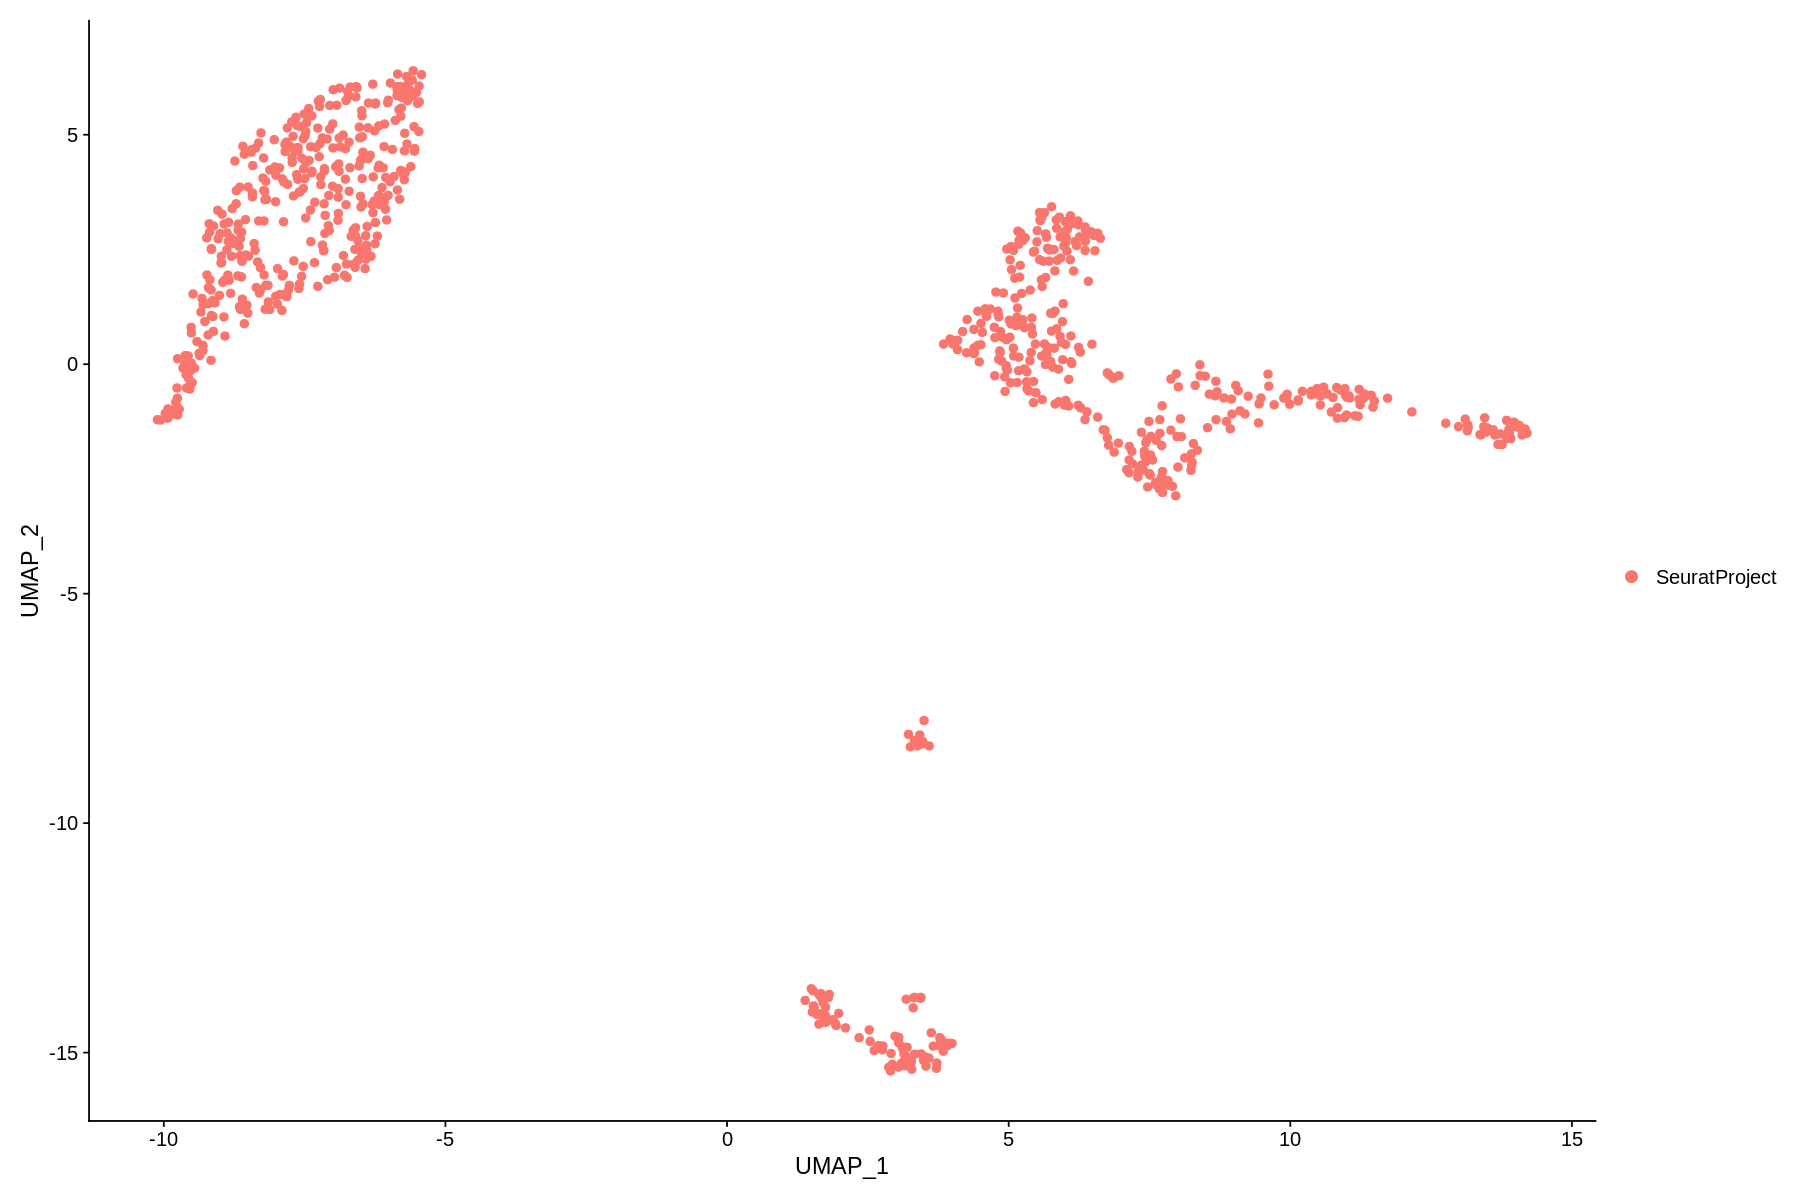

In [65]:
DimPlot(pbmc, reduction = 'umap', pt.size = 2)

Now, finally, we see our cells!

If you're familar with these datasets you can probably recognize different shapes and may even be able to guess which cells belong to which cell types. We now visualize our gene or protein expression data for each cell in this 2D space to help interpret the cells. Let's plot the expression of each of the 9 proteins:

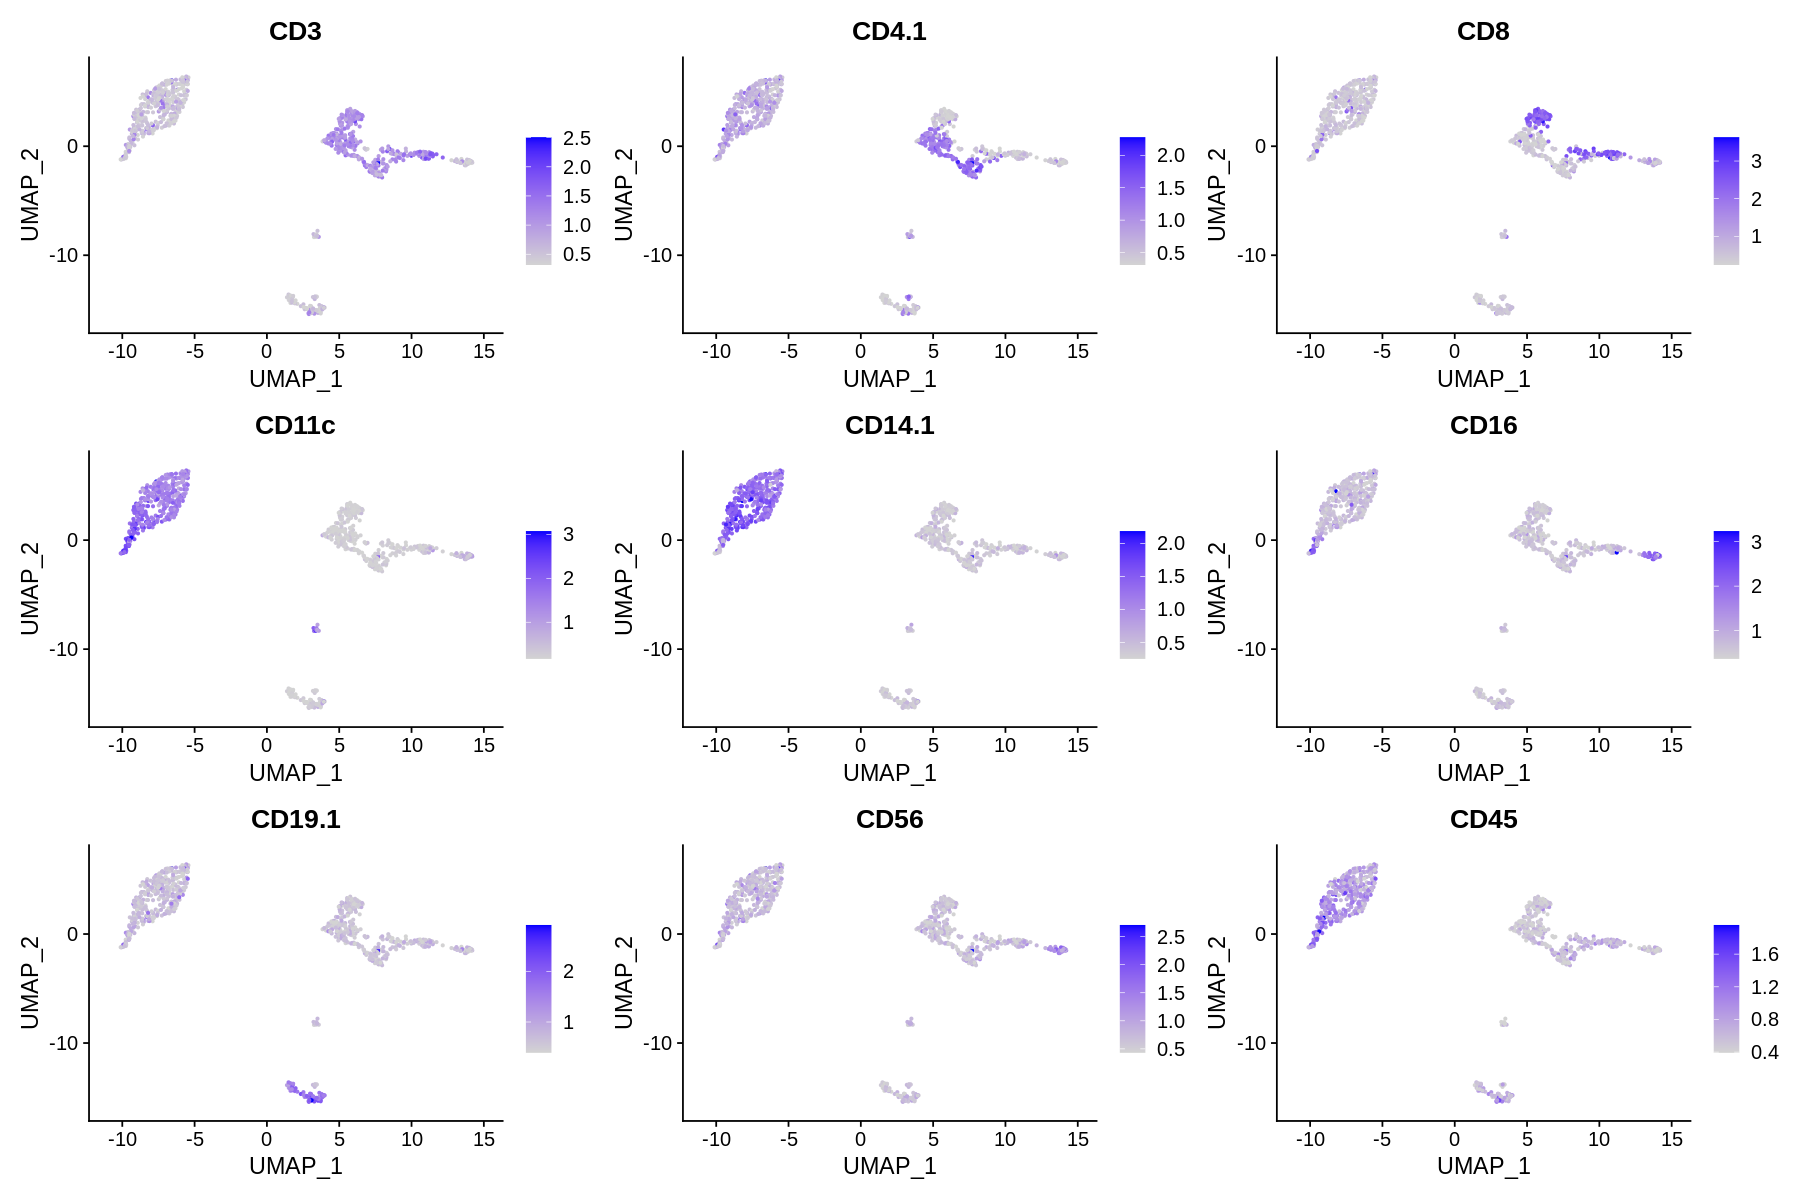

In [66]:
DefaultAssay(pbmc) <- "ADT"
FeaturePlot(pbmc, features = rownames(pbmc)[1:9], pt.size = 0.5, min.cutoff = "q10")

Now we can start to make sense of the data: we see that cells in the top right are likely T cells (we can see the CD4+ and CD8+ cells), with NK cells expressing CD16 branching off the T cell cluster.

## Clustering

We can find groups of similar cells (clusters) in the dataset now that we've projected the cells into a low-dimension space. Graph-based clustering methods are often used in single-cell analysis as they scale to datasets containing >1M cells and generally give good results. Graph-based clustering methods involve the construction of a neighbor graph (describing which cells are nearest neighbors in a space), followed by optimizing an objective function that measures how well a set of partitions in the graph (clusters) captures the graph structure.

For this, we need two things: a metric that measures how well partitions "capture the graph structure," and an algorithm that is able to optimize this metric by changing how the cells are partitioned.

### Modularity

For each community (graph partition), [modularity](https://en.wikipedia.org/wiki/Modularity_(networks)) measures the number of edges within the community and the number of edges going outside the community, and gives a value between -1 and +1. Modularity scores of +1 mean that all the edges in a community are connecting nodes within the community. A score of 0 would mean that the community has half its edges connecting nodes within the same community, and half connecting nodes outside the community. A score of -1 means that there are no edges connecting nodes within the community, and they instead all connect nodes outside the community. Modularity is a popular objective function for community detection. Other objective functions exist, such as the Constant Potts Model which tries to maximize the number of internal edges in a community, while simultaneously trying to keep community sizes small.

### The Louvain algorithm for community detection

As the problem of modularity optimization is NP-hard (ie, we can't test every possible graph partition), we need heuristic methods to optimize graph modularity. The Louvain algorithm is a simple and popular method for community detection. Louvain has two phases: local moving and aggregation.

The Louvain **local moving** phase consists of the following steps:

1. Assign each node to a different community
2. For each node $i$, consider the neighbors $j$ of $i$ and evaluate the increase in modularity that would occur if we moved $i$ into the community of $j$
3. Place node $i$ in the neighboring community that gives the maximal gain in modularity, provided the gain is positive

Once no further modularity gains are possible, we move to the next phase, **aggregation**. In this stage we essentially collapse communities down into a single representative node, creating a new simplified graph. To do this we just sum all the edge weights between nodes of the corresponding communities to get a single weighted edge between them, and collapse each community down to a single new node.

Once aggregation is complete we **restart the local moving phase**, and continue to iterate until everything converges down to one node. This aspect of the Louvain algorithm can be used to give information about the hierarchical relationships between communities by tracking at which stage the nodes in the communities were aggregated.

More discussion of graph-based clustering methods can be found here: https://timoast.github.io/blog/community-detection/

In [67]:
# change back to the RNA assay
DefaultAssay(pbmc) <- "RNA"

# build the neighbor graph
pbmc <- FindNeighbors(pbmc, reduction = "pca", dims = 1:20)

Computing nearest neighbor graph

Computing SNN



In [68]:
pbmc <- FindClusters(pbmc)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 825
Number of edges: 27456

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8064
Number of communities: 8
Elapsed time: 0 seconds


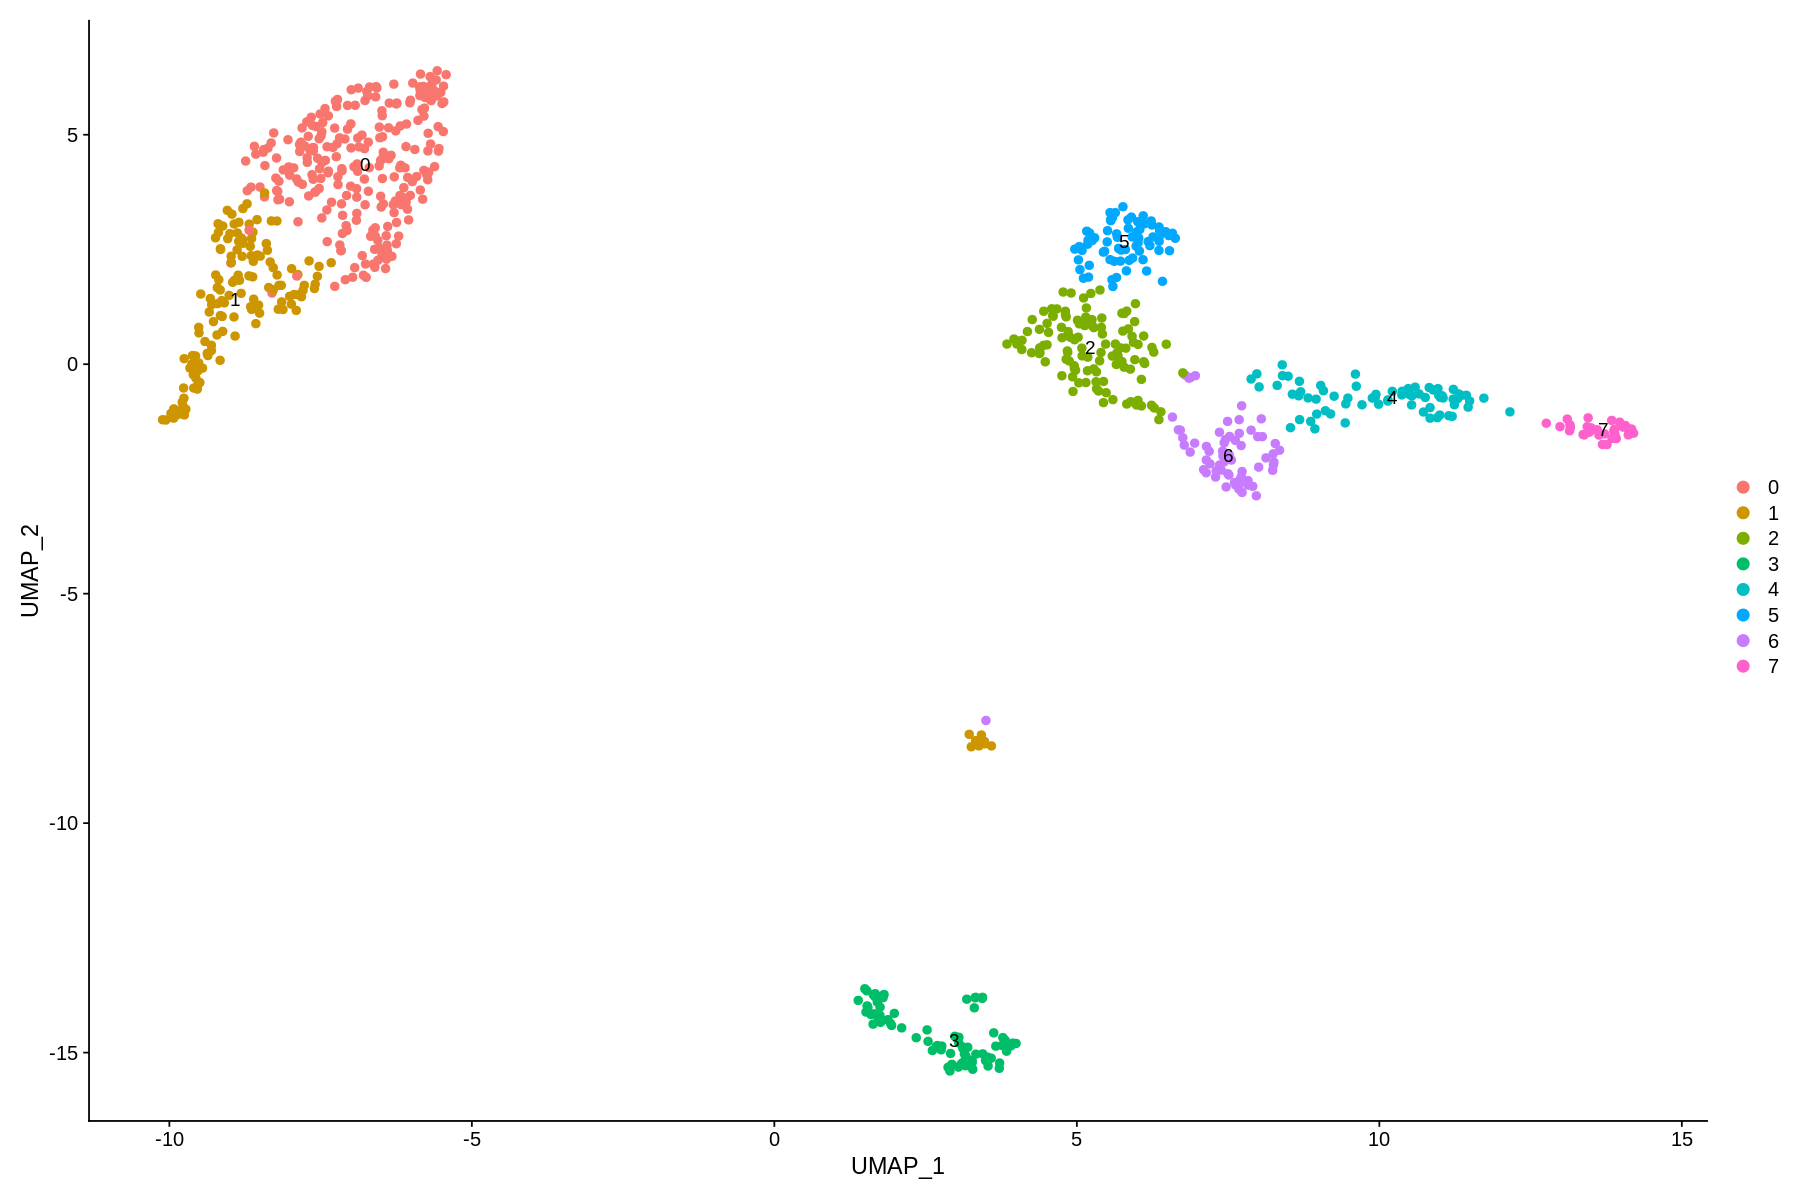

In [69]:
# visualize the clustering results
DimPlot(pbmc, pt.size = 2, label = TRUE)

You might notice here that we have one cluster in the center, which actually belongs to the same cluster as a group of cells far away on the UMAP plot. By adjusting the `resolution` parameter, we can get this group to be identified as a separate cluster:

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 825
Number of edges: 27456

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7746
Number of communities: 10
Elapsed time: 0 seconds


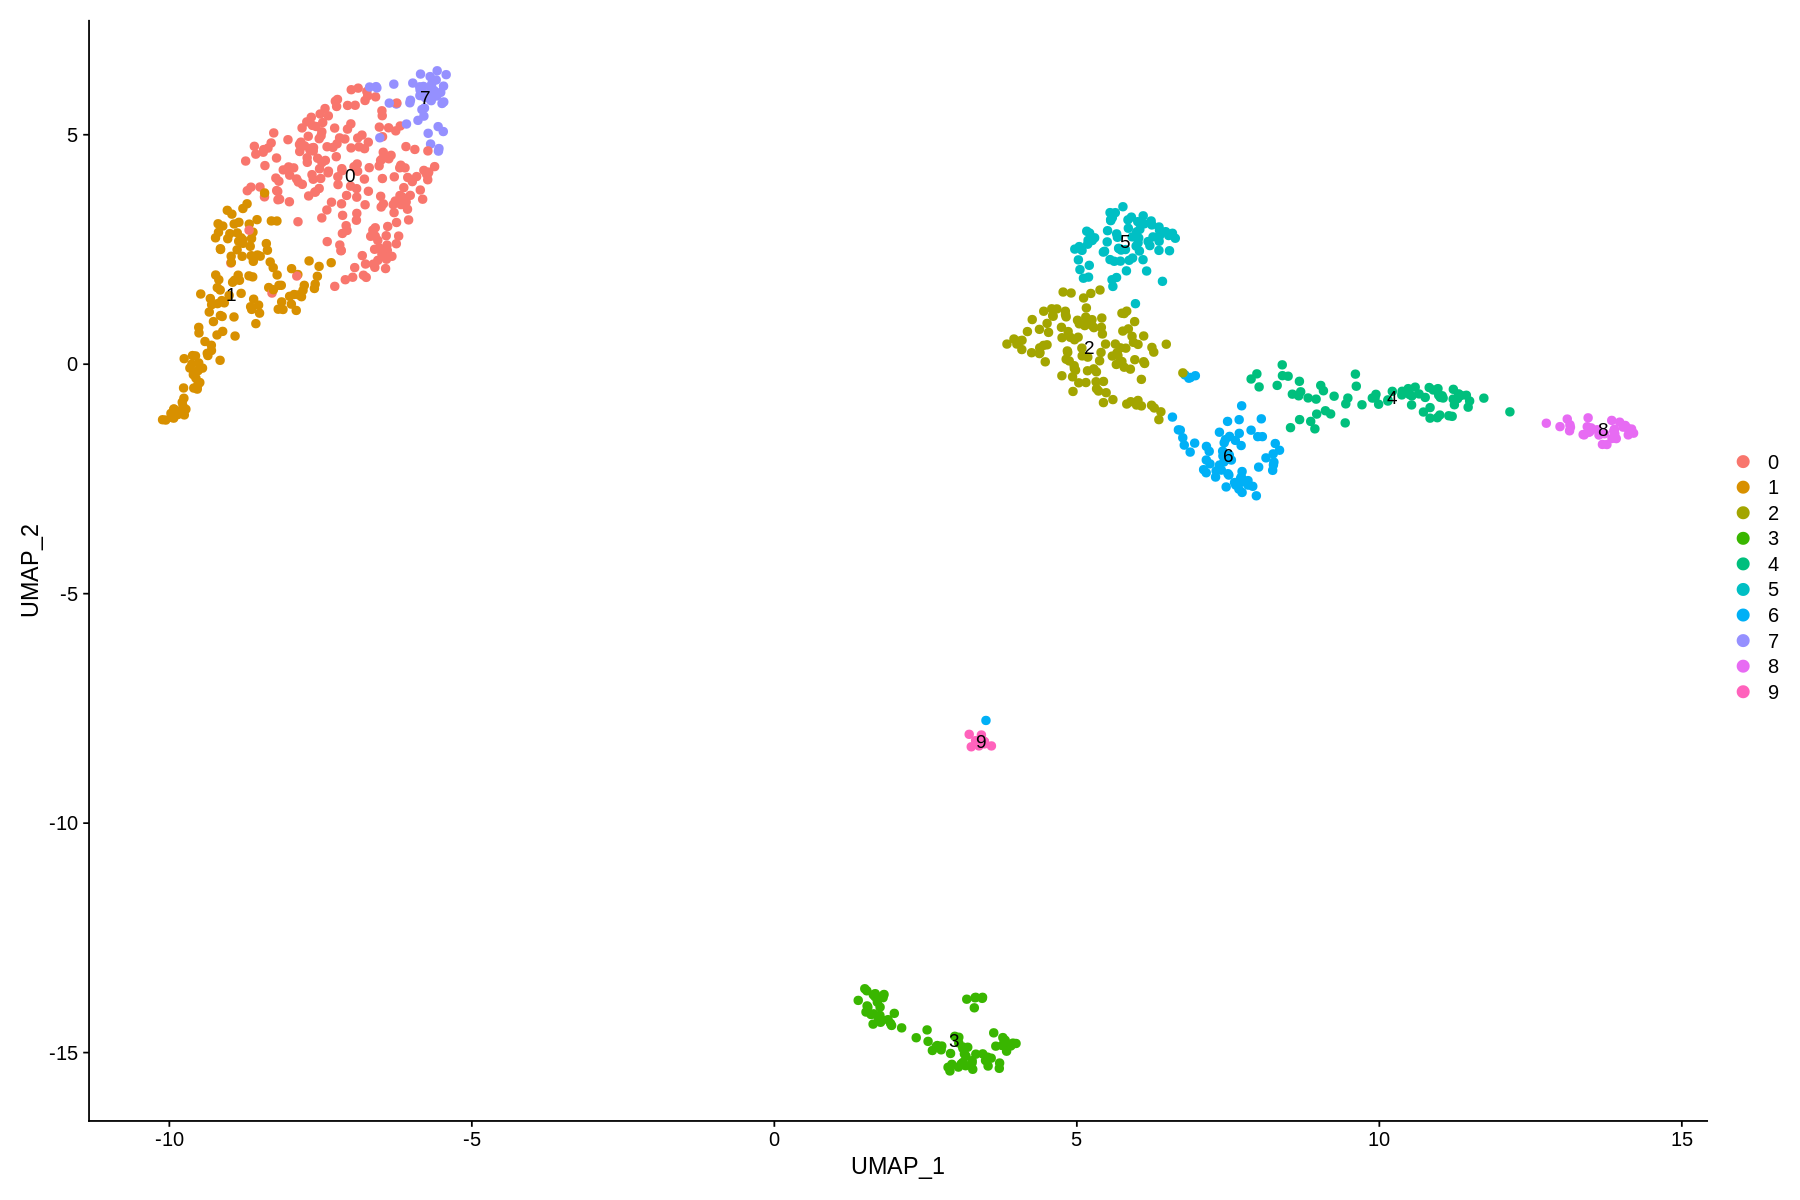

In [70]:
pbmc <- FindClusters(pbmc, resolution = 1)
DimPlot(pbmc, pt.size = 2, label = TRUE)

## Finding differentially expressed genes

Now that we have a set of clusters, we can ask what genes are differentially abundant between the different clusters in the dataset. Again, *many* different statistical methods have been developed to do this, with varying complexity.

### Wilcox test

One simple approach is to perform a [Wilcoxon rank sum test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test) between the expression values in two groups of cells. The Wilcoxon test is a nonparametric test (it does not make assumptions about the distribution of the data), and corresponds to the probability when randomly drawing two values $X$ and $Y$ from two independent populations that $X > Y$ (ie, that the distributions are different). This is a fast and simple test for differential expression between groups of cells.

### LR test

Another approach to differential expression is to build a logistic regression model to predict cluster membership, and compare with a null model. We can then use a likelihood ratio test to ask whether the models are different. One advantage of this approach is that we can include other covariates in the models, which can be useful if we want to compare across groups of in the presence of confounding variation from other sources (eg, differences due to different batches).

Let's compare between two different clusters to find differential genes:

In [71]:
de.wilcox <- FindMarkers(pbmc, ident.1 = 4, ident.2 = 8, test.use = "wilcox")

In [72]:
head(de.wilcox)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
FCER1G 1.743206e-19 -3.162493  0.056 0.938 6.380310e-15
TYROBP 1.049665e-17 -2.952567  0.169 1.000 3.841880e-13
CD3D   2.315042e-16  3.668948  1.000 0.031 8.473284e-12
IGFBP7 5.893787e-15 -2.127131  0.014 0.719 2.157185e-10
CD3G   2.936352e-14  2.993739  0.915 0.000 1.074734e-09
SPON2  4.599297e-14 -2.550766  0.155 0.906 1.683389e-09

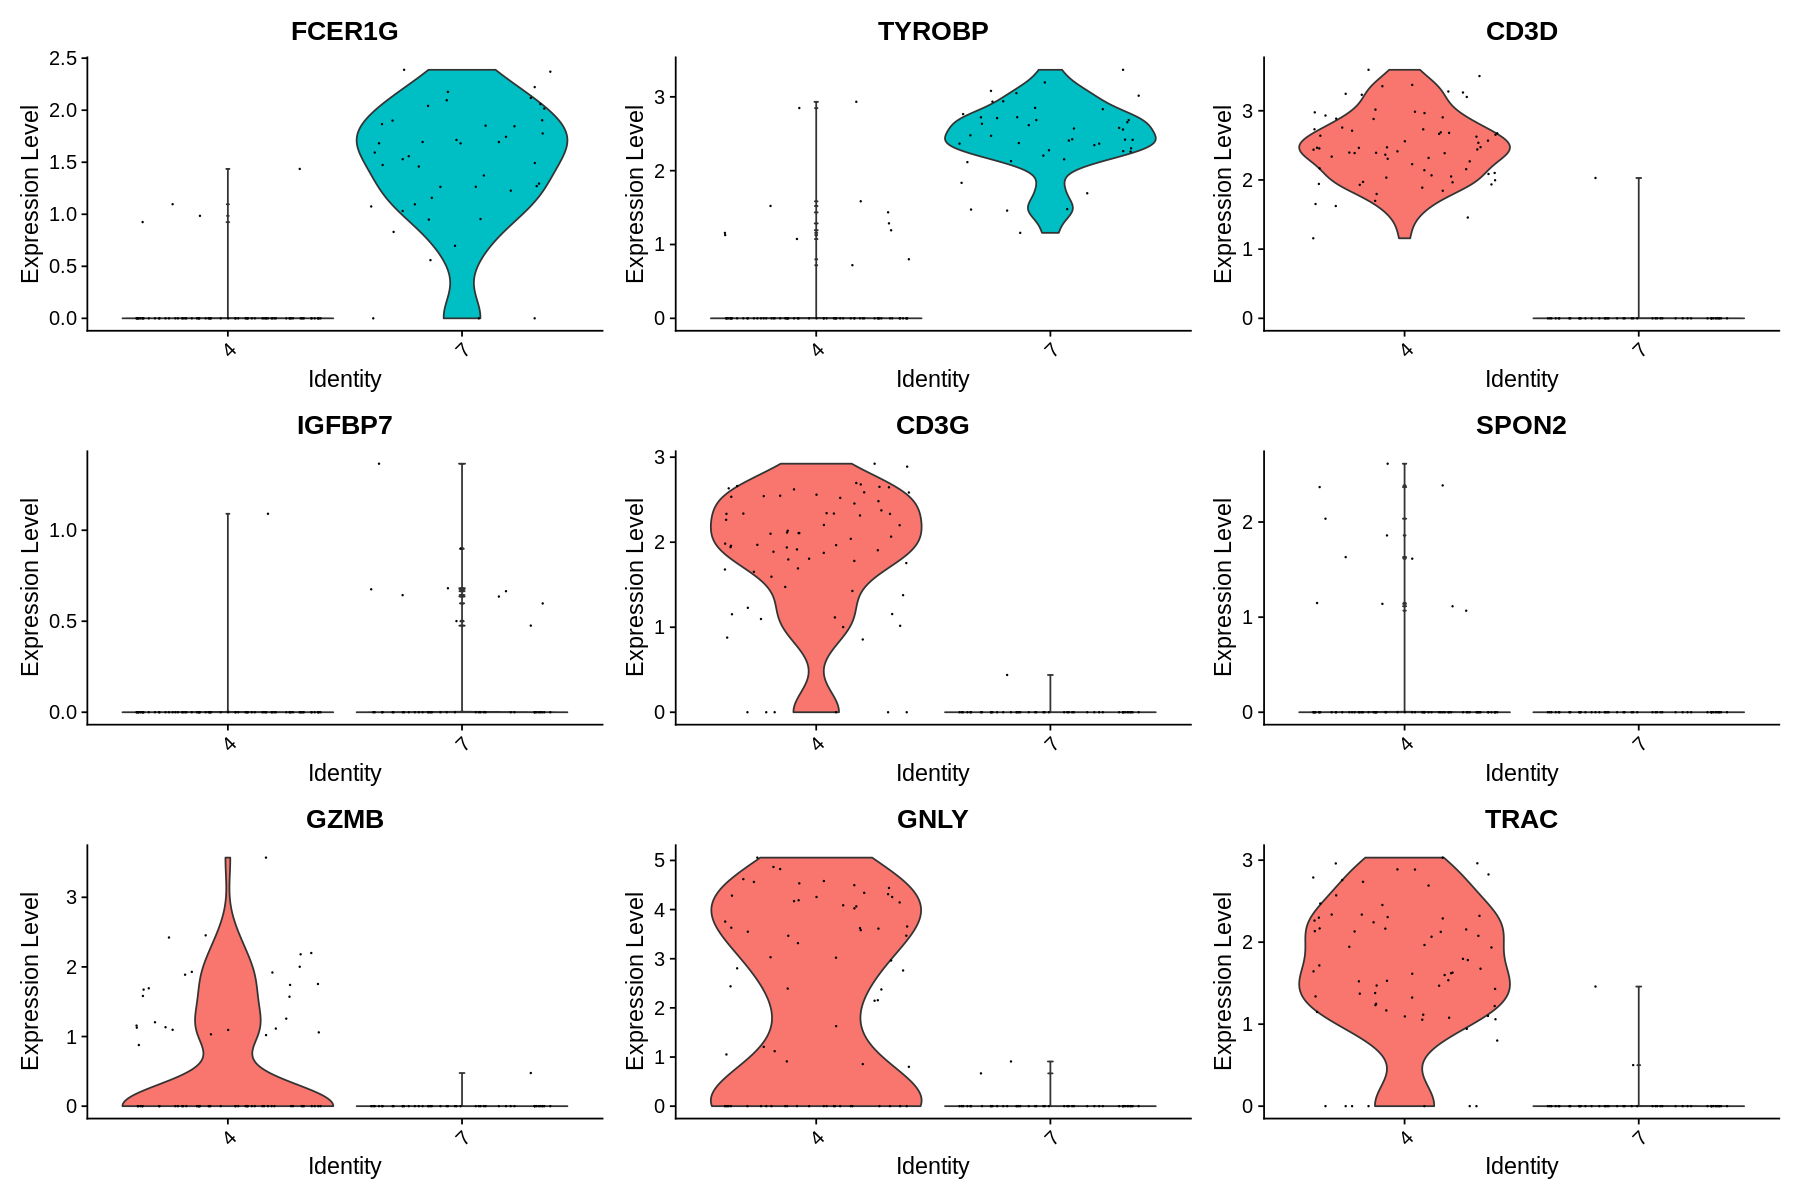

In [73]:
VlnPlot(pbmc, features = head(rownames(de.wilcox), 9), idents = c(4, 7))

As we can see, there is a clear difference in the expression of these genes between the two groups we've chosen to contrast. However, if we look across the full dataset we'll notice that some of the genes are not specific to a single population:

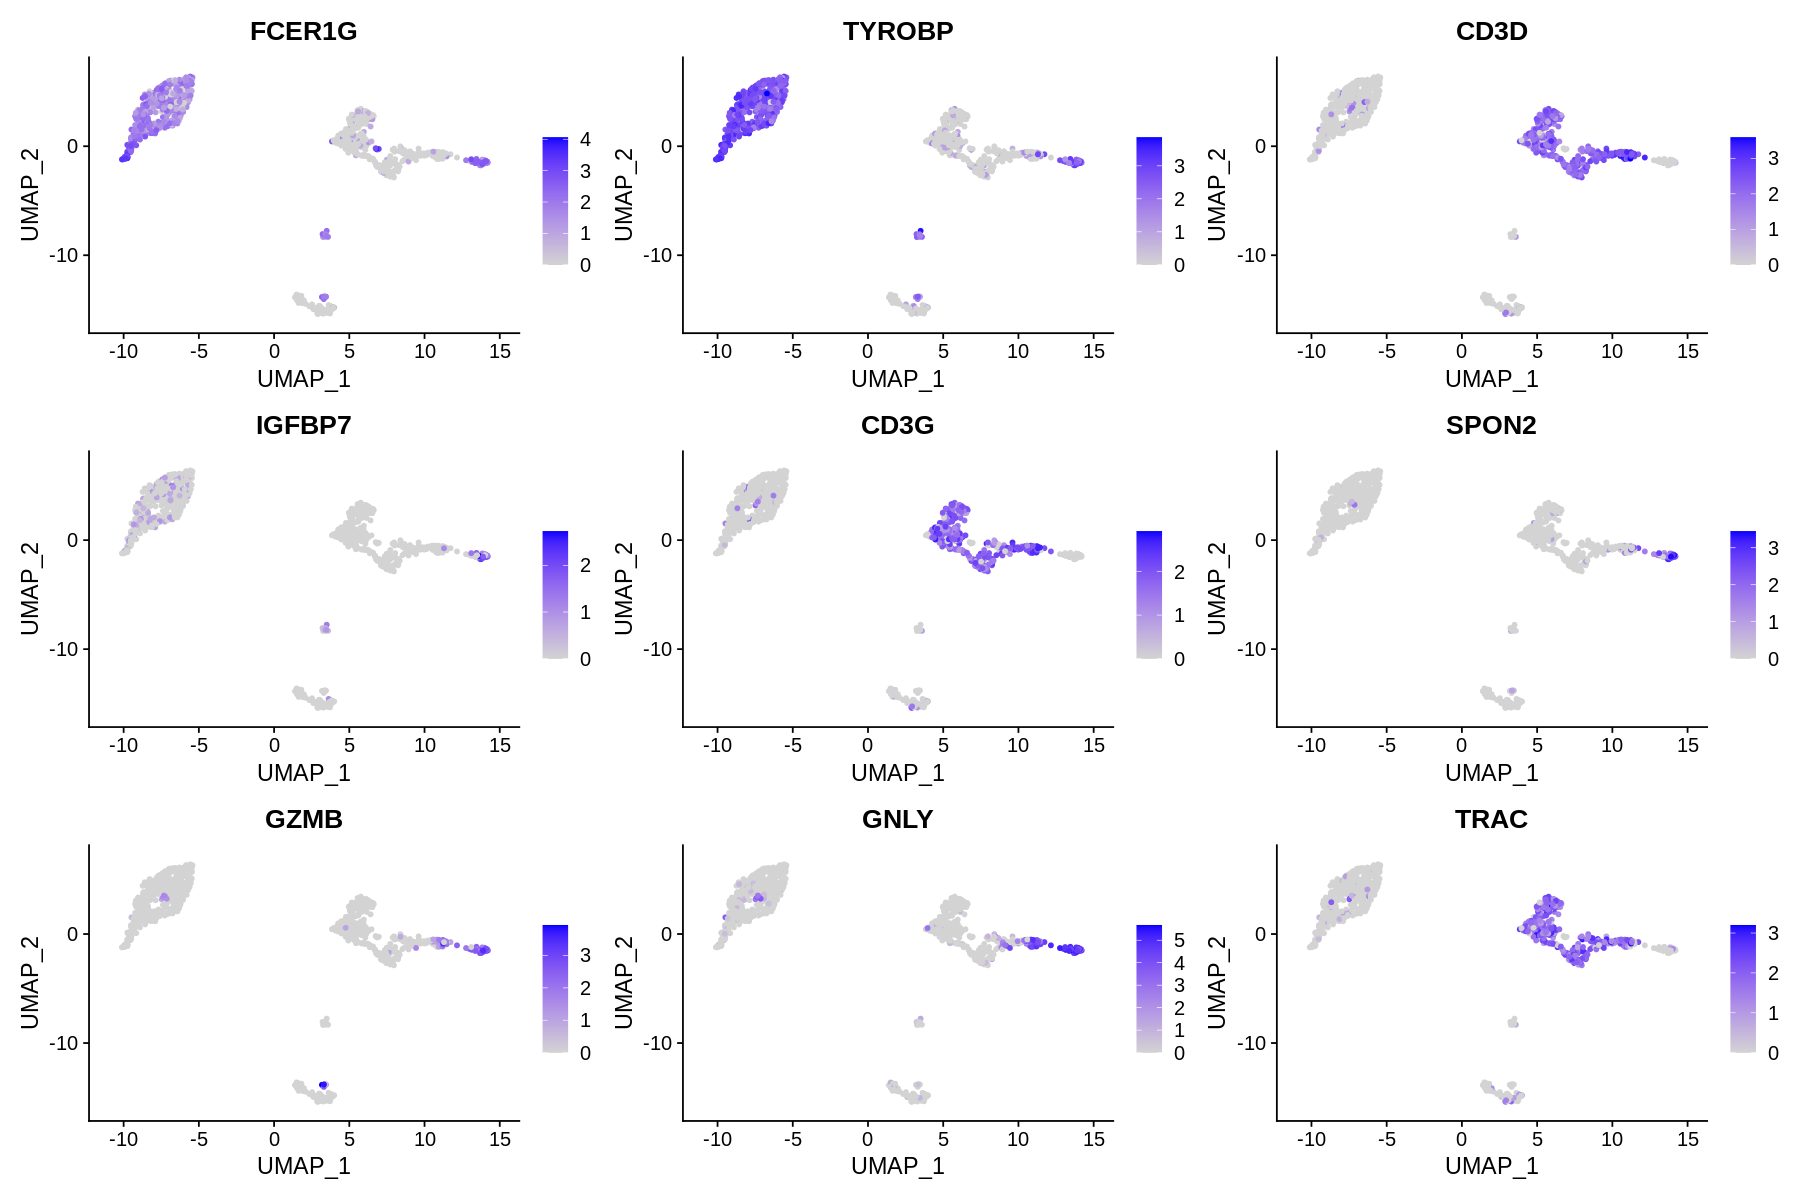

In [74]:
FeaturePlot(pbmc, head(rownames(de.wilcox), 9))

This is because we've contrasted two groups of cells, which won't necessarily find genes that are unique to a particular population. We can instead contrast one cluster against all other cells:

In [75]:
de.all <- FindMarkers(pbmc, ident.1 = 8, test.use = "wilcox")

In [76]:
head(de.all)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
SPON2  4.747017e-80 3.285927   0.906 0.040 1.737456e-75
FGFBP2 2.094030e-77 3.460149   0.969 0.052 7.664357e-73
KLRF1  4.598752e-77 2.913900   0.906 0.043 1.683189e-72
ADGRG1 7.022395e-74 2.118501   0.844 0.035 2.570267e-69
GZMB   2.671229e-71 3.345169   0.969 0.061 9.776964e-67
PTGDR  6.021531e-68 1.968145   0.781 0.034 2.203941e-63

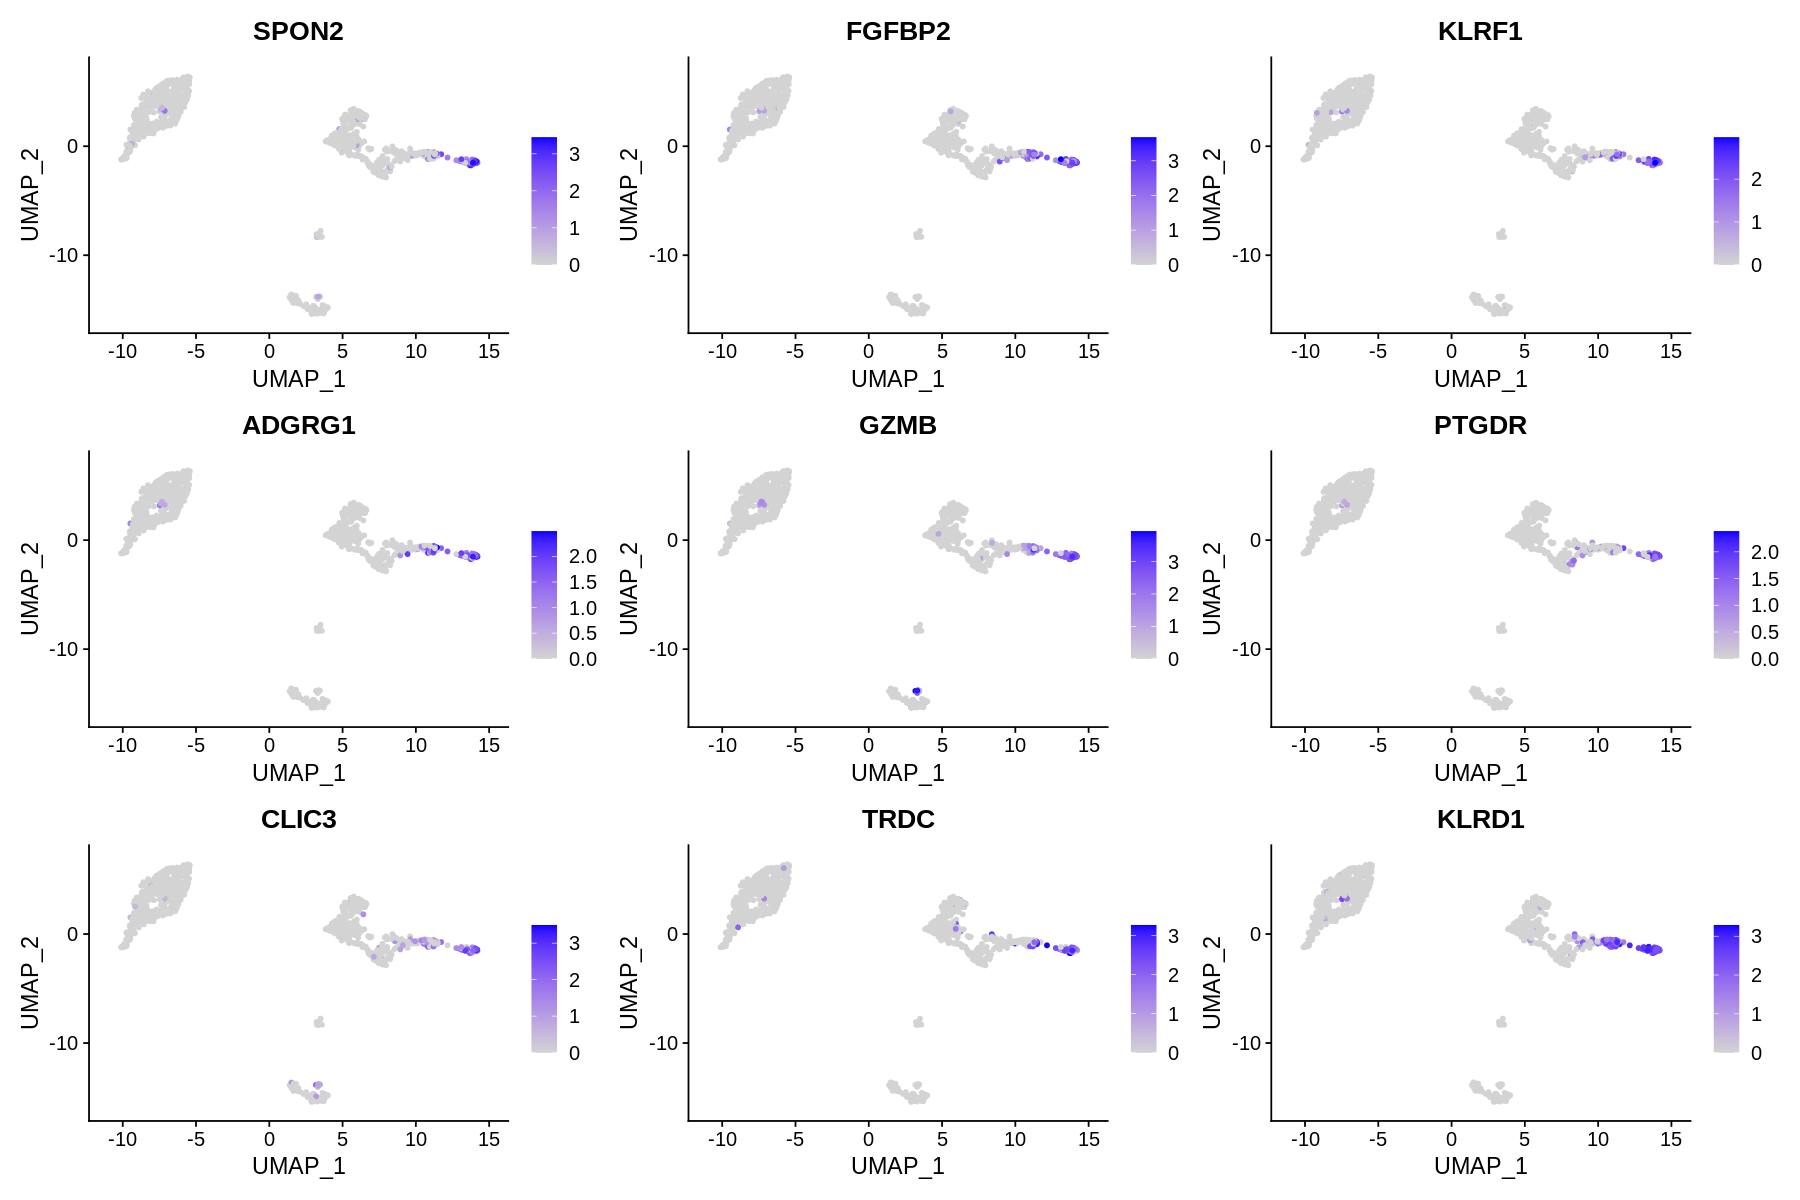

In [77]:
FeaturePlot(pbmc, head(rownames(de.all), 9))

Now we see that the resulting genes are more specific for the particular cluster that we tested. We could also run the same test for each cluster in the dataset, comparing against all other cells, using the `FindAllMarkers()` function. However, a much faster way to compute the Wilcox test is by using the [Presto](https://github.com/immunogenomics/presto) package.

In [78]:
all.markers <- presto::wilcoxauc(pbmc, "seurat_clusters")

In [79]:
head(all.markers)

feature     group avgExpr    logFC       statistic auc       pval    padj
1 MIR1302-2HG 0     0.00000000 0.000000000 63133     0.5000000 1.00000 1   
2 FAM138A     0     0.00000000 0.000000000 63133     0.5000000 1.00000 1   
3 OR4F5       0     0.00000000 0.000000000 63133     0.5000000 1.00000 1   
4 AL627309.1  0     0.00543498 0.001399251 63141     0.5000634 0.98313 1   
5 AL627309.3  0     0.00000000 0.000000000 63133     0.5000000 1.00000 1   
6 AL627309.2  0     0.00000000 0.000000000 63133     0.5000000 1.00000 1   
  pct_in    pct_out  
1 0.0000000 0.0000000
2 0.0000000 0.0000000
3 0.0000000 0.0000000
4 0.4926108 0.4823151
5 0.0000000 0.0000000
6 0.0000000 0.0000000

In [80]:
dim(all.markers)

[1] 366010     10

Presto outputs the statistic for every gene, so we can apply some filtering to the output to get only the differential genes:

In [81]:
markers.filtered <- all.markers[all.markers$padj < 0.01 & abs(all.markers$logFC) > 0.5, ]

In [82]:
dim(markers.filtered)

[1] 2971   10

In [83]:
head(markers.filtered)

feature  group avgExpr   logFC     statistic auc       pval        
31  ISG15    0     1.4270795 0.5874450  85268.0  0.6753045 1.845883e-14
246 RBP7     0     0.7425791 0.5830789  94088.0  0.7451570 7.370007e-41
251 PGD      0     1.0787471 0.7999779 104598.0  0.8283940 6.227231e-56
283 AGTRAP   0     0.9341571 0.5748094  93587.5  0.7411932 7.749130e-30
298 TNFRSF1B 0     1.5203018 0.8941199 100480.5  0.7957843 3.935069e-40
351 EFHD2    0     1.4195349 0.6499190  89943.0  0.7123295 5.328006e-21
    padj         pct_in   pct_out 
31  8.159559e-13 82.75862 60.45016
246 1.665121e-38 62.56158 15.75563
251 5.559095e-53 85.22167 26.84887
283 9.391587e-28 75.86207 34.24437
298 8.728938e-38 94.58128 42.92605
351 3.658731e-19 92.61084 49.19614

In [84]:
# how many DE genes per cluster
table(markers.filtered$group)


  0   1   2   3   4   5   6   7   8   9 
404 337 375 325 234 378 188 305 315 110 

In [85]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [86]:
# find the top 20 genes per cluster
top.markers <- markers.filtered %>% group_by(group) %>% top_n(n = 20, wt = logFC)

In [87]:
table(top.markers$group)


 0  1  2  3  4  5  6  7  8  9 
20 20 20 20 20 20 20 20 20 20 

In [88]:
head(top.markers)

feature group avgExpr  logFC    statistic auc       pval         padj        
1 CTSS    0     3.896723 2.288506 115133.0  0.9118290 1.654459e-70 6.055484e-67
2 S100A9  0     4.916819 3.199448 115940.5  0.9182242 1.902928e-72 7.738784e-69
3 S100A12 0     1.934105 1.556200 113270.5  0.8970784 6.362989e-81 1.164459e-76
4 S100A8  0     4.360595 3.094005 115583.5  0.9153969 6.134375e-74 2.806553e-70
5 MNDA    0     2.994332 2.136002 116119.5  0.9196419 7.633844e-80 9.313544e-76
6 VCAN    0     3.081978 2.436648 117308.0  0.9290545 5.772958e-87 2.112960e-82
  pct_in    pct_out 
1 100.00000 68.97106
2 100.00000 71.54341
3  95.07389 23.63344
4  99.50739 53.53698
5  99.50739 39.06752
6  99.01478 32.15434

20 markers for each cluster (200 genes total) is too much to look at using violin plots or on the UMAP. Instead, we can plot the scaled and centered data (which puts each gene into a similar range of values) as a heatmap:

Centering and scaling data matrix



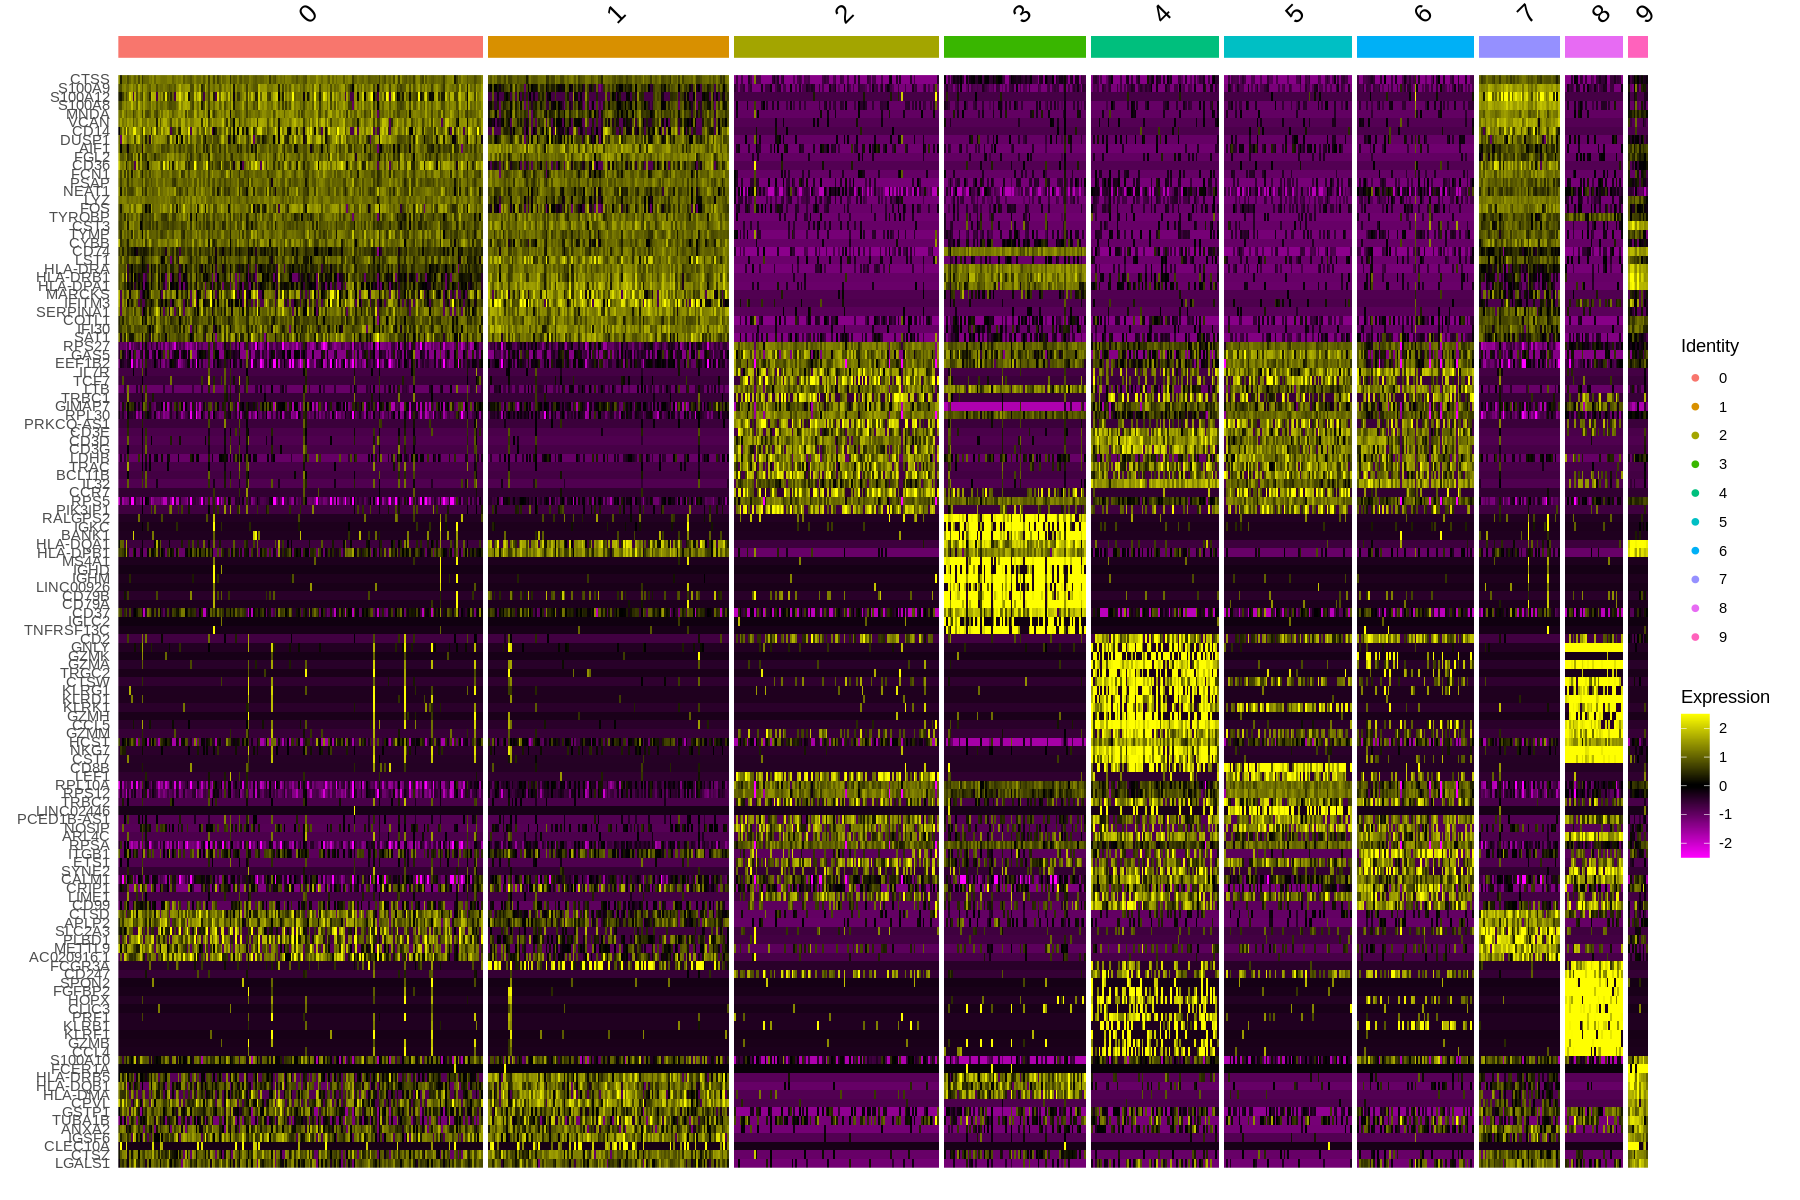

In [89]:
# first scale and center the expression values
pbmc <- ScaleData(pbmc, features = top.markers$feature)

# create a heatmap
DoHeatmap(pbmc, features = unique(top.markers$feature))

From this we can see that some of our cluster splits may not be well-supported by the data. For example, the top DE genes for cluster 0 are also expressed in cluster 1. We typically would want to manually merge or split clusters based on other lines of evidence (differentially expressed genes or proteins) to be confident in the cluster assignments. This can be a time consuming, difficult, and sometimes subjective task.

Another approach for annotating the cells is to map them to an existing reference dataset. This avoids needing to cluster the data, and often enables us to leverage the information in a larger, more high-quality dataset to enhance the interpretation of our data.

## Reference mapping

New analysis methods enable us to map our small immune dataset onto a much larger immune reference atlas, and automatically annotate the cell types based on the reference mapping. We can either do this in R using Seurat, or in a web app built by the Satija lab: https://azimuth.hubmapconsortium.org

Here, we'll demonstrate reference mapping within our R session. If you'd prefer to try the web app rather than downloading the reference dataset and running the mapping on your own machine, you can upload the PBMC count matrix to the Azimuth web app and explore the results there.

To get started within R, we need to load the reference dataset:

In [90]:
library(SeuratDisk)

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [91]:
reference <- LoadH5Seurat("pbmc_multimodal.h5seurat")

Validating h5Seurat file

Initializing ADT with data

Adding counts for ADT

Adding variable feature information for ADT

Adding miscellaneous information for ADT

Initializing SCT with data

Adding counts for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction apca

Adding cell embeddings for apca

Adding feature loadings for apca

Adding miscellaneous information for apca

Adding reduction aumap

Adding cell embeddings for aumap

Adding miscellaneous information for aumap

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction spca

Adding cell embeddings for spca

Adding feature loadings for spca

Adding miscellaneous information for spca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding reduction wnn.umap

Adding cell embeddings for wnn.umap

Adding miscellaneous information for w

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



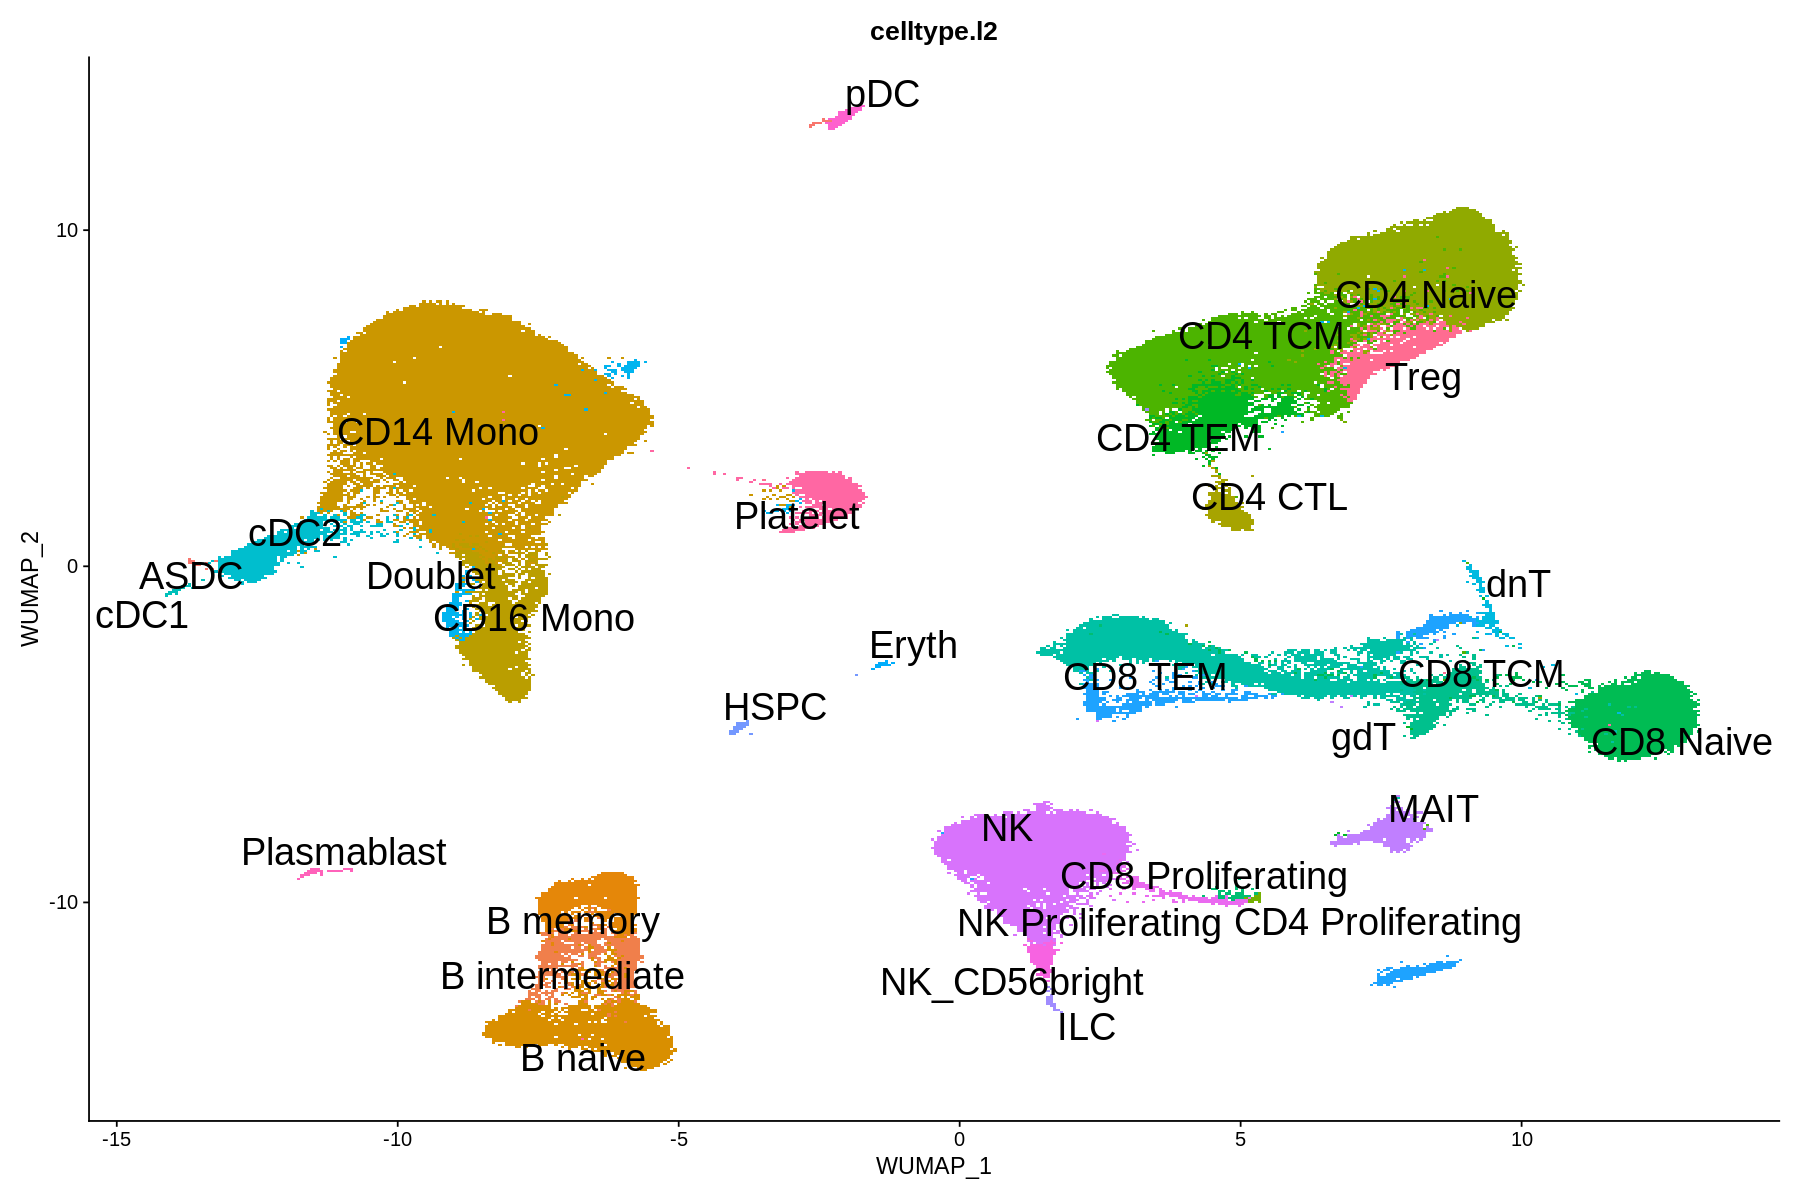

In [92]:
# take a look at the reference dataset
DimPlot(object = reference, reduction = "wnn.umap", group.by = "celltype.l2", label = TRUE, label.size = 8, repel = TRUE) + NoLegend()

In [93]:
# find anchors between the reference and our query dataset
anchors <- FindTransferAnchors(
  reference = reference,
  query = pbmc,
  normalization.method = "SCT",
  reference.reduction = "spca",
  dims = 1:50
)

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 3021 anchors



In [94]:
# map query to reference
pbmc <- MapQuery(
  anchorset = anchors,
  query = pbmc,
  reference = reference,
  refdata = "celltype.l2",
  reference.reduction = "spca", 
  reduction.model = "wnn.umap"
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.spca_ to refspca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.spca_ to refspca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to refspca_”
Computing nearest neighbors

Running UMAP projection

01:21:26 Read 825 rows and found  numeric columns

01:21:26 Processing block 1 of 1

01:21:26 Commencing smooth kNN distance calibration using 1 thread

01:21:26 Initializing by weighted average of neighbor coordinates using 1 thread

01:21:26 Commencing optimization for

In [95]:
pbmc

An object of class Seurat 
50579 features across 825 samples within 4 assays 
Active assay: RNA (36601 features, 2000 variable features)
 3 other assays present: ADT, SCT, prediction.score.id
 4 dimensional reductions calculated: pca, umap, ref.spca, ref.umap

In [96]:
head(pbmc)

orig.ident    nCount_RNA nFeature_RNA nCount_ADT
AATCACGAGCAGCCCT-1 SeuratProject 3058       1020         1651      
AATCACGAGGAACTCG-1 SeuratProject 2176        975          788      
AATCACGCACTACCGG-1 SeuratProject 5536       2120         1305      
AATCACGCATGAATAG-1 SeuratProject 5077       1462         1007      
AATCACGGTATAGGAT-1 SeuratProject 7386       2097          928      
AATCACGGTCGAATGG-1 SeuratProject 3966       1333         1428      
AATCACGGTGTCTAAC-1 SeuratProject 6357       1541         1077      
AATCACGTCCACGTAA-1 SeuratProject 5737       1506          895      
AATCACGTCCCGTTGT-1 SeuratProject 5332       1742         1610      
AATCACGTCGCCTTGT-1 SeuratProject 9873       3263         2566      
                   nFeature_ADT percent.mt nCount_SCT nFeature_SCT
AATCACGAGCAGCCCT-1  9            6.572923  6122       1185        
AATCACGAGGAACTCG-1  9           18.060662  5586       1378        
AATCACGCACTACCGG-1  9            5.491329  6455       2105        
AATCACGCATGAATAG-1  9            4.589324  6417       1458        
AATCACGGTATAGGAT-1  9            8.055781  7266       2086        
AATCACGGTCGAATGG-1 10           13.640948  6260       1378        
AATCACGGTGTCTAAC-1  9            5.411358  6768       1526        
AATCACGTCCACGTAA-1  9            5.438382  6579       1493        
AATCACGTCCCGTTGT-1  9            9.414854  6455       1734        
AATCACGTCGCCTTGT-1  9            5.520105  7878       3242        
                   RNA_snn_res.0.8 seurat_clusters RNA_snn_res.1
AATCACGAGCAGCCCT-1 2               2               2            
AATCACGAGGAACTCG-1 5               5               5            
AATCACGCACTACCGG-1 4               4               4            
AATCACGCATGAATAG-1 2               2               2            
AATCACGGTATAGGAT-1 4               4               4            
AATCACGGTCGAATGG-1 2               2               2            
AATCACGGTGTCTAAC-1 5               5               5            
AATCACGTCCACGTAA-1 2               2               2            
AATCACGTCCCGTTGT-1 6               6               6            
AATCACGTCGCCTTGT-1 0               0               0            
                   predicted.id.score predicted.id
AATCACGAGCAGCCCT-1 0.8384320          CD4 Naive   
AATCACGAGGAACTCG-1 0.5541250          CD4 Naive   
AATCACGCACTACCGG-1 0.8368318          CD8 TEM     
AATCACGCATGAATAG-1 0.8828366          CD4 Naive   
AATCACGGTATAGGAT-1 0.6805535          gdT         
AATCACGGTCGAATGG-1 0.7890298          CD4 Naive   
AATCACGGTGTCTAAC-1 0.9922326          CD8 Naive   
AATCACGTCCACGTAA-1 0.4832647          CD4 Naive   
AATCACGTCCCGTTGT-1 0.4882223          CD4 TEM     
AATCACGTCGCCTTGT-1 1.0000000          CD14 Mono

We now have a new cell of cell identities, `predicted.id`, as well as a new reduction, `ref.umap`, which is the cells projected onto the reference UMAP. Lets take a look at the predicted IDs:

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


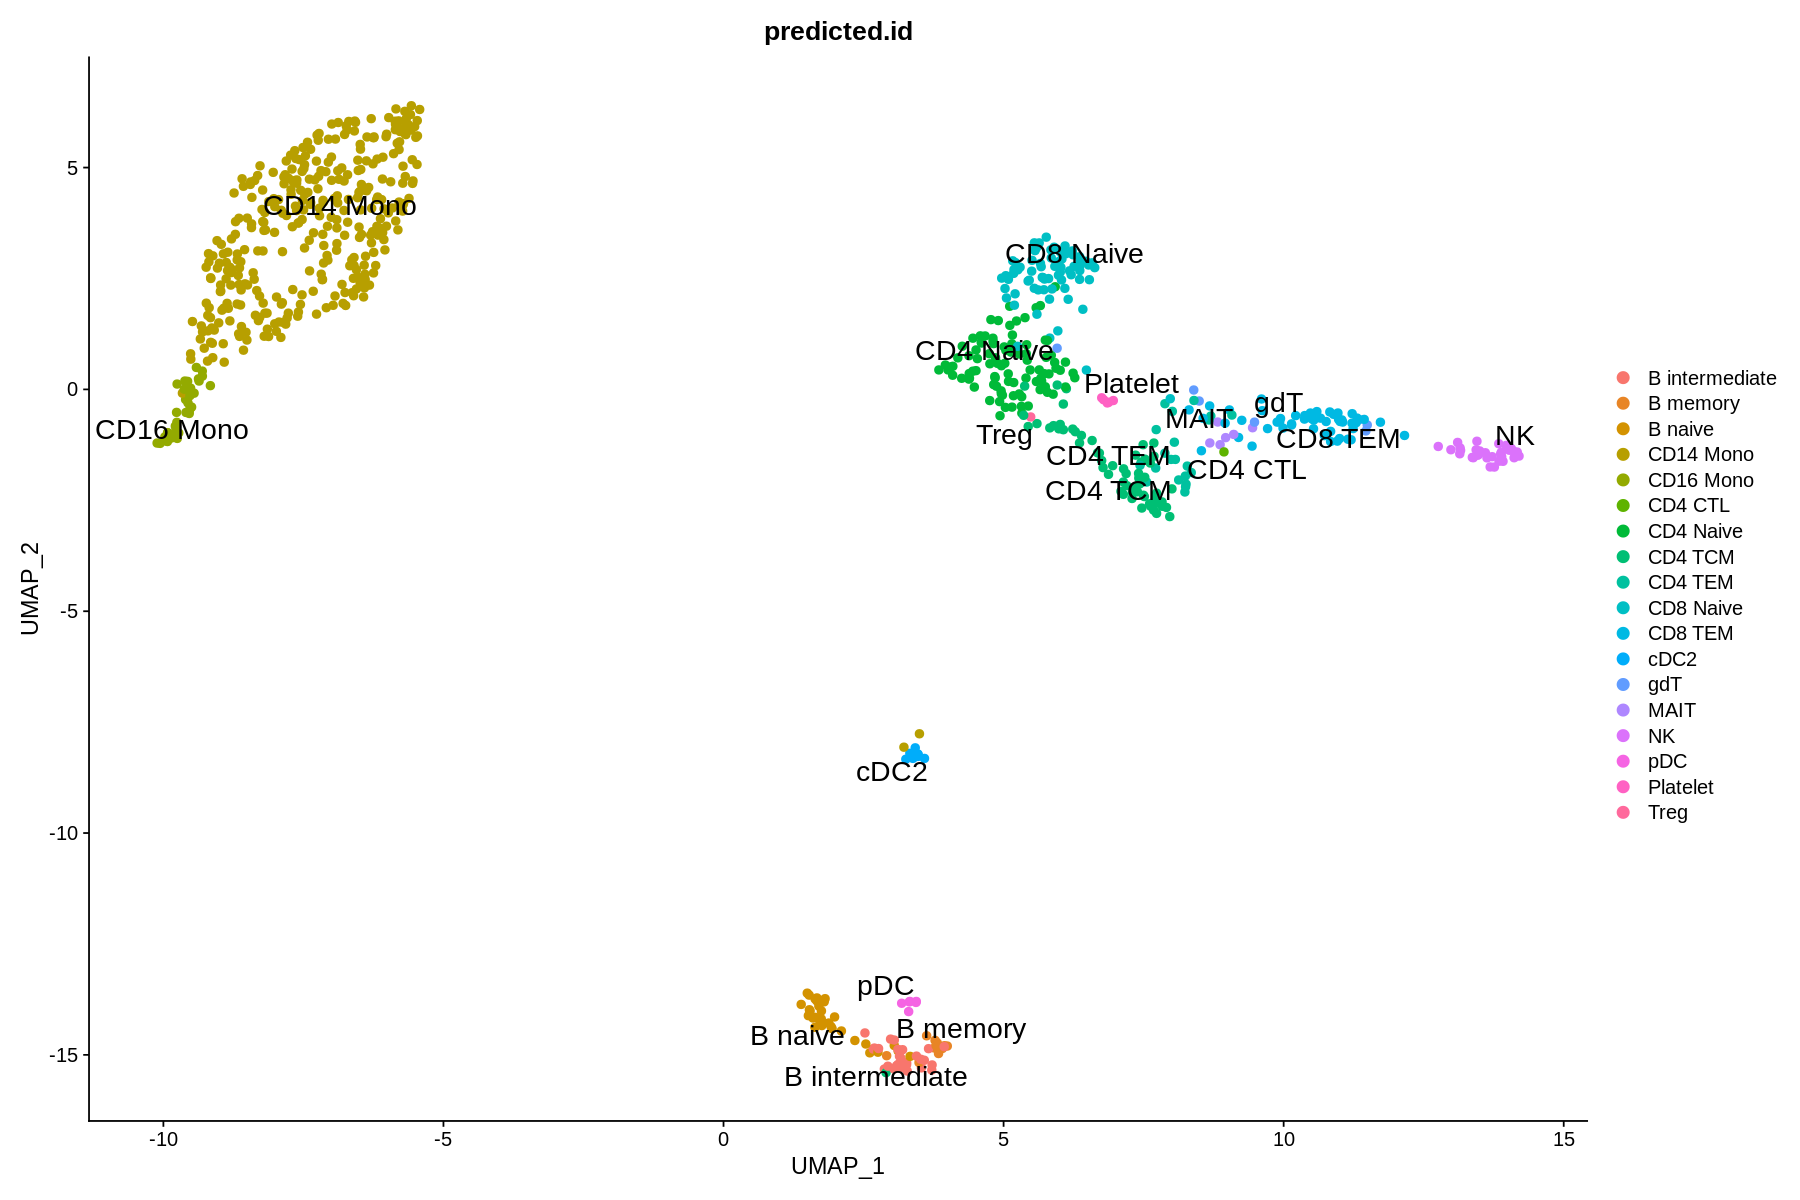

In [97]:
DimPlot(pbmc, group.by = 'predicted.id', pt.size = 2, label = TRUE, repel = TRUE, label.size = 6)

These labels make sense, and are able to resolve finer structure in the dataset than we were able to do with an unsupervised clustering (identification of platelet cells, pDCs, and B cell subtypes, for example). We can also visualize our cells on the reference UMAP:

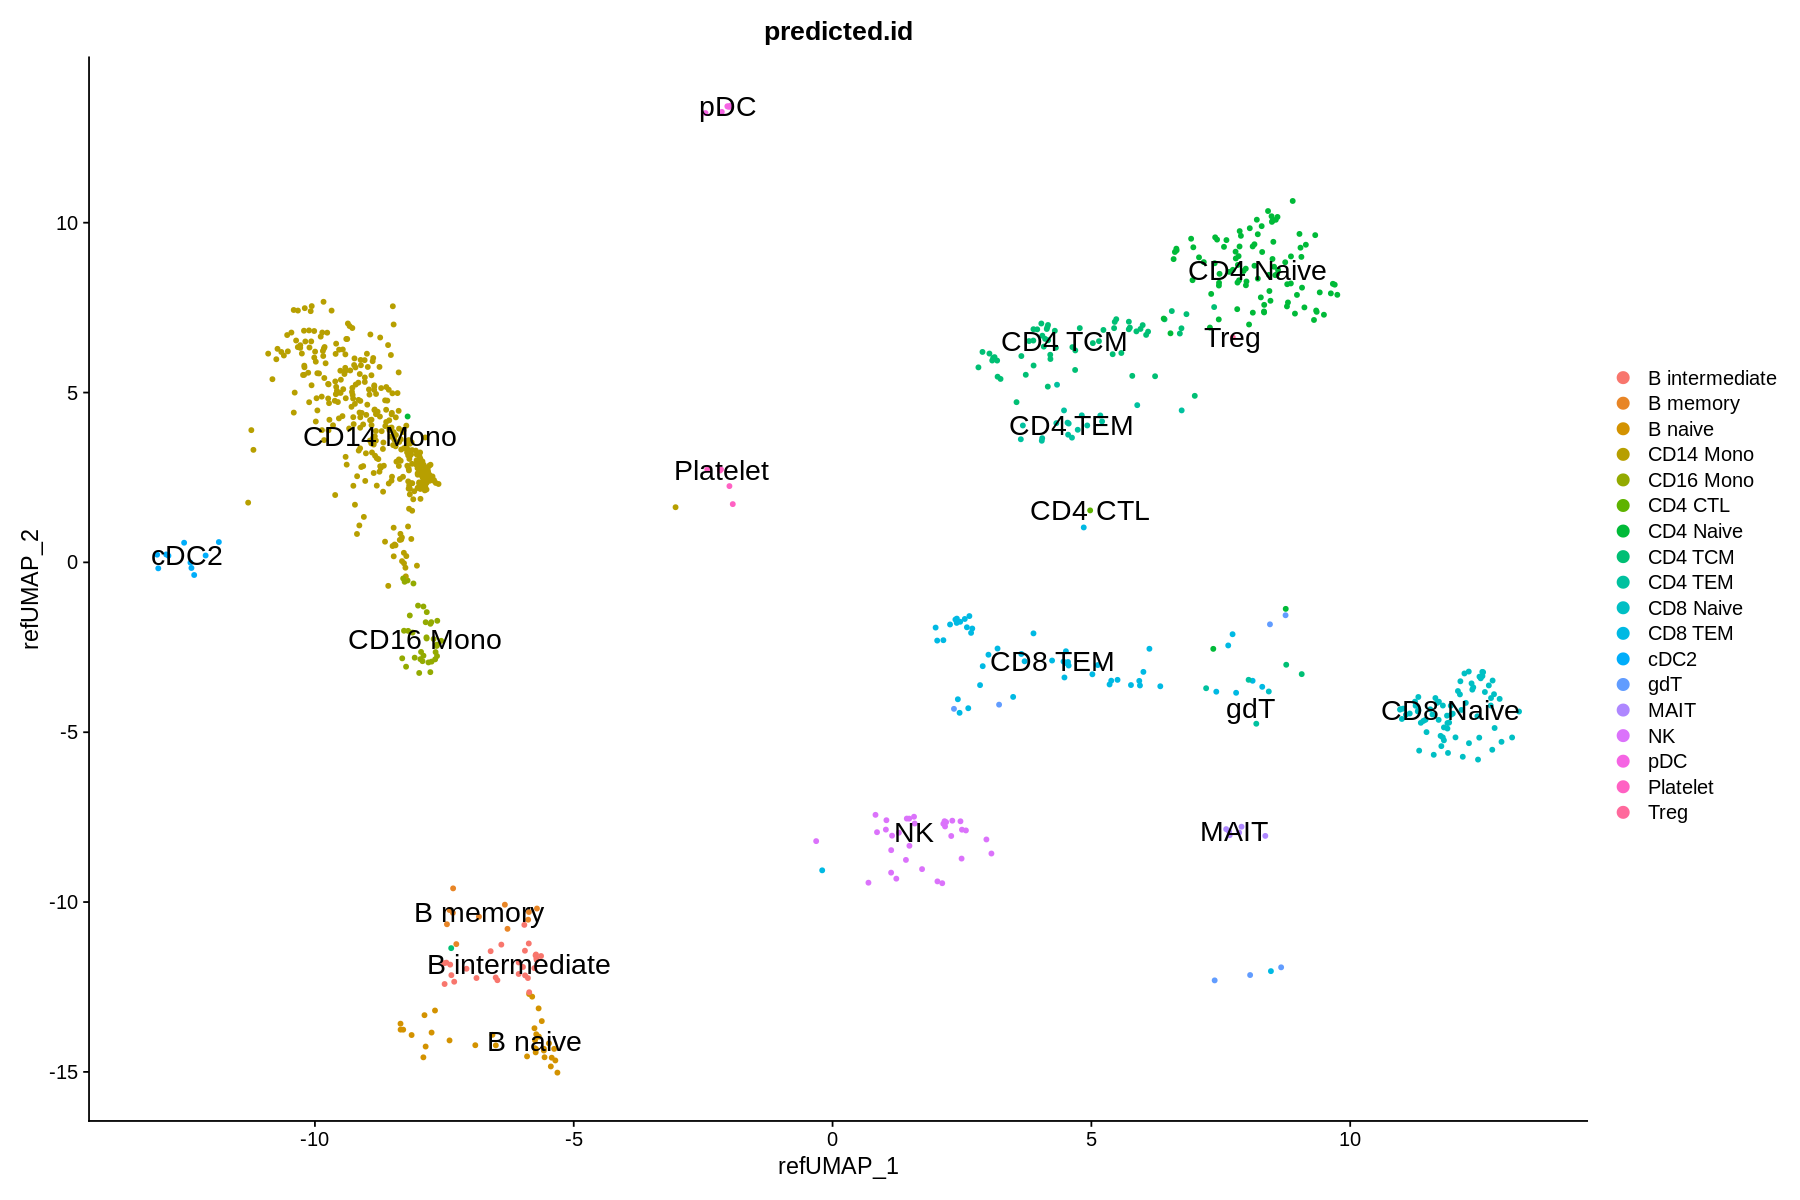

In [98]:
DimPlot(pbmc, reduction = "ref.umap", group.by = "predicted.id", label = TRUE, label.size = 6)

We can check whether we believe these results by looking at differentially expressed genes specific to the predicted cell type classes. For example, let's look for DE genes specific to the predicted group of platelet cells that we didn't discover in our original clustering analysis. Are they really different to the nearby CD4 Naive cells?

In [99]:
# change the active identities so we don't have to keep setting the "group.by" argument
Idents(pbmc) <- "predicted.id"

In [100]:
platelet.markers <- FindMarkers(pbmc, ident.1 = "Platelet", ident.2 = "CD4 Naive", only.pos = TRUE)

In [101]:
head(platelet.markers)

p_val       avg_log2FC pct.1 pct.2 p_val_adj   
CAVIN2 1.95998e-23 6.131300   1     0     7.173722e-19
PF4    1.95998e-23 7.592246   1     0     7.173722e-19
F13A1  1.95998e-23 4.148439   1     0     7.173722e-19
GNG11  1.95998e-23 6.516098   1     0     7.173722e-19
CLU    1.95998e-23 5.738792   1     0     7.173722e-19
NRGN   1.95998e-23 7.362715   1     0     7.173722e-19

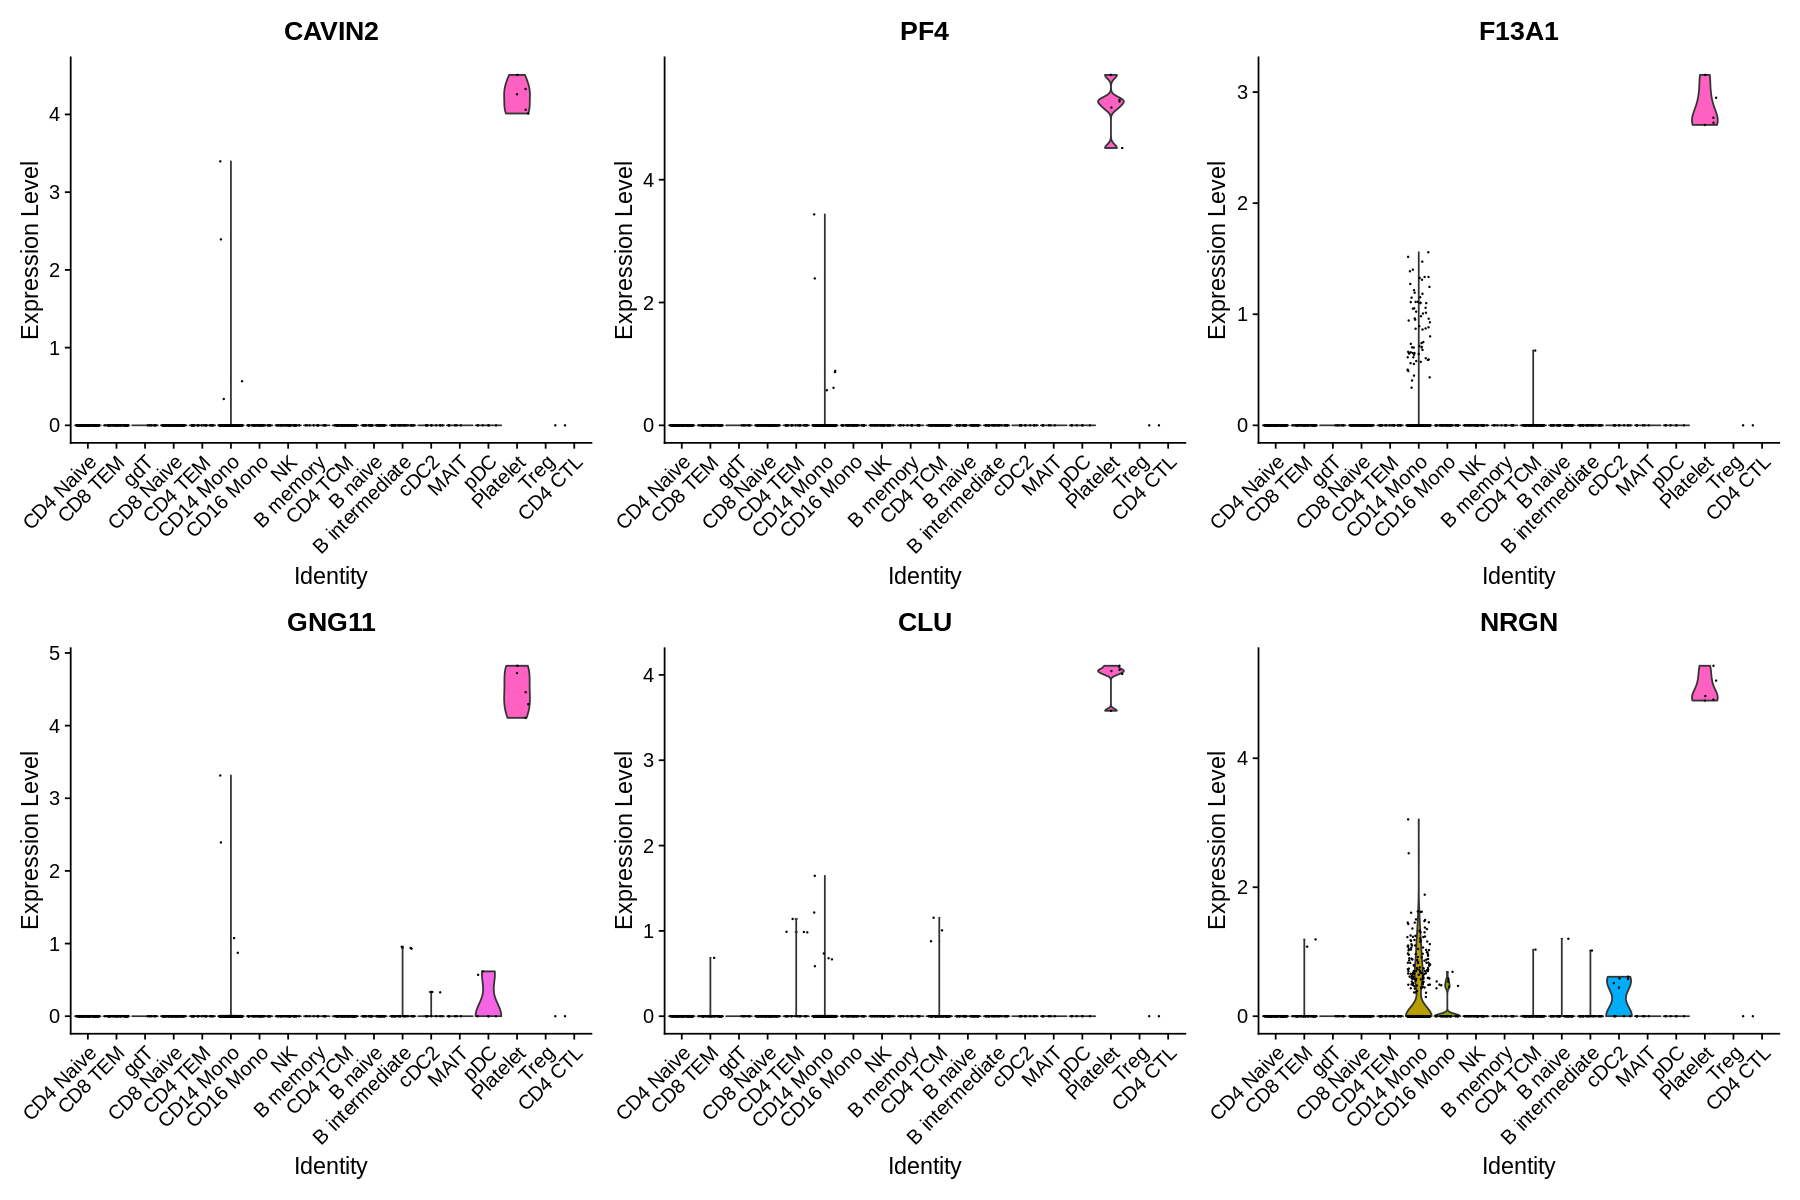

In [102]:
VlnPlot(pbmc, head(rownames(platelet.markers)))

These are clearly different. We can also see that these expression patterns are consistent with the reference dataset:

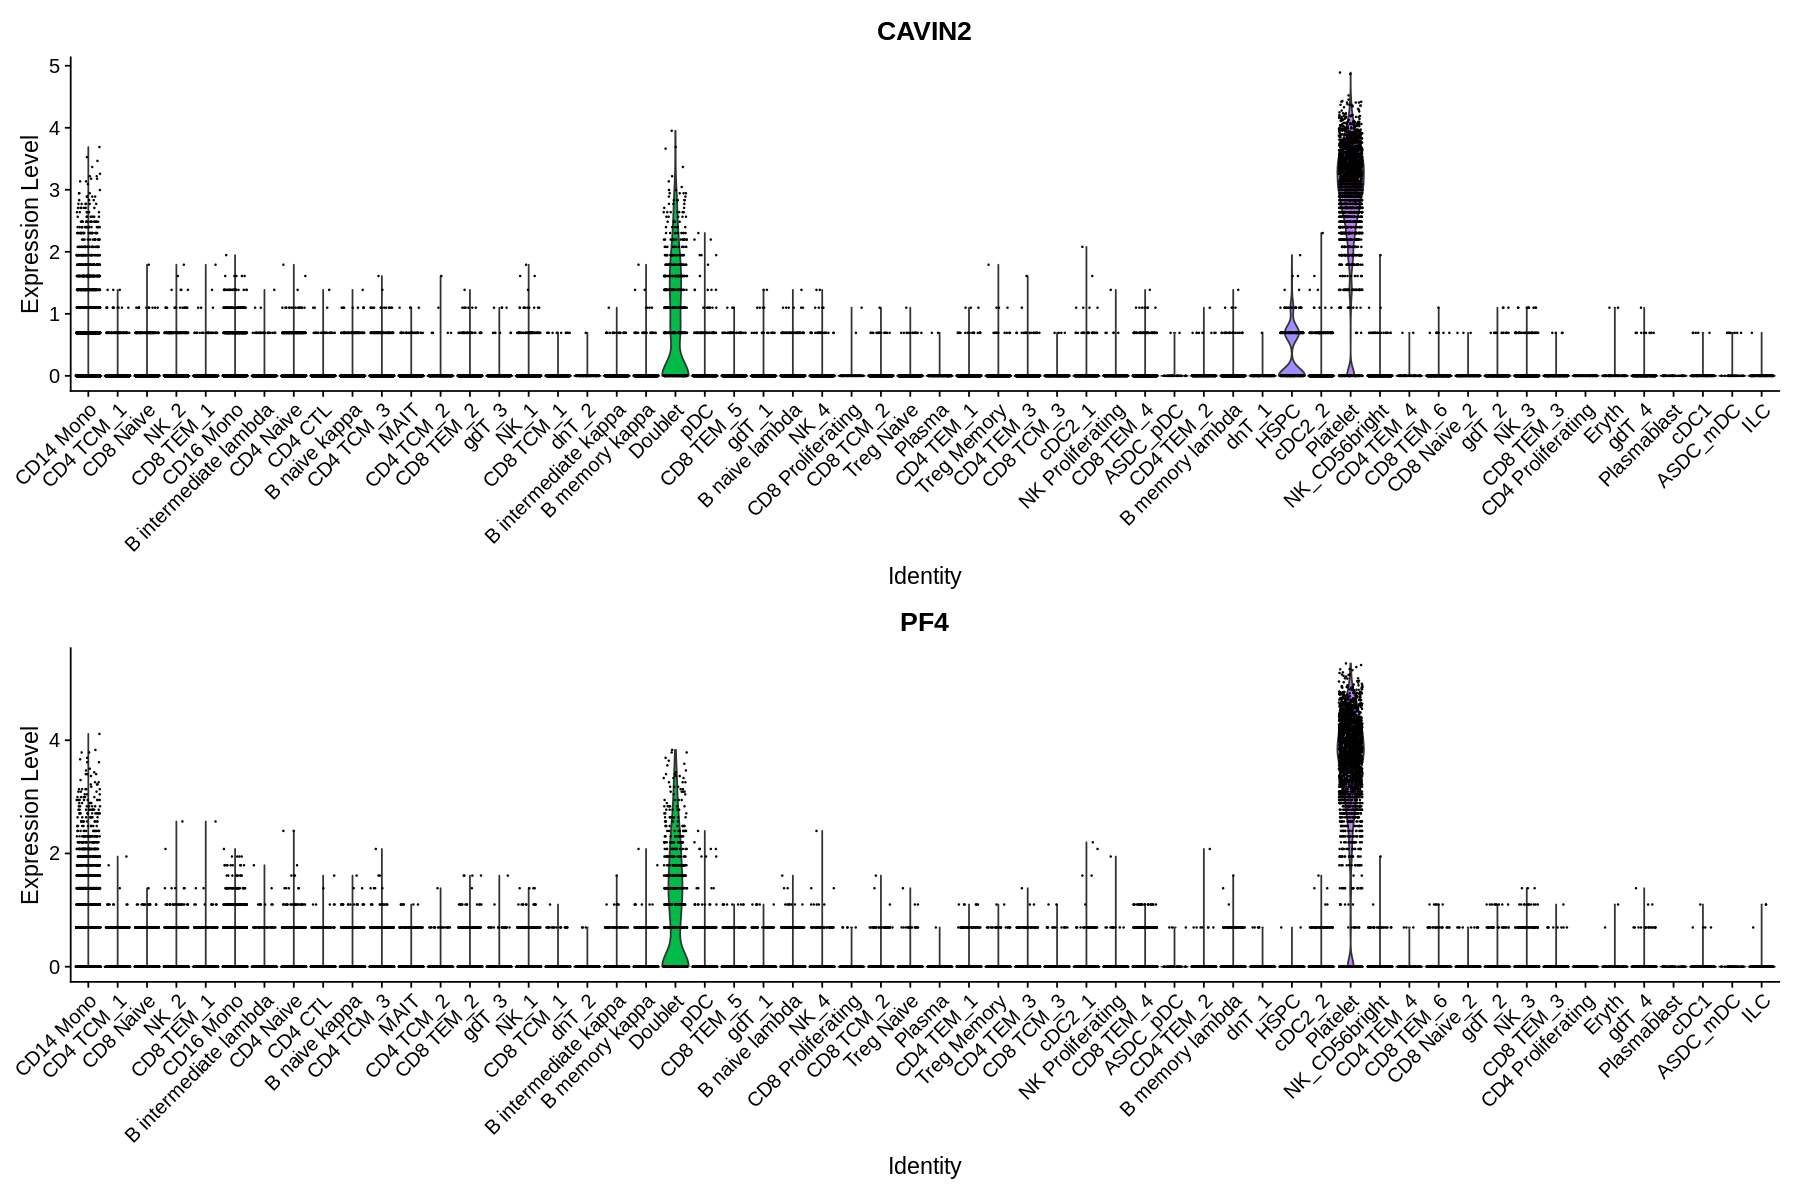

In [103]:
VlnPlot(reference, head(rownames(platelet.markers), 2), ncol = 1)

These genes are also highly specific to platelets (and doublets, which would be due to doublets containing platelets along with other cells).

## Saving the data

Finally, we can save our Seurat object to disk so that we can load it into R later and pick up where we left off.

In [104]:
saveRDS(object = pbmc, file = "./pbmc.rds")